In [1]:
import numpy as np
import random
import time
import math
import random
import os
import json
import sys
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

random.seed(42)
np.random.seed(42)

# Notebook path
current_directory = os.getcwd()
# Get one behind for calling the other modules
root_directory = os.path.abspath(os.path.join(current_directory, '..'))
sys.path.append(root_directory)

#Network and measures
from to_get_data.net_construction_vis_measures import *
from to_get_data.generate_database import *
#Agrobiodiversity
from to_get_data.agrobiodiversity_data import *

from model_class.Variety import Variety
from model_class.UD_clan import *
from model_class.UD_aleatory_inheritance_clan import *

# Methods for data

In [2]:
def heat_diversity_comm_level(matrix, inherits, alphas, kinship_system, variable= ''):
    # Heatmap of diversity at the community level
    mean_values = np.array([[np.mean(matrix[i][j]['diversity_info'][1]) for j in range(len(alphas))] for i in range(len(inherits))])
    mean_values = np.nan_to_num(mean_values, nan=0.0)
    colors = ['#f0f0f0', '#d4e6f1', '#a9cce3', '#7fb3d5', '#5499c7', '#2980b9']
    n_bins = len(colors)
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=n_bins)
    fig, ax = plt.subplots(1, 1, figsize=(7, 5), facecolor="white")
    IM = ax.imshow(mean_values, cmap=cmap, vmin=0, vmax=10)
    cbar = fig.colorbar(IM, ax=ax, label="Mean Diversity")
    ax.set_xticks(np.arange(len(alphas)))
    ax.set_yticks(np.arange(len(inherits)))
    ax.set_xticklabels(alphas)
    ax.set_yticklabels(inherits)
    for i in range(len(inherits)):
        for j in range(len(alphas)):
            text = '0' if mean_values[i, j] == 0 else f'{mean_values[i, j]:.2f}'
            text_color = 'black'
            ax.text(j, i, text, ha="center", va="center", color=text_color, fontsize=8)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax.set_ylabel("Inherit percentage")
    ax.set_xlabel(variable)
    plt.title(f"""
    {kinship_system}
    Mean Diversity at the community level for each configuration""")
    plt.tight_layout()
    plt.show()

In [3]:
def diversity_change_graphs (matrix, inherits, alphas, kinship_system, variable = '', limitant =False):
    def is_valid_data(data): #To see if we have at least one succesful experiment
        return not np.isscalar(data) and not np.isnan(data).all()

    # Define Colors
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown', 'pink', 'gray']

    n_rows = len(inherits)
    n_cols = len(alphas)

    # Big graph
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4), sharex=True, sharey=True)

    valid_configs = 0 #in case we have some configuration with no data due to extintion

    for i, inherit in enumerate(inherits):
        for j, alpha in enumerate(alphas):
            # Get data
            data = matrix[i][j]['diversity_info_steps'][1]
            # Subplot
            ax = axes[i, j]

            # Valid
            if not is_valid_data(data):
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
                ax.set_axis_off()  # Hide the axis if there's no data
                print(f"Skipping Inherit {inherit}%, {variable} {alpha} due to no data")
                continue

            # Mean and std
            mean_data = np.mean(data, axis=0)
            std_data = np.std(data, axis=0)
            # Assign a unique color for each configuration
            color = colors[valid_configs % len(colors)]
            linestyle = '-' if valid_configs % 2 == 0 else '--'

            # Plot
            ax.plot(tempo, mean_data, color=color, linestyle=linestyle)
            ax.fill_between(tempo,mean_data - std_data, mean_data + std_data, color = color, alpha = 0.4)

            # Set labels and title for the subplot
            ax.set_title(f'{inherit}%, {variable} {alpha}')
            ax.grid(True)

            valid_configs += 1 #to change color

    # General figure
    fig.suptitle(f'''
    {kinship_system}
    Diversity Change Over Time for Different Configurations'''
                 , fontsize=16)
    fig.supxlabel('Time Steps')
    fig.supylabel('Diversity')

    # Layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    if limitant == False:
        plt.ylim(0,10)
    plt.show()

In [4]:
def plot_specific_graph(x, y, matrix, inherits, alphas, kinship_system, variable = '', limitant = False):
    """
    Function to plot the graph for specific coordinates (x = i, y = j).
    x corresponds to the 'inherits' index (i), and y corresponds to 'malphas' index (j).
    """
    def is_valid_data(data): #To see if we have at least one succesful experiment
        return not np.isscalar(data) and not np.isnan(data).all()
    if x >= len(inherits) or y >= len(alphas):
        print("Invalid coordinates. Please ensure x and y are within the matrix bounds.")
        return

    # Get data
    inherit = inherits[x]
    alpha = alphas[y]
    data = matrix[x][y]['diversity_info_steps'][1]
    
    # Valid
    if not is_valid_data(data):
        print(f"No valid data for Inherit {inherit}%, {variable} {alpha}.")
        return

    # mean and standard deviation
    mean_data = np.mean(data, axis=0)
    std_data = np.std(data, axis=0)

    # Create a new figure
    plt.figure(figsize=(8, 6))

    # Plot data
    plt.plot(tempo, mean_data, label=f'Inherit {inherit}%, Initial UDs {alpha}', color='r', linestyle='-')

    # Plot the standard deviation as a shaded area
    plt.fill_between(tempo, mean_data - std_data, mean_data + std_data, color='b', alpha=0.2)

    # Add labels, title, and grid
    plt.xlabel('Time Steps')
    plt.ylabel('Diversity Value')
    plt.title(f'''
    {kinship_system}
    Diversity Change Over Time (Inherit {inherit}%, {variable} {alpha})''')
    plt.grid(True)
    if limitant == False:
        plt.ylim(0,10)
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

In [2]:
def transversal_changes(matrix, inherits, alphas, kinship_system, variable=''):
    # Plot
    plt.figure(figsize=(10, 6))
    for i, inherit in enumerate(inherits):  # Loop for graphs
        means, stds = [], []  # Lists
        for j, malpha in enumerate(alphas):
            # Ensure diversity_info is not None
            diversity_info = matrix[i][j].get('diversity_info')
            if diversity_info is not None and len(diversity_info) > 1:  # Check validity
                data = diversity_info[1]
                means.append(np.mean(data))  # Mean
                stds.append(np.std(data))   # Std
            else:
                # Handle missing or invalid data
                means.append(np.nan)  # Append NaN if no valid data
                stds.append(0)  # Zero standard deviation for NaN

        # Plot for each Initial UDs according to the inheritance strategy
        label = inherit if inherit != 'False' else 'Random'
        plt.errorbar(alphas, means, yerr=stds, label=f'{label}', fmt='-o', capsize=5)

    # Labels and title
    plt.xlabel(variable)
    plt.xticks(alphas)
    plt.ylabel('Diversity at the community level')
    plt.title(f'''
    {kinship_system}
    Diversity at the community level for different {variable}''')
    plt.legend(title="Inheritance Levels")
    plt.grid(True)
    plt.ylim(0, 10)
    plt.show()

In [3]:
def transversal_alive(matrix, inherits, alphas, kinship_system, variable=''):
    """
    Creates an error bar plot showing the 'alive' information from the matrix for different inheritance levels,
    using standard error calculated from matrix[i][j]['std'] and alive count.
    """
    # Plot setup
    plt.figure(figsize=(10, 6))
    for i, inherit in enumerate(inherits):  # Loop over inheritance levels
        means, stds = [], []  # Lists for storing means and standard deviations
        for j, malpha in enumerate(alphas):
            # Safely extract 'alive' and 'std' information
            alive = matrix[i][j].get('alive')
            std = matrix[i][j].get('std', [0])  # Default std to [0] if key is missing

            if alive is not None and len(std) > 0:
                mean = alive  # Extract mean 'alive' information
                std_value = std[-1]  # Extract the last value in 'std'
            else:
                # Handle invalid data
                mean = np.nan  # Mark as NaN if data is missing
                std_value = 0  # Zero standard deviation for invalid data

            means.append(mean)
            stds.append(std_value)
        
        # Plot for each inheritance level
        label = inherit if inherit != 'False' else 'Random'
        plt.errorbar(alphas, means, yerr=stds, label=f'{label}', fmt='-o', capsize=5)
    
    # Plot formatting
    plt.xlabel(variable)
    plt.xticks(alphas)
    plt.ylabel('Alive UDs')
    plt.title(f'''
    {kinship_system}
    Alive UDs for Different {variable}''')
    plt.legend(title="Inheritance Levels")
    plt.grid(True)
    plt.ylim(0, 250)  # Adjust y-limit if necessary
    plt.show()

In [7]:
def heat_population (matrix, inherits, alphas, kinship_system, variable = ''):
    # Heatmap population
    alive_values = np.array([
        [matrix[i][j]['alive'] for j in range(len(alphas))]
        for i in range(len(inherits))
    ], dtype=object)
    alive_values = np.where(alive_values == None, 0, alive_values).astype(float)
    fig, ax = plt.subplots(1, 1, figsize=(7, 5), facecolor="white")
    IM = ax.imshow(alive_values, vmin=0, vmax=200)
    cbar = fig.colorbar(IM, ax=ax, label="UDs")
    ax.set_xticks(np.arange(len(alphas)))
    ax.set_yticks(np.arange(len(inherits)))
    ax.set_xticklabels(alphas)
    ax.set_yticklabels(inherits)
    for i in range(len(inherits)):
        for j in range(len(alphas)):
            value = alive_values[i, j]
            bg_color = IM.cmap(IM.norm(value))
            brightness = (0.299 * bg_color[0] + 0.587 * bg_color[1] + 0.114 * bg_color[2])
            text_color = 'white' if brightness < 0.5 else 'black'
            ax.text(j, i, f'{value:.1f}', ha="center", va="center", color=text_color, fontsize=8)
    # Rotate x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Labels
    ax.set_ylabel("Inherit percentage")
    ax.set_xlabel(variable)
    plt.title(f"""
    {kinship_system}. Final population""")
    plt.tight_layout()
    plt.show()

In [57]:
def heat_stds(matrix, inherits, alphas, kinship_system, variable = ''):
    # Heatmap population
    #alive_values = np.array([[np.mean(matrix[i][j]['std']) for j in range(len(alphas))] for i in range(len(inherits))])
    fig, ax = plt.subplots(1, 1, figsize=(7, 5), facecolor="white")
    IM = ax.imshow(alive_values)
    cbar = fig.colorbar(IM, ax=ax, label="UDs")
    ax.set_xticks(np.arange(len(alphas)))
    ax.set_yticks(np.arange(len(inherits)))
    ax.set_xticklabels(alphas)
    ax.set_yticklabels(inherits)
    for i in range(len(inherits)):
        for j in range(len(alphas)):
            value = alive_values[i, j]
            bg_color = IM.cmap(IM.norm(value))
            brightness = (0.299 * bg_color[0] + 0.587 * bg_color[1] + 0.114 * bg_color[2])
            text_color = 'white' if brightness < 0.5 else 'black'
            ax.text(j, i, f'{value:.1f}', ha="center", va="center", color=text_color, fontsize=8)
    # Rotate x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Labels
    ax.set_ylabel("Inherit percentage")
    ax.set_xlabel(variable)
    plt.title(f"""
    {kinship_system}. Final population""")
    plt.tight_layout()
    plt.show()

In [9]:
def heat_percentage_population(matrix, inherits, alphas, kinship_system, variable = ''):
    # Heatmap porcentage of extinction
    alive_values = np.array([[(matrix[i][j]['percentage_extinction']) for j in range(len(alphas))] for i in range(len(inherits))])
    #alive_values = np.array([[entry['porcentage_extintion'] for entry in row] for row in matrix])
    fig, ax = plt.subplots(1, 1, figsize=(7, 5), facecolor="white")
    IM = ax.imshow(alive_values, cmap='viridis_r')
    cbar = fig.colorbar(IM, ax=ax, label="UDs")
    ax.set_xticks(np.arange(len(alphas)))
    ax.set_yticks(np.arange(len(inherits)))
    ax.set_xticklabels(alphas)
    ax.set_yticklabels(inherits)
    for i in range(len(inherits)):
        for j in range(len(alphas)):
            value = alive_values[i, j]
            bg_color = IM.cmap(IM.norm(value))
            brightness = (0.299 * bg_color[0] + 0.587 * bg_color[1] + 0.114 * bg_color[2])
            text_color = 'white' if brightness < 0.5 else 'black'
            ax.text(j, i, f'{value:.1f}', ha="center", va="center", color=text_color, fontsize=8)
    # Rotate x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Labels
    ax.set_ylabel("Inherit percentage")
    ax.set_xlabel(variable)
    plt.title(f"""
    {kinship_system}. Porcentage of extintion by each configuration""")
    plt.tight_layout()
    plt.show()

In [10]:
def plot_specific_alivegraph(x, y, matrix, inherits, alphas, kinship_system, variable = ''):
    #Graph of experiment with mean and std
    # Main line
    plt.plot(matrix[x][y]['tempo'], matrix[x][y]['mean'], 's-', label='Media', alpha=0.7)

    # Std
    plt.fill_between(matrix[x][y]['tempo'], matrix[x][y]['mean'] - matrix[x][y]['std'],
                     matrix[x][y]['mean'] + matrix[x][y]['std'], color='red', alpha=0.2, label='Std')

    plt.xlabel('Tempo (t)')
    plt.ylabel('UDs')
    plt.ylim(bottom=0)
    plt.title(f'''
    UDs no tempo.
    {variable} {alphas[y]} e Inheritage percentage: {inherits[x]}
    Taxa media de crescimento: {matrix[x][y]['growth rate']}''')
    plt.legend()
    plt.show()

In [11]:
def diversity_change_by_row(matrix, inherits, alphas, kinship_system, variable='', limitant=False):
    def is_valid_data(data):
        return not np.isscalar(data) and not np.isnan(data).all()

    # Define colors
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown', 'pink', 'gray']

    # For each row (inherit percentage)
    for i, inherit in enumerate(inherits):
        fig, ax = plt.subplots(figsize=(10, 6))

        valid_configs = 0  # For assigning unique colors

        for j, alpha in enumerate(alphas):
            data = matrix[i][j]['diversity_info_steps'][1]

            # Skip invalid data
            if not is_valid_data(data):
                print(f"Skipping Inherit {inherit}%, {variable} {alpha} due to no data")
                continue

            mean_data = np.mean(data, axis=0)
            std_data = np.std(data, axis=0)

            color = colors[valid_configs % len(colors)]
            linestyle = '-' if valid_configs % 2 == 0 else '--'

            # Plot for this alpha value
            ax.plot(tempo, mean_data, color=color, linestyle=linestyle, label=f'{variable} {alpha}')
            #ax.fill_between(tempo, mean_data - std_data, mean_data + std_data, color=color, alpha=0.4)

            valid_configs += 1

        ax.set_title(f'Diversity Change Over Time for Inherit {inherit}%')
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Diversity')
        ax.grid(True)
        ax.legend(title="Alpha")
        ax.set_ylim(bottom=0)

        if not limitant:
            ax.set_ylim(0, 10)

        plt.tight_layout()
        plt.show()

In [12]:
def diversity_change_by_column(matrix, inherits, alphas, kinship_system, variable='', limitant=False):
    def is_valid_data(data):
        return not np.isscalar(data) and not np.isnan(data).all()

    # Define colors
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown', 'pink', 'gray']

    # For each column (alpha value)
    for j, alpha in enumerate(alphas):
        fig, ax = plt.subplots(figsize=(10, 6))

        valid_configs = 0  # For assigning unique colors

        for i, inherit in enumerate(inherits):
            data = matrix[i][j]['diversity_info_steps'][1]

            # Skip invalid data
            if not is_valid_data(data):
                print(f"Skipping Inherit {inherit}%, {variable} {alpha} due to no data")
                continue

            mean_data = np.mean(data, axis=0)
            std_data = np.std(data, axis=0)

            color = colors[valid_configs % len(colors)]
            linestyle = '-' if valid_configs % 2 == 0 else '--'

            # Plot for this inherit percentage
            ax.plot(tempo, mean_data, color=color, linestyle=linestyle, label=f'{inherit}%')
            #ax.fill_between(tempo, mean_data - std_data, mean_data + std_data, color=color, alpha=0.4)

            valid_configs += 1

        ax.set_title(f'Diversity Change Over Time for {variable} {alpha}')
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Diversity')
        ax.grid(True)
        ax.legend(title="Inherit %")
        ax.set_ylim(bottom=0)

        if not limitant:
            ax.set_ylim(0, 10)

        plt.tight_layout()
        plt.show()

# Endogamy

## Initial UDs

Here we experimento with Initial UDs. We try from 10 to 100

In [ ]:
# This experiment has different values for Initial UDs
prob_morte = 0.06 #beta
media = 4 # Mean
m = 100# Initial UDs
inherits = [0,25,50, 'False']
# inherits = [0,25,50] #Values for inherit
# inherits = [0, 'False'] #Values for inherit
Emalphas = np.linspace(10,m,int(m/10)) # Initial UDs: from 10 to m
# For data of behaviour
mM = np.empty((len(inherits), len(Emalphas)), dtype=object) # alive, mean and diversity levels

punto_vista = 50
tiempo = 1000
tempo = list(range(0,tiempo+1,punto_vista))
experiments = 100
max_iterations = 140


print(mM.shape)
start = time.time()
print(f"started at:  {datetime.now()}")
for i, inherit in enumerate(inherits):
    for j, iniciais  in enumerate(Emalphas):
        star_configuration = time.time()
        #For population dynamics
        list_alive_UDs = []
        list_vivas_puntos_vista = []
        tasas_crecimiento = []
        #For diversity dynamics
        data_step_mean_var_ud = []
        data_step_var_system = []
        data_step_unique_system = []
        print(f"Experiments with inheritance {inherit} and Initial UDs {iniciais}")
        #Lists to store experiments' diversity data
        data_endo_mean_ud = []
        data_endo_com_level = []
        data_endo_total_varieties = []
        original_media = media
        #To see how frequent goes to extintion
        contador = 0
        iterations = 0
        while contador < experiments and iterations < max_iterations: 
        #for experiment in range(1, experiments+1):
            print(f'experimento {contador+1}')
            if inherit != 'False':
                
                #### Initialization
                UD_endogamy.uds = {}
                instancias_ud = []
                for id_ud in range(1, int(iniciais) + 1):
                    instancias_ud.append(UD_endogamy(id_ud, media))
                ## Varieties
                limited_varieties = True
                if limited_varieties == False:
                    for id_ud, ud in UD_endogamy.uds.items():
                        for _ in range(3):
                            ud.varieties.append(Variety())
                else:
                    initial_varieties = [Variety() for _ in range (10)]
                    for ud in UD_endogamy.uds.values():
                        for _ in range(3):
                            ud.varieties.append(random.choice(initial_varieties))   
                # Lists for graphs
                vivas_puntos_vista = [int(iniciais)]
                vivas_tasa_crecimiento = [int(iniciais)]
        #             mortas_puntos_vista = [0]
                #For diversity
                mean_var_ud = []
                var_system = []
                unique_system = []
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_endogamy.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                # Simulation
                for t in range(1, tiempo):
                    uds_copy = {id_ud: ud for id_ud, ud in UD_endogamy.uds.items() if ud.activa}
                    items = list(uds_copy.items())
                    random.shuffle(items)
                    uds_copy = dict(items)
                    alive = len(uds_copy)
                    if alive > 200 and (media == original_media):
                        media -= media//2
                        if media >= 4:
                            media = media //2
                    elif alive < 150 and media < original_media:
                        media = original_media
                    if not uds_copy: #Extintion
                        # Only 0
                        print(f"acabó en 0 el experimento {experiment} con herencia {inherits[i]} con unidades {Emalphas[j]}")
                        break         
                    # Cycle:
                    for id_ud, ud in uds_copy.items():
                        ud.ter_filho()
                        ud.buscar_ud(uds_copy, int(media), inherit)
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
                    # Collecting data
                    vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                    if t % punto_vista == 0:
                        viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                        #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                        vivas_puntos_vista.append(viv)
                        # For diversity
                        var_ud = []
                        var_total = []
                        for ud in [ud for ud in UD_endogamy.uds.values() if ud.activa ==True]:
                            var_ud.append(len(ud.varieties))
                            for variety in ud.varieties:
                                var_total.append(variety.variety_id)
                        mean_var_ud.append(np.mean(var_ud))
                        var_system.append(len(var_total))
                        unique_system.append(len(set(var_total))) 
                viv = len([ud for id, ud in UD_endogamy.uds.items() if ud.activa])
                vivas_puntos_vista.append(viv)
                # For diversity
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_endogamy.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                alive = (len([ud for id, ud in uds_copy.items() if ud.activa]))
                if alive >= 1:   
                    total_varieties = []
                    varieties_per_UD = []
                    for ud in [ud for ud in UD_endogamy.uds.values() if ud.activa ==True]:
                        varieties_per_UD.append(len(ud.varieties))
                        for variety in ud.varieties:
                            total_varieties.append(variety.variety_id)
                    data_endo_mean_ud.append(np.mean(varieties_per_UD))
                    data_endo_com_level.append(len(set(total_varieties)))
                    data_endo_total_varieties.append(total_varieties)
            
            else:# Now with inherit == False
                #### Initialization
                UD_endogamy_al_inh.uds = {}
                instancias_ud = []
                for id_ud in range(1, int(iniciais) + 1):
                    instancias_ud.append(UD_endogamy_al_inh(id_ud, media))
                ## Varieties
                limited_varieties = True
                if limited_varieties == False:
                    for id_ud, ud in UD_endogamy_al_inh.uds.items():
                        for _ in range(3):
                            ud.varieties.append(Variety())
                else:
                    initial_varieties = [Variety() for _ in range (10)]
                    for ud in UD_endogamy_al_inh.uds.values():
                        for _ in range(3):
                            ud.varieties.append(random.choice(initial_varieties))   
                # Lists for graphs
                vivas_puntos_vista = [int(iniciais)]
                vivas_tasa_crecimiento = [int(iniciais)]
        #             mortas_puntos_vista = [0]
                #For diversity
                mean_var_ud = []
                var_system = []
                unique_system = []
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_endogamy_al_inh.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                # Simulation
                for t in range(1, tiempo):
                    uds_copy = {id_ud: ud for id_ud, ud in UD_endogamy_al_inh.uds.items() if ud.activa}
                    items = list(uds_copy.items())
                    random.shuffle(items)
                    uds_copy = dict(items)
                    alive = len(uds_copy)
                    if alive > 200 and (media == original_media):
                        media -= media//2
                        if media >= 4:
                            media = media //2
                    elif alive < 150 and media < original_media:
                        media = original_media
                    if not uds_copy: #Extintion
                        # Only 0
                        print(f"acabó en 0 el experimento {experiment} con herencia {inherits[i]} con unidades {Emalphas[j]}")
                        break         
                    # Cycle:
                    varieties_list = [var for ud in uds_copy.values() for var in ud.varieties]
                    for id_ud, ud in uds_copy.items():
                        ud.ter_filho()
                        ud.buscar_ud(uds_copy, int(media), varieties_list, 3)
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
                    # Collecting data
                    vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                    if t % punto_vista == 0:
                        viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                        #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                        vivas_puntos_vista.append(viv)
                        # For diversity
                        var_ud = []
                        var_total = []
                        for ud in [ud for ud in UD_endogamy_al_inh.uds.values() if ud.activa ==True]:
                            var_ud.append(len(ud.varieties))
                            for variety in ud.varieties:
                                var_total.append(variety.variety_id)
                        mean_var_ud.append(np.mean(var_ud))
                        var_system.append(len(var_total))
                        unique_system.append(len(set(var_total))) 
                viv = len([ud for id, ud in UD_endogamy_al_inh.uds.items() if ud.activa])
                vivas_puntos_vista.append(viv)
                # For diversity
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_endogamy_al_inh.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                alive = (len([ud for id, ud in uds_copy.items() if ud.activa]))
                if alive >= 1:   
                    total_varieties = []
                    varieties_per_UD = []
                    for ud in [ud for ud in UD_endogamy_al_inh.uds.values() if ud.activa ==True]:
                        varieties_per_UD.append(len(ud.varieties))
                        for variety in ud.varieties:
                            total_varieties.append(variety.variety_id)
                    data_endo_mean_ud.append(np.mean(varieties_per_UD))
                    data_endo_com_level.append(len(set(total_varieties)))
                    data_endo_total_varieties.append(total_varieties)
            
            
            if len(uds_copy) > 0:
                list_alive_UDs.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                list_vivas_puntos_vista.append(vivas_puntos_vista)
                data_step_var_system.append(var_system)
                data_step_unique_system.append(unique_system)
                data_step_mean_var_ud.append(mean_var_ud)
                contador += 1
            iterations += 1
            print('succesful', contador)
            print('iterations', iterations)
            
            data_inherit_endo = [data_endo_mean_ud, data_endo_com_level, data_endo_total_varieties]
        data_steps_inherit_endo = [data_step_var_system, data_step_unique_system, data_step_mean_var_ud]
        media = original_media
        end_config = time.time()
        if contador == experiments:
            mM[i][j] = {
                'alive': np.mean(list_alive_UDs),
                'lstd': np.std(list_alive_UDs),
                'time used': end_config - star_configuration,
                'percentage_extinction': contador / experiments,
                'tempo': tempo, 
                'mean': np.mean(list_vivas_puntos_vista, axis=0), 
                'std': np.std(list_vivas_puntos_vista, axis=0),
                'growth rate': np.mean([np.mean(lista) for lista in tasas_crecimiento]),
                'diversity_info': data_inherit_endo,
                'diversity_info_steps': data_steps_inherit_endo,
            }
        else:  # Handle extinction-only scenarios
            mM[i][j] = {
                'alive': None,
                'lstd': None,
                'time used': end_config - star_configuration,
                'percentage_extinction': 1.0,  # All experiments went extinct
                'tempo': None, 
                'mean': None, 
                'std': None,
                'growth rate': None,
                'diversity_info': None,
                'diversity_info_steps': None,
            }
        print(f"""
The total time of the configuration of inherit percentage {inherit} and initial UDs {iniciais} is  {end_config - star_configuration}
        """)
# Folder
folder_name = 'Experiments_kinship_inheritance_parameters'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Data
heat_std = os.path.join(folder_name, 'Endo_Initial_UDs.npy')
np.save(heat_std, mM)
now = datetime.now()
finish = time.time()
print(f"""
It finished at: {now}
It lasted {finish-start}
""")
print("done")

In [5]:
# Dowload the documents
#As a reference
m = 100
inherits = [0,25,50, 'False']#Values for inherit
# inherits = [0, 'False'] #Values for inherit
Emalphas = np.linspace(10,m,int(m/10)) # Initial UDs: from 10 to m
punto_vista = 50
tiempo = 1000
tempo = list(range(0,tiempo+1,punto_vista))

#Folders
folder_name = 'Experiments_kinship_inheritance_parameters'
heat_std = os.path.join(folder_name, 'Endo_Initial_UDs.npy')

## General Data
EmM_datos = np.load(heat_std, allow_pickle=True)

### Data and visualizations: diversity

In [ ]:
# heat_diversity_comm_level(EmM_datos, inherits, Emalphas, 'Endogamy', variable='Initial UDs')
# diversity_change_graphs(EmM_datos, inherits, Emalphas, 'Endogamy', variable = 'Initial UDs')
# diversity_change_by_row(EmM_datos, inherits, Emalphas, 'Endogamy', variable='Initial UDs')
# diversity_change_by_column(EmM_datos, inherits, Emalphas, 'Endogamy', variable='Initial UDs')
#plot_specific_graph(1, 1, EmM_datos, inherits, Emalphas, 'Endogamy', variable = 'Initial UDs')

In [ ]:
transversal_changes(EmM_datos, inherits, Emalphas, 'Endogamy', variable='Initial UDs')
transversal_alive(EmM_datos, inherits, Emalphas, 'Endogamy', variable='Initial UDs')

### Data and visualizations: population

In [ ]:
heat_population(EmM_datos, inherits, Emalphas, 'Endogamy', variable='Initial UDs')
heat_percentage_population(EmM_datos, inherits, Emalphas, 'Endogamy', variable='Initial UDs')
heat_stds(EmM_datos, inherits, Emalphas, 'Endogamy', variable='Initial UDs')

## Initial Varieties

Here we try with different values for the initial varieties in the system.
We go from 10 to 100.

In [ ]:
# This experiment has different values for Initial varieties VVVV
prob_morte = 0.06 #beta
media = 4 # Mean
m = 40
v = 100 # Initial varieties
inherits = [0,25,50, 'False']
# inherits = [0,25,50] #Values for inherit
# inherits = [0, 'False'] #Values for inherit
Evalphas = np.linspace(10,v,int(v/10)) # Initial Varieties: from 10 to v
# For data of behaviour
vM = np.empty((len(inherits), len(Evalphas)), dtype=object) # alive, mean and diversity levels

punto_vista = 50
tiempo = 500
tempo = list(range(0,tiempo+1,punto_vista))
experiments = 100
max_iterations = 200


print(vM.shape)
start = time.time()
print(f"started at:  {datetime.now()}")
for i, inherit in enumerate(inherits):
    for j, varieties  in enumerate(Evalphas):
        star_configuration = time.time()
        #For population dynamics
        list_alive_UDs = []
        list_vivas_puntos_vista = []
        tasas_crecimiento = []
        #For diversity dynamics
        data_step_mean_var_ud = []
        data_step_var_system = []
        data_step_unique_system = []
        print(f"Experiments with inheritance {inherit} Initial UDs {m} and Initial varieties {varieties}")
        #Lists to store experiments' diversity data
        data_endo_mean_ud = []
        data_endo_com_level = []
        data_endo_total_varieties = []
        original_media = media
        #To see how frequent goes to extintion
        contador = 0
        iterations = 0
        while contador < experiments and iterations < max_iterations: 
        #for experiment in range(1, experiments+1):
            print(f'experimento {contador+1}')
            if inherit != 'False':
                
                #### Initialization
                UD_endogamy.uds = {}
                instancias_ud = []
                for id_ud in range(1, int(m) + 1):
                    instancias_ud.append(UD_endogamy(id_ud, media))
                ## Varieties
                limited_varieties = True
                if limited_varieties == False:
                    for id_ud, ud in UD_endogamy.uds.items():
                        for _ in range(3):
                            ud.varieties.append(Variety())
                else:
                    initial_varieties = [Variety() for _ in range (int(varieties))]
                    for ud in UD_endogamy.uds.values():
                        for _ in range(3):
                            ud.varieties.append(random.choice(initial_varieties))   
                # Lists for graphs
                vivas_puntos_vista = [int(m)]
                vivas_tasa_crecimiento = [int(m)]
        #             mortas_puntos_vista = [0]
                #For diversity
                mean_var_ud = []
                var_system = []
                unique_system = []
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_endogamy.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                # Simulation
                for t in range(1, tiempo):
                    uds_copy = {id_ud: ud for id_ud, ud in UD_endogamy.uds.items() if ud.activa}
                    items = list(uds_copy.items())
                    random.shuffle(items)
                    uds_copy = dict(items)
                    alive = len(uds_copy)
                    if alive > 200 and (media == original_media):
                        media -= media//2
                        if media >= 4:
                            media = media //2
                    elif alive < 150 and media < original_media:
                        media = original_media
                    if not uds_copy: #Extintion
                        # Only 0
                        print(f"acabó en 0 el experimento {experiment} con herencia {inherits[i]} con unidades {Evalphas[j]}")
                        break         
                    # Cycle:
                    for id_ud, ud in uds_copy.items():
                        ud.ter_filho()
                        ud.buscar_ud(uds_copy, int(media), inherit)
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
                    # Collecting data
                    vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                    if t % punto_vista == 0:
                        viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                        #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                        vivas_puntos_vista.append(viv)
                        # For diversity
                        var_ud = []
                        var_total = []
                        for ud in [ud for ud in UD_endogamy.uds.values() if ud.activa ==True]:
                            var_ud.append(len(ud.varieties))
                            for variety in ud.varieties:
                                var_total.append(variety.variety_id)
                        mean_var_ud.append(np.mean(var_ud))
                        var_system.append(len(var_total))
                        unique_system.append(len(set(var_total))) 
                viv = len([ud for id, ud in UD_endogamy.uds.items() if ud.activa])
                vivas_puntos_vista.append(viv)
                # For diversity
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_endogamy.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                alive = (len([ud for id, ud in uds_copy.items() if ud.activa]))
                if alive >= 1:   
                    total_varieties = []
                    varieties_per_UD = []
                    for ud in [ud for ud in UD_endogamy.uds.values() if ud.activa ==True]:
                        varieties_per_UD.append(len(ud.varieties))
                        for variety in ud.varieties:
                            total_varieties.append(variety.variety_id)
                    data_endo_mean_ud.append(np.mean(varieties_per_UD))
                    data_endo_com_level.append(len(set(total_varieties)))
                    data_endo_total_varieties.append(total_varieties)
            
            else:# Now with inherit == False
                #### Initialization
                UD_endogamy_al_inh.uds = {}
                instancias_ud = []
                for id_ud in range(1, int(m) + 1):
                    instancias_ud.append(UD_endogamy_al_inh(id_ud, media))
                ## Varieties
                limited_varieties = True
                if limited_varieties == False:
                    for id_ud, ud in UD_endogamy_al_inh.uds.items():
                        for _ in range(3):
                            ud.varieties.append(Variety())
                else:
                    initial_varieties = [Variety() for _ in range (int(varieties))]
                    for ud in UD_endogamy_al_inh.uds.values():
                        for _ in range(3):
                            ud.varieties.append(random.choice(initial_varieties))   
                # Lists for graphs
                vivas_puntos_vista = [int(m)]
                vivas_tasa_crecimiento = [int(m)]
        #             mortas_puntos_vista = [0]
                #For diversity
                mean_var_ud = []
                var_system = []
                unique_system = []
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_endogamy_al_inh.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                # Simulation
                for t in range(1, tiempo):
                    uds_copy = {id_ud: ud for id_ud, ud in UD_endogamy_al_inh.uds.items() if ud.activa}
                    items = list(uds_copy.items())
                    random.shuffle(items)
                    uds_copy = dict(items)
                    alive = len(uds_copy)
                    if alive > 200 and (media == original_media):
                        media -= media//2
                        if media >= 4:
                            media = media //2
                    elif alive < 150 and media < original_media:
                        media = original_media
                    if not uds_copy: #Extintion
                        # Only 0
                        print(f"acabó en 0 el experimento {experiment} con herencia {inherits[i]} con unidades {Evalphas[j]}")
                        break         
                    # Cycle:
                    varieties_list = [var for ud in uds_copy.values() for var in ud.varieties]
                    for id_ud, ud in uds_copy.items():
                        ud.ter_filho()
                        ud.buscar_ud(uds_copy, int(media), varieties_list, 3)
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
                    # Collecting data
                    vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                    if t % punto_vista == 0:
                        viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                        #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                        vivas_puntos_vista.append(viv)
                        # For diversity
                        var_ud = []
                        var_total = []
                        for ud in [ud for ud in UD_endogamy_al_inh.uds.values() if ud.activa ==True]:
                            var_ud.append(len(ud.varieties))
                            for variety in ud.varieties:
                                var_total.append(variety.variety_id)
                        mean_var_ud.append(np.mean(var_ud))
                        var_system.append(len(var_total))
                        unique_system.append(len(set(var_total))) 
                viv = len([ud for id, ud in UD_endogamy_al_inh.uds.items() if ud.activa])
                vivas_puntos_vista.append(viv)
                # For diversity
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_endogamy_al_inh.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                alive = (len([ud for id, ud in uds_copy.items() if ud.activa]))
                if alive >= 1:   
                    total_varieties = []
                    varieties_per_UD = []
                    for ud in [ud for ud in UD_endogamy_al_inh.uds.values() if ud.activa ==True]:
                        varieties_per_UD.append(len(ud.varieties))
                        for variety in ud.varieties:
                            total_varieties.append(variety.variety_id)
                    data_endo_mean_ud.append(np.mean(varieties_per_UD))
                    data_endo_com_level.append(len(set(total_varieties)))
                    data_endo_total_varieties.append(total_varieties)
            
            
            # Final collection of the data after the simulation!
            if len(uds_copy) > 0:  # Only collect data if the system is alive
                list_alive_UDs.append(len([ud for id, ud in uds_copy.items() if ud.activa == True]))  # For heatmap
                list_vivas_puntos_vista.append(vivas_puntos_vista)
                data_step_var_system.append(var_system)
                data_step_unique_system.append(unique_system)
                data_step_mean_var_ud.append(mean_var_ud)
                contador += 1
            iterations += 1
            print('succesful', contador)
            print('iterations', iterations)
            
            data_inherit_endo = [data_endo_mean_ud, data_endo_com_level, data_endo_total_varieties]
        data_steps_inherit_endo = [data_step_var_system, data_step_unique_system, data_step_mean_var_ud]
        media = original_media
        end_config = time.time()
        if contador == experiments:
            vM[i][j] = {
                'alive': np.mean(list_alive_UDs),
                'lstd': np.std(list_alive_UDs),
                'time used': end_config - star_configuration,
                'percentage_extinction': contador / experiments,
                'tempo': tempo, 
                'mean': np.mean(list_vivas_puntos_vista, axis=0), 
                'std': np.std(list_vivas_puntos_vista, axis=0),
                'growth rate': np.mean([np.mean(lista) for lista in tasas_crecimiento]),
                'diversity_info': data_inherit_endo,
                'diversity_info_steps': data_steps_inherit_endo,
            }
        else:  # Handle extinction-only scenarios
            vM[i][j] = {
                'alive': None,
                'lstd': None,
                'time used': end_config - star_configuration,
                'percentage_extinction': 1.0,  # All experiments went extinct
                'tempo': None, 
                'mean': None, 
                'std': None,
                'growth rate': None,
                'diversity_info': None,
                'diversity_info_steps': None,
            }
        print(f"""
The total time of the configuration of inherit percentage {inherit}, 
  initial UDs {m} and Initial varieties {varieties} is  {end_config - star_configuration}
        """)
# Folder
folder_name = 'Experiments_kinship_inheritance_parameters'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Heatmap and std
heat_std = os.path.join(folder_name, 'Endo_Initial_Varieties.npy')
np.save(heat_std, vM)
now = datetime.now()
finish = time.time()
print(f"""
It finished at: {now}
It lasted {finish-start}
""")
print("done")

In [7]:
# Dowload the documents
#As a reference
v = 100
inherits = [0,25,50, 'False']#Values for inherit
# inherits = [0, 'False'] #Values for inherit
Evalphas = np.linspace(10,v,int(v/10)) # Initial UDs: from 10 to m
punto_vista = 50
tiempo = 1000
tempo = list(range(0,tiempo+1,punto_vista))

#Folders
folder_name = 'Experiments_kinship_inheritance_parameters'
heat_std = os.path.join(folder_name, 'Endo_Initial_Varieties.npy')
## heatmap and mean
EvM_datos = np.load(heat_std, allow_pickle=True)

## Diversity dynamics

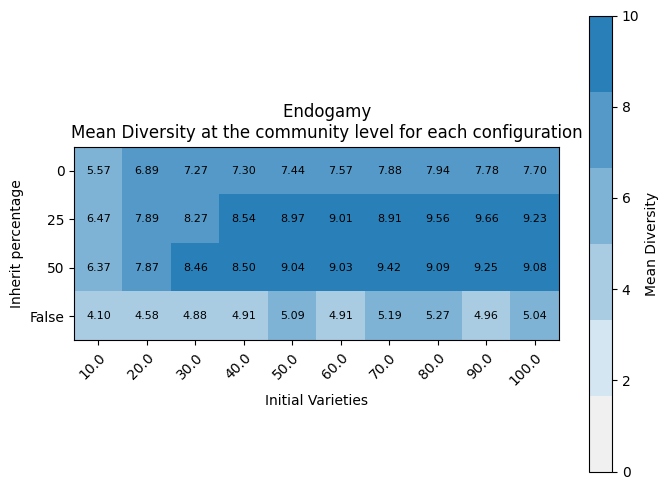

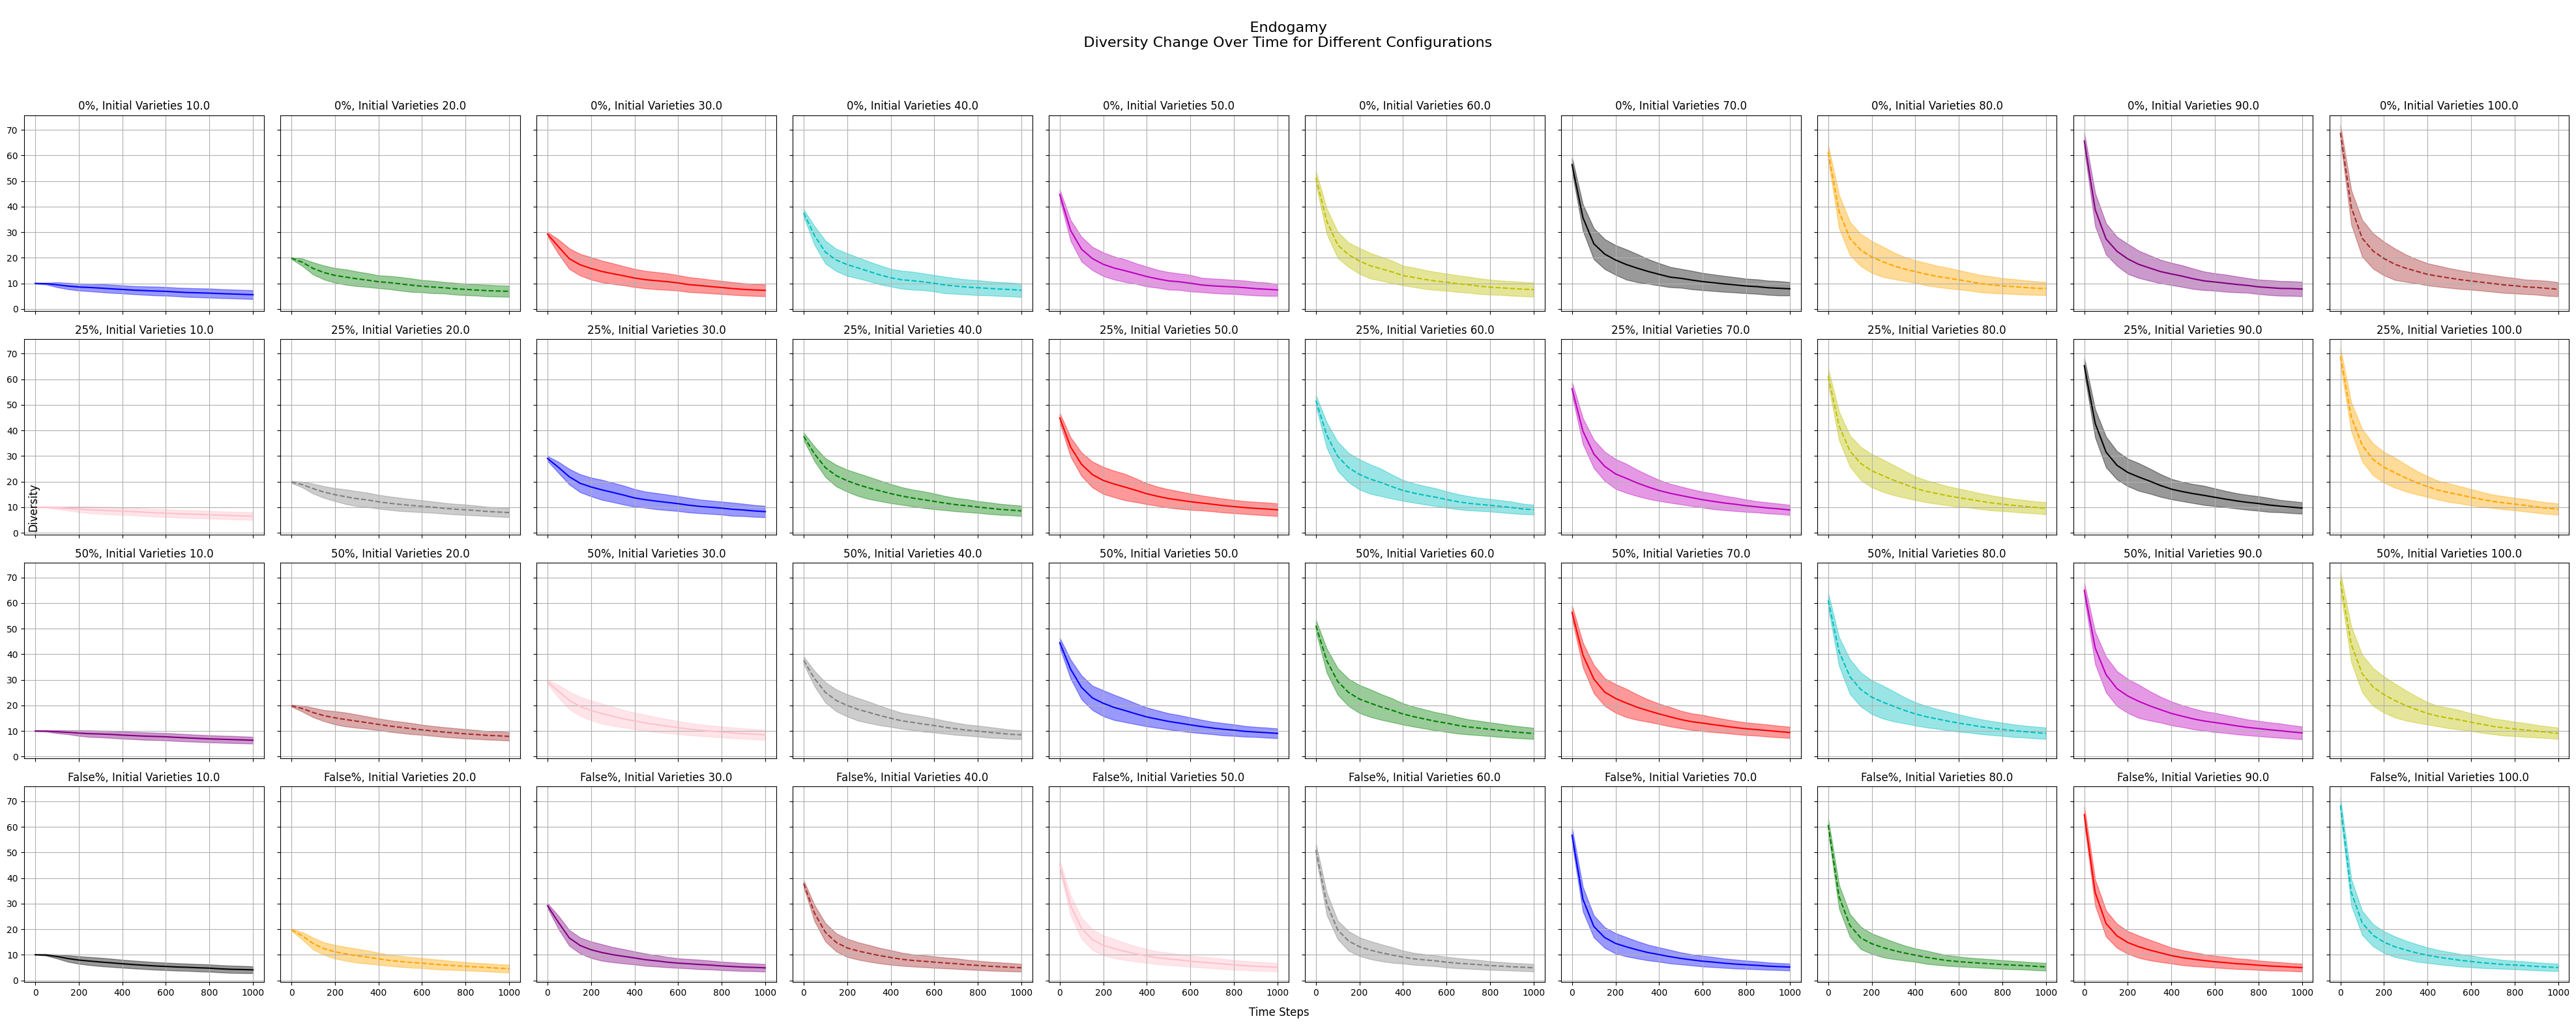

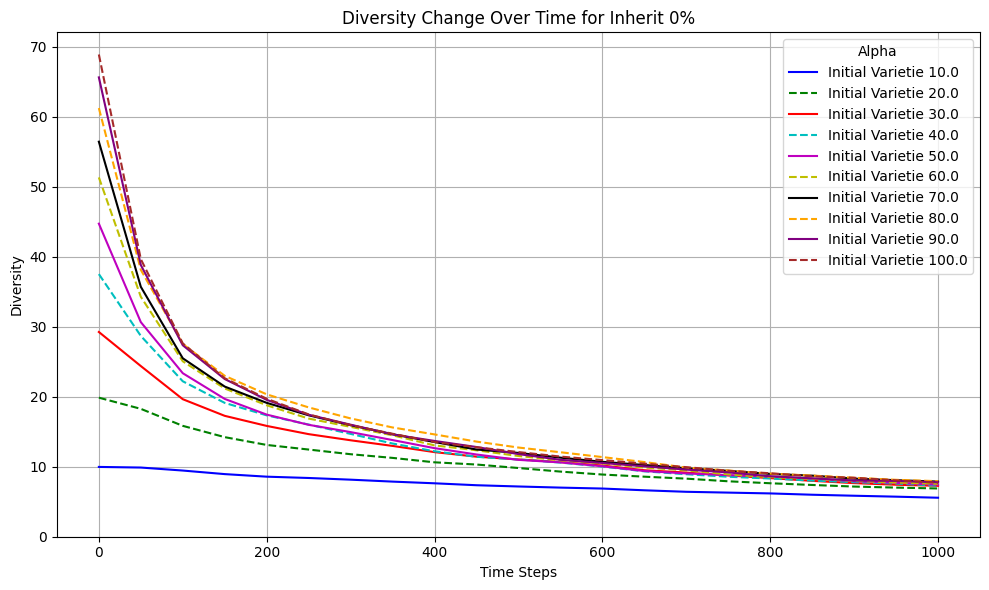

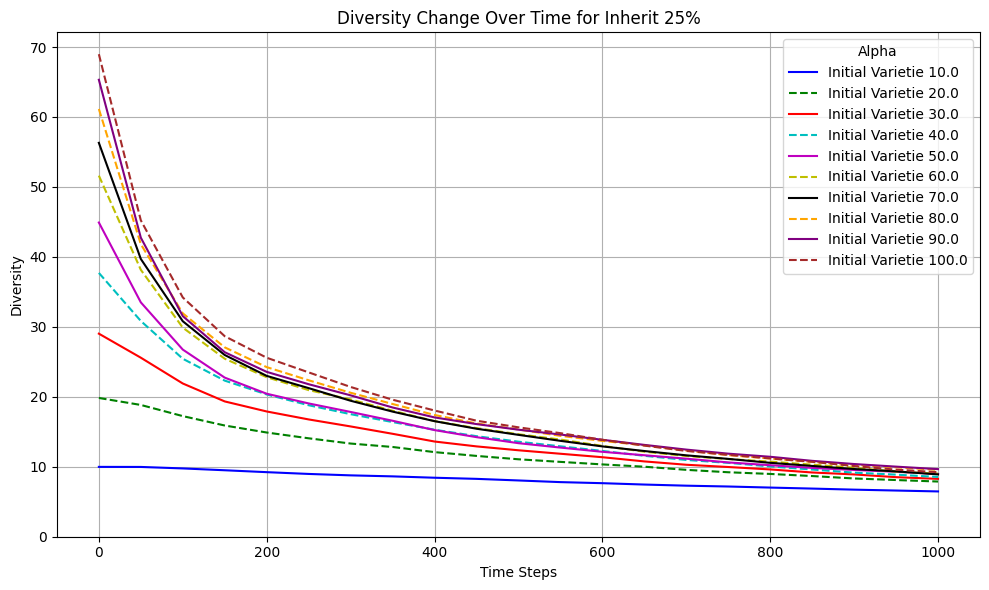

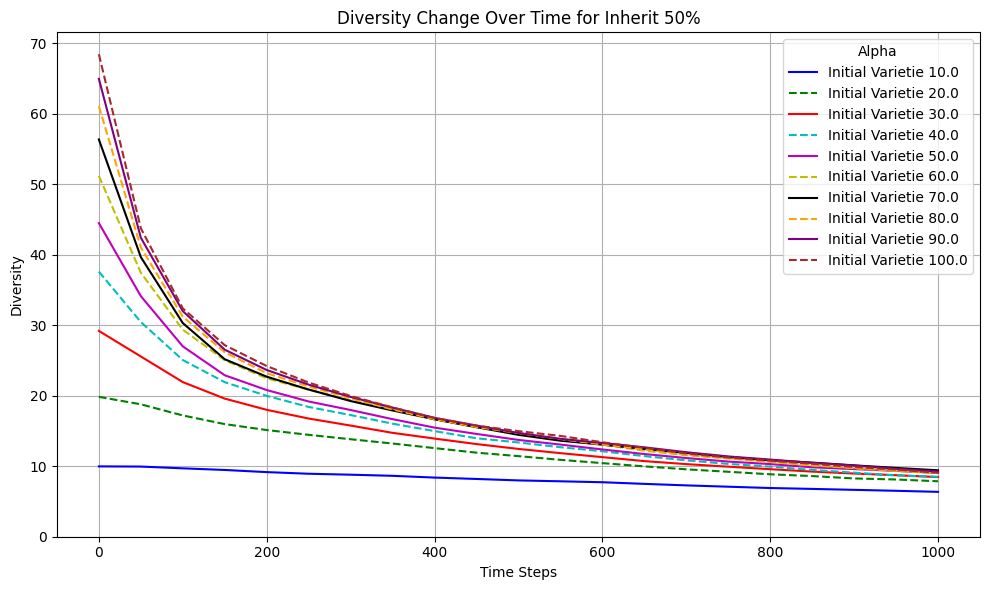

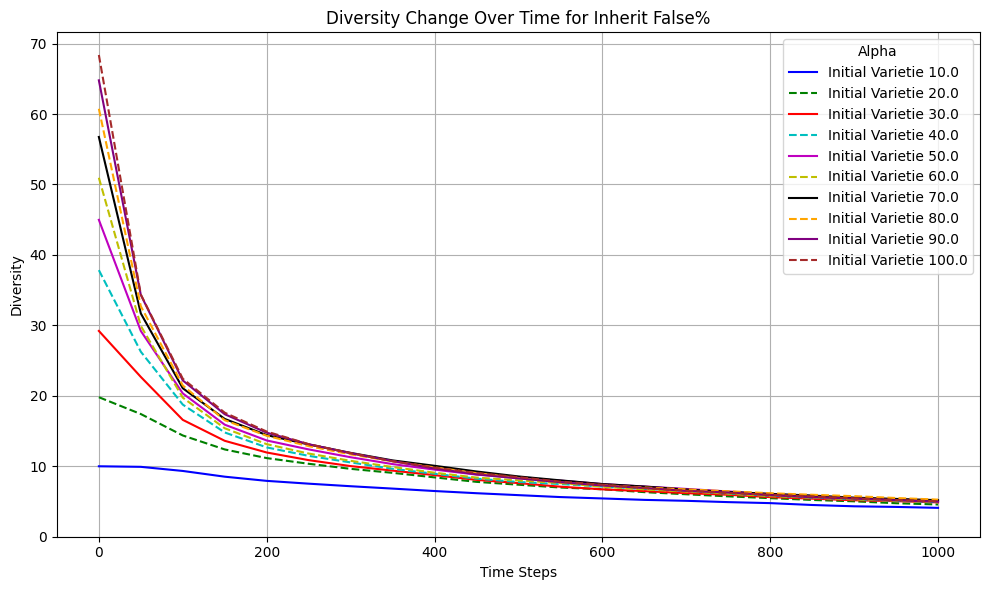

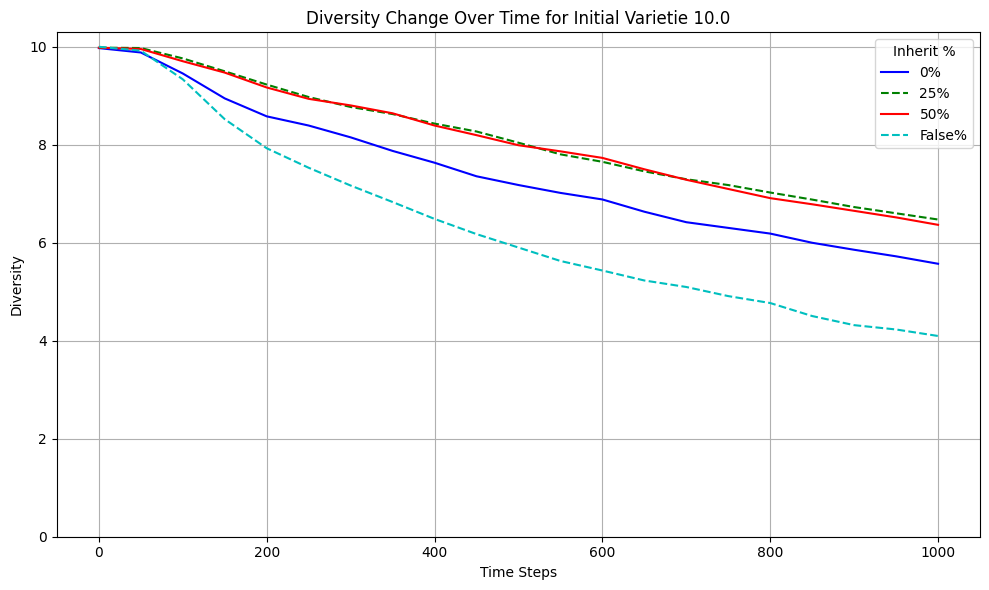

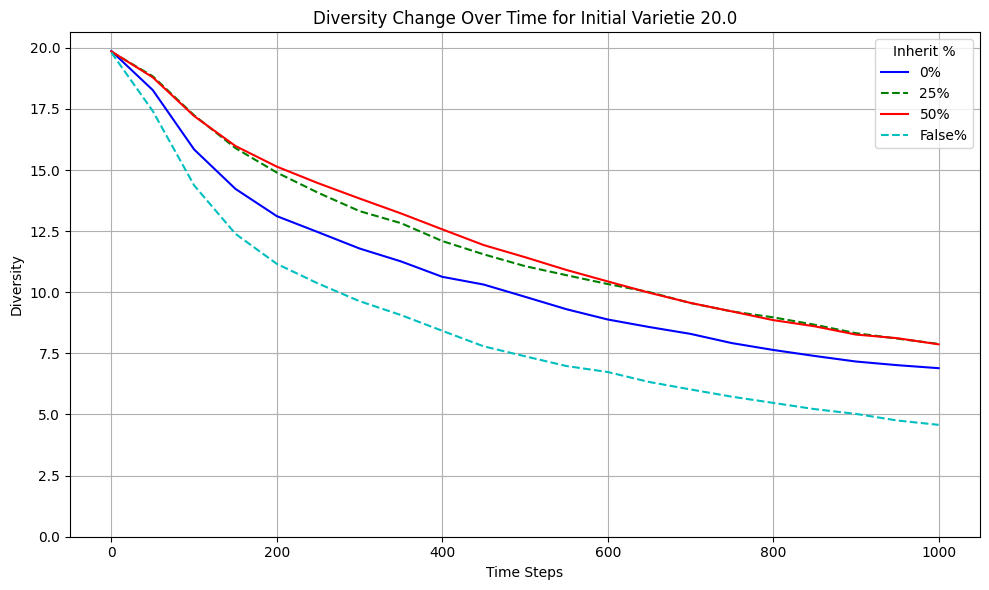

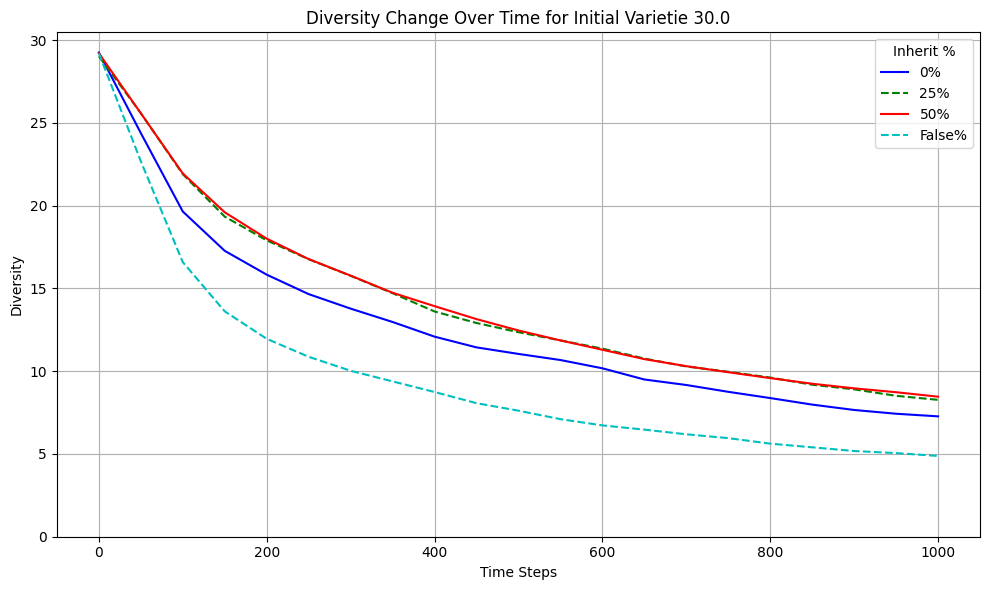

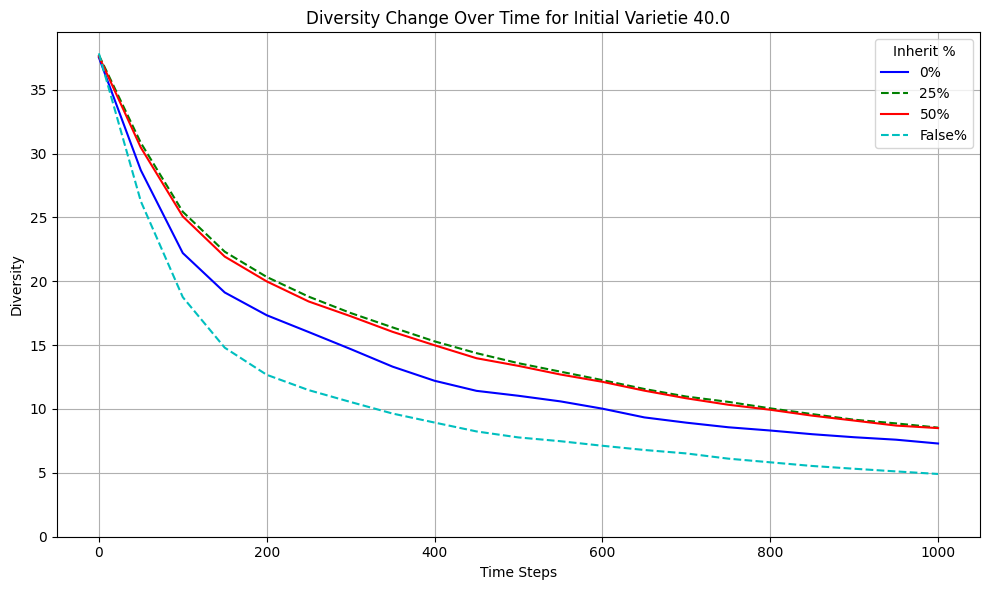

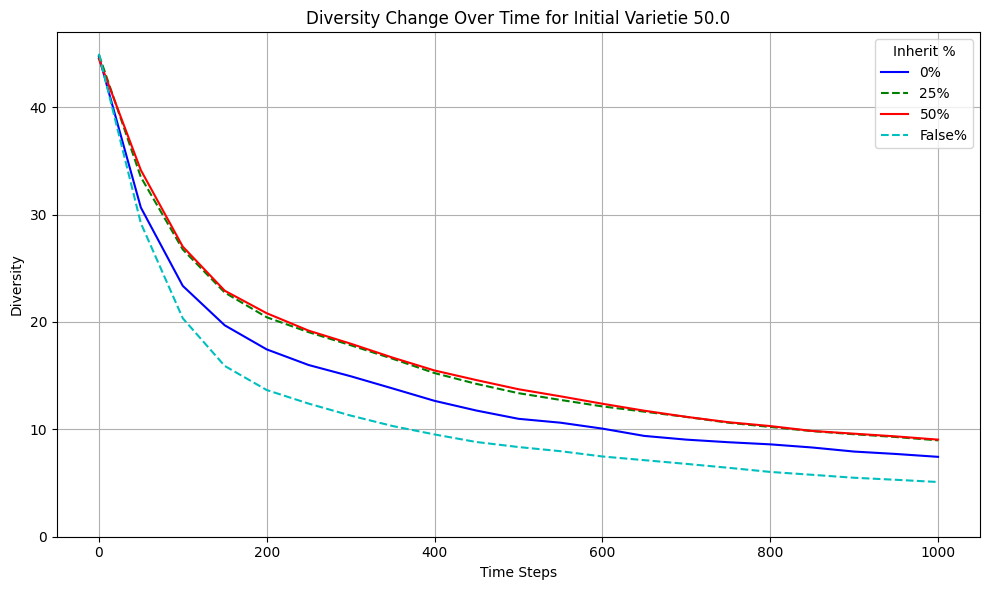

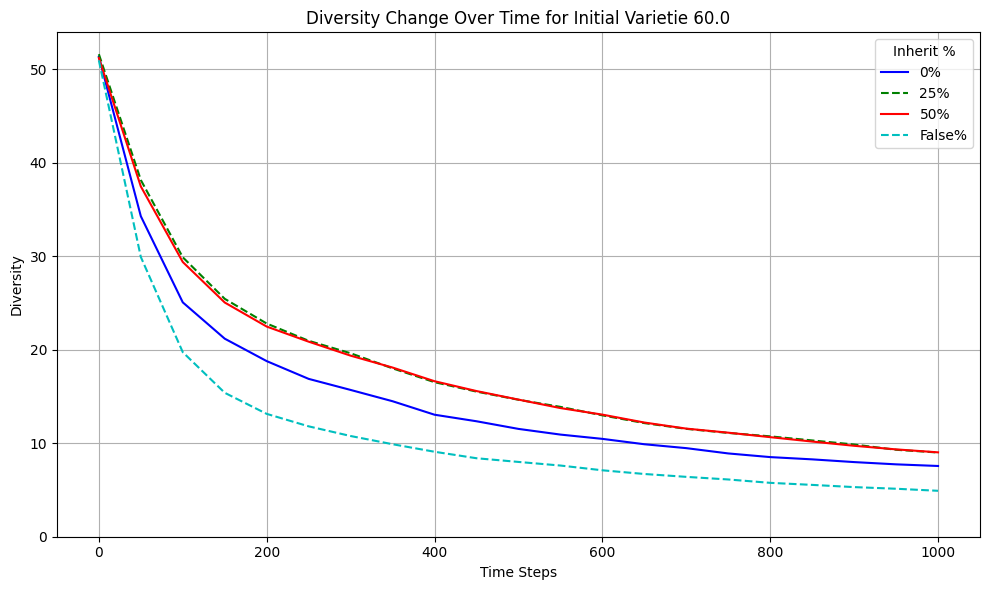

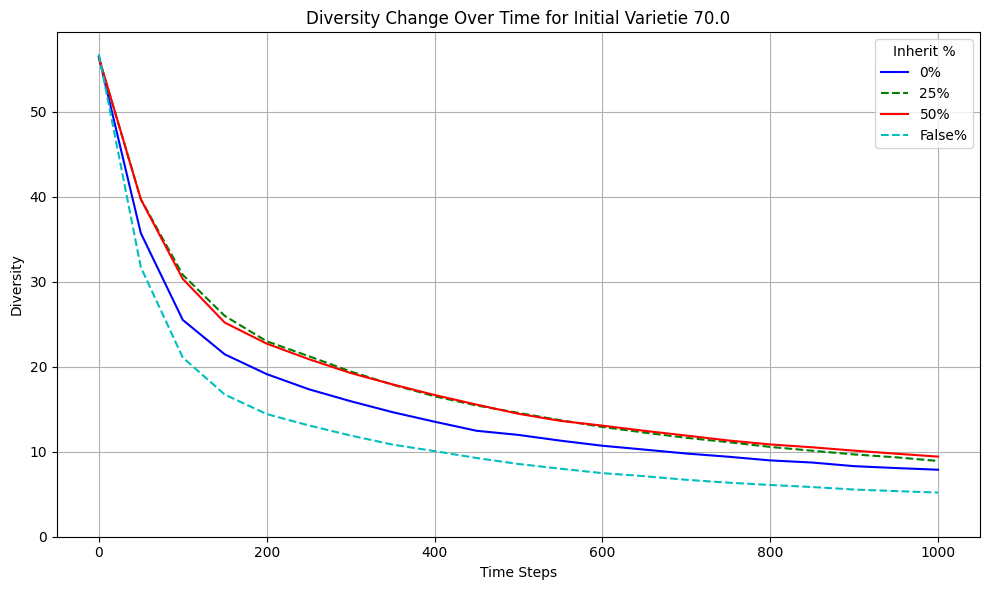

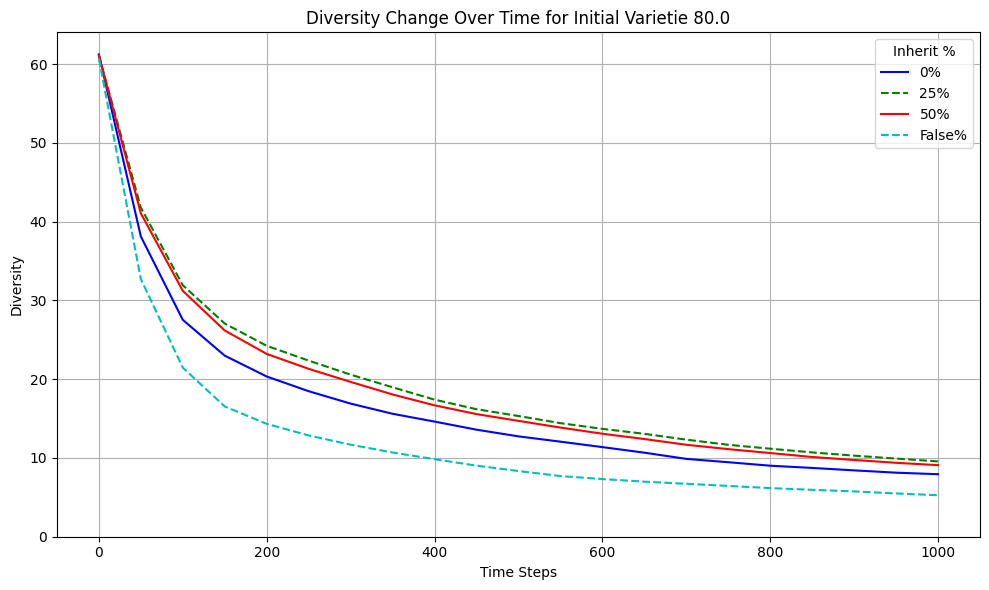

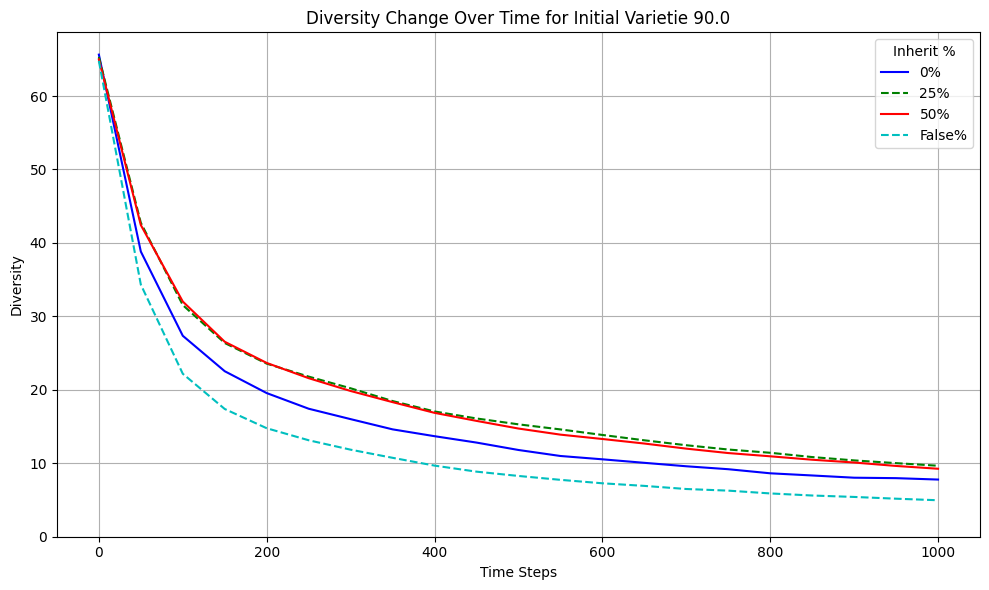

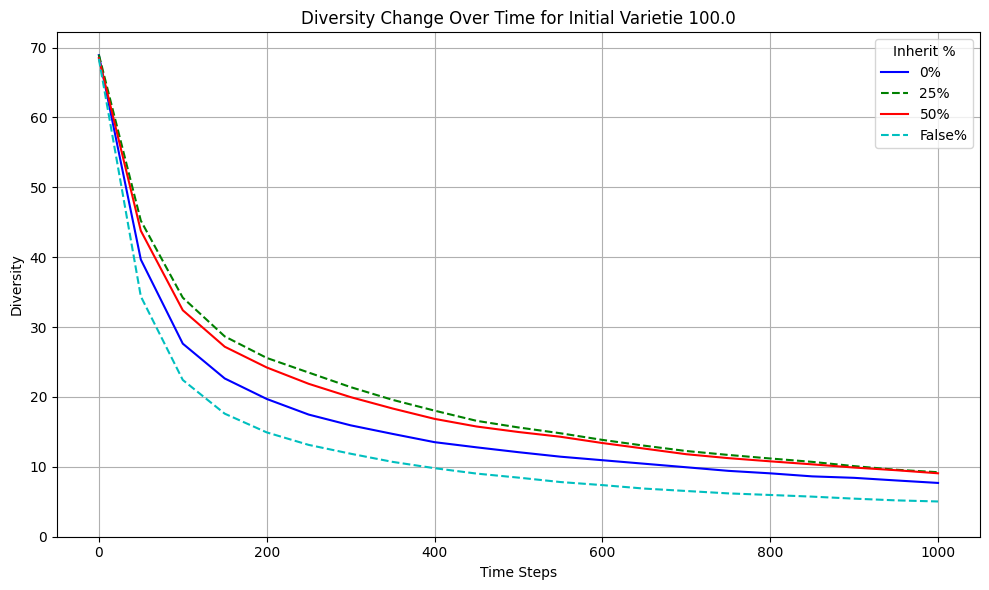

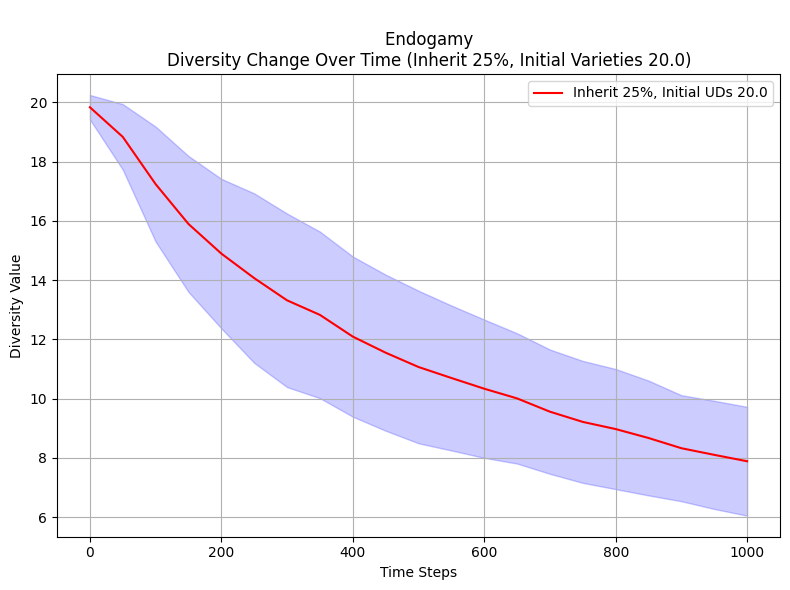

In [26]:
# heat_diversity_comm_level(EvM_datos, inherits, Evalphas, 'Endogamy', variable='Initial Varieties')
# diversity_change_graphs(EvM_datos, inherits, Evalphas, 'Endogamy', variable='Initial Varieties', limitant = True)
# diversity_change_by_row(EvM_datos, inherits, Evalphas, 'Endogamy', variable='Initial Varietie', limitant=True)
# diversity_change_by_column(EvM_datos, inherits, Evalphas, 'Endogamy', variable='Initial Varietie', limitant=True)
# plot_specific_graph(1, 1, EvM_datos, inherits, Evalphas, 'Endogamy', variable='Initial Varieties', limitant = True)

In [ ]:
transversal_changes(EvM_datos, inherits, Evalphas, 'Endogamy', variable='Initial Varieties')
transversal_alive(EvM_datos, inherits, Evalphas, 'Endogamy', variable='Initial Varieties')

## Pop dynamics

In [ ]:
heat_population(EvM_datos, inherits, Evalphas, 'Endogamy', variable='Initial Varieties')
# heat_percentage_population(EvM_datos, inherits, Evalphas, 'Endogamy', variable='Initial Varieties')
# heat_stds(EvM_datos, inherits, Evalphas, 'Endogamy', variable='Initial Varieties')

## Mean of children 


In [ ]:
# This experiment has different values for Mean of children
prob_morte = 0.06 #beta
n = 10 # Mean
m = 40 # Initial UDs
inherits = [0,25,50, 'False']
Ecalphas = np.linspace(1,n,n) # Mean of children from 1 to n
# For data of behaviour
cM = np.empty((len(inherits), len(Ecalphas)), dtype=object) # alive, mean and diversity levels

punto_vista = 50
tiempo = 1000
tempo = list(range(0,tiempo+1,punto_vista))
experiments = 100
max_iterations = 200


print(cM.shape)
start = time.time()
print(f"started at:  {datetime.now()}")
for i, inherit in enumerate(inherits):
    for j, media  in enumerate(Ecalphas):
        star_configuration = time.time()
        #For population dynamics
        list_alive_UDs = []
        list_vivas_puntos_vista = []
        tasas_crecimiento = []
        #For diversity dynamics
        data_step_mean_var_ud = []
        data_step_var_system = []
        data_step_unique_system = []
        print(f"Experiments with inheritance {inherit} and Mean of Children {media}")
        #Lists to store experiments' diversity data
        data_endo_mean_ud = []
        data_endo_com_level = []
        data_endo_total_varieties = []
        original_media = media
        #To see how frequent goes to extintion
        contador = 0
        iterations = 0
        while contador < experiments and iterations < max_iterations: 
            print(f'experimento {contador+1}')
            if inherit != 'False':
                #### Initialization
                UD_endogamy.uds = {}
                instancias_ud = []
                for id_ud in range(1, int(m) + 1):
                    instancias_ud.append(UD_endogamy(id_ud, media))
                ## Varieties
                limited_varieties = True
                if limited_varieties == False:
                    for id_ud, ud in UD_endogamy.uds.items():
                        for _ in range(3):
                            ud.varieties.append(Variety())
                else:
                    initial_varieties = [Variety() for _ in range (10)]
                    for ud in UD_endogamy.uds.values():
                        for _ in range(3):
                            ud.varieties.append(random.choice(initial_varieties))   
                # Lists for graphs
                vivas_puntos_vista = [int(m)]
                vivas_tasa_crecimiento = [int(m)]
        #             mortas_puntos_vista = [0]
                #For diversity
                mean_var_ud = []
                var_system = []
                unique_system = []
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_endogamy.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                # Simulation
                for t in range(1, tiempo):
                    uds_copy = {id_ud: ud for id_ud, ud in UD_endogamy.uds.items() if ud.activa}
                    items = list(uds_copy.items())
                    random.shuffle(items)
                    uds_copy = dict(items)
                    alive = len(uds_copy)
                    if alive > 200 and (media == original_media):
                        media -= media//2
                        if media >= 4:
                            media = media //2
                    elif alive < 150 and media < original_media:
                        media = original_media
                    if not uds_copy: #Extintion
                        # Only 0
                        print(f"acabó en 0 el experimento {experiment} con herencia {inherits[i]} con mean {Ecalphas[j]}")
                        break         
                    # Cycle:
                    for id_ud, ud in uds_copy.items():
                        ud.ter_filho()
                        ud.buscar_ud(uds_copy, int(media), inherit)
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
                    # Collecting data
                    vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                    if t % punto_vista == 0:
                        viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                        #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                        vivas_puntos_vista.append(viv)
                        # For diversity
                        var_ud = []
                        var_total = []
                        for ud in [ud for ud in UD_endogamy.uds.values() if ud.activa ==True]:
                            var_ud.append(len(ud.varieties))
                            for variety in ud.varieties:
                                var_total.append(variety.variety_id)
                        mean_var_ud.append(np.mean(var_ud))
                        var_system.append(len(var_total))
                        unique_system.append(len(set(var_total))) 
                viv = len([ud for id, ud in UD_endogamy.uds.items() if ud.activa])
                vivas_puntos_vista.append(viv)
                # For diversity
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_endogamy.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                alive = (len([ud for id, ud in uds_copy.items() if ud.activa]))
                if alive >= 1:   
                    total_varieties = []
                    varieties_per_UD = []
                    for ud in [ud for ud in UD_endogamy.uds.values() if ud.activa ==True]:
                        varieties_per_UD.append(len(ud.varieties))
                        for variety in ud.varieties:
                            total_varieties.append(variety.variety_id)
                    data_endo_mean_ud.append(np.mean(varieties_per_UD))
                    data_endo_com_level.append(len(set(total_varieties)))
                    data_endo_total_varieties.append(total_varieties)
            
            else:# Now with inherit == False
                #### Initialization
                UD_endogamy_al_inh.uds = {}
                instancias_ud = []
                for id_ud in range(1, int(m) + 1):
                    instancias_ud.append(UD_endogamy_al_inh(id_ud, media))
                ## Varieties
                limited_varieties = True
                if limited_varieties == False:
                    for id_ud, ud in UD_endogamy_al_inh.uds.items():
                        for _ in range(3):
                            ud.varieties.append(Variety())
                else:
                    initial_varieties = [Variety() for _ in range (10)]
                    for ud in UD_endogamy_al_inh.uds.values():
                        for _ in range(3):
                            ud.varieties.append(random.choice(initial_varieties))   
                # Lists for graphs
                vivas_puntos_vista = [int(m)]
                vivas_tasa_crecimiento = [int(m)]
        #             mortas_puntos_vista = [0]
                #For diversity
                mean_var_ud = []
                var_system = []
                unique_system = []
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_endogamy_al_inh.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                # Simulation
                for t in range(1, tiempo):
                    uds_copy = {id_ud: ud for id_ud, ud in UD_endogamy_al_inh.uds.items() if ud.activa}
                    items = list(uds_copy.items())
                    random.shuffle(items)
                    uds_copy = dict(items)
                    alive = len(uds_copy)
                    if alive > 200 and (media == original_media):
                        media -= media//2
                        if media >= 4:
                            media = media //2
                    elif alive < 150 and media < original_media:
                        media = original_media
                    if not uds_copy: #Extintion
                        # Only 0
                        print(f"acabó en 0 el experimento {experiment} con herencia {inherits[i]} con mean {Ecalphas[j]}")
                        break         
                    # Cycle:
                    varieties_list = [var for ud in uds_copy.values() for var in ud.varieties]
                    for id_ud, ud in uds_copy.items():
                        ud.ter_filho()
                        ud.buscar_ud(uds_copy, int(media), varieties_list, 3)
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
                    # Collecting data
                    vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                    if t % punto_vista == 0:
                        viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                        #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                        vivas_puntos_vista.append(viv)
                        # For diversity
                        var_ud = []
                        var_total = []
                        for ud in [ud for ud in UD_endogamy_al_inh.uds.values() if ud.activa ==True]:
                            var_ud.append(len(ud.varieties))
                            for variety in ud.varieties:
                                var_total.append(variety.variety_id)
                        mean_var_ud.append(np.mean(var_ud))
                        var_system.append(len(var_total))
                        unique_system.append(len(set(var_total))) 
                viv = len([ud for id, ud in UD_endogamy_al_inh.uds.items() if ud.activa])
                vivas_puntos_vista.append(viv)
                # For diversity
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_endogamy_al_inh.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                alive = (len([ud for id, ud in uds_copy.items() if ud.activa]))
                if alive >= 1:   
                    total_varieties = []
                    varieties_per_UD = []
                    for ud in [ud for ud in UD_endogamy_al_inh.uds.values() if ud.activa ==True]:
                        varieties_per_UD.append(len(ud.varieties))
                        for variety in ud.varieties:
                            total_varieties.append(variety.variety_id)
                    data_endo_mean_ud.append(np.mean(varieties_per_UD))
                    data_endo_com_level.append(len(set(total_varieties)))
                    data_endo_total_varieties.append(total_varieties)
            
            
            # Final collection of the data after the simulation!
            if len(uds_copy) > 0:  # Only collect data if the system is alive
                list_alive_UDs.append(len([ud for id, ud in uds_copy.items() if ud.activa == True]))  # For heatmap
                list_vivas_puntos_vista.append(vivas_puntos_vista)
                data_step_var_system.append(var_system)
                data_step_unique_system.append(unique_system)
                data_step_mean_var_ud.append(mean_var_ud)
                contador += 1
            iterations += 1
            print('succesful', contador)
            print('iterations', iterations) 
            
            data_inherit_endo = [data_endo_mean_ud, data_endo_com_level, data_endo_total_varieties]
        data_steps_inherit_endo = [data_step_var_system, data_step_unique_system, data_step_mean_var_ud]
        media = original_media
        end_config = time.time()
        if contador == experiments: 
            cM[i][j] = {
                'alive': np.mean(list_alive_UDs),
                'lstd': np.std(list_alive_UDs),
                'time used': end_config - star_configuration,
                'percentage_extinction': contador / experiments,
                'tempo': tempo, 
                'mean': np.mean(list_vivas_puntos_vista, axis=0), 
                'std': np.std(list_vivas_puntos_vista, axis=0),
                'growth rate': np.mean([np.mean(lista) for lista in tasas_crecimiento]),
                'diversity_info': data_inherit_endo,
                'diversity_info_steps': data_steps_inherit_endo,
            }
        else:  # Handle extinction-only scenarios
            cM[i][j] = {
                'alive': None,
                'lstd': None,
                'time used': end_config - star_configuration,
                'percentage_extinction': 1.0,  # All experiments went extinct
                'tempo': None, 
                'mean': None, 
                'std': None,
                'growth rate': None,
                'diversity_info': None,
                'diversity_info_steps': None,
            }
        print(f"""
The total time of the configuration of inherit percentage {inherit} and initial UDs {m} and mean {media} is  {end_config - star_configuration}
        """)
# Folder
folder_name = 'Experiments_kinship_inheritance_parameters'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Data
heat_std = os.path.join(folder_name, 'Endo_Mean_children.npy')
np.save(heat_std, cM)
now = datetime.now()
finish = time.time()
print(f"""
It finished at: {now}
It lasted {finish-start}
""")
print("done")

In [9]:
# Dowload the documents
#As a reference
n = 10 # Mean
# m = 40 # Initial UDs
inherits = [0,25,50, 'False']
Ecalphas = np.linspace(1,n,n) # Mean of children from 1 to n
punto_vista = 50
tiempo = 1000
tempo = list(range(0,tiempo+1,punto_vista))

#Folders
folder_name = 'Experiments_kinship_inheritance_parameters'
heat_std = os.path.join(folder_name, 'Endo_Mean_children.npy')

## General Data
EcM_datos = np.load(heat_std, allow_pickle=True)

### Data and visualizations: diversity

Skipping Inherit 0%, Mean of children 1.0 due to no data
Skipping Inherit 0%, Mean of children 2.0 due to no data
Skipping Inherit 0%, Mean of children 3.0 due to no data


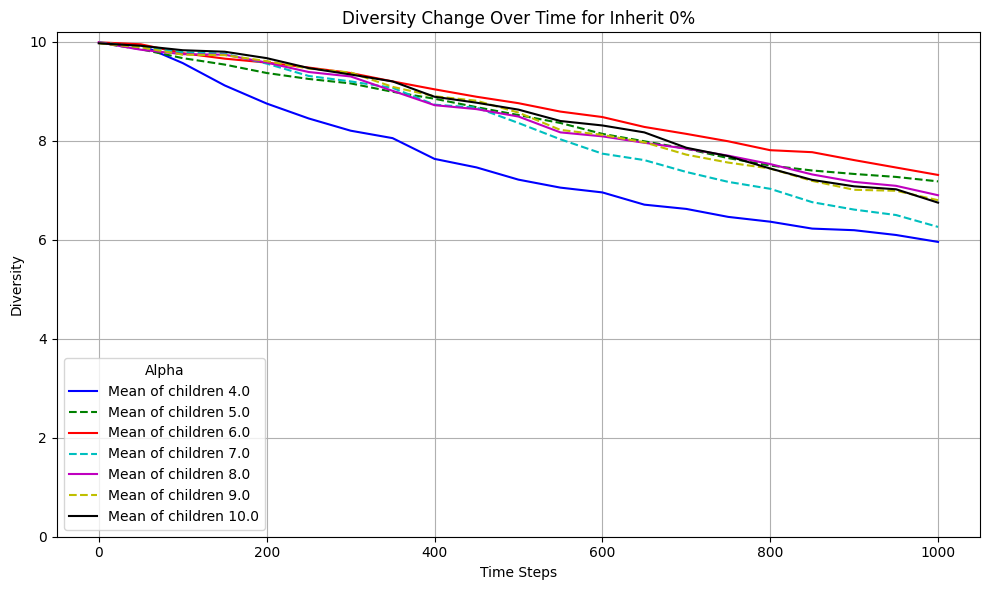

Skipping Inherit 25%, Mean of children 1.0 due to no data
Skipping Inherit 25%, Mean of children 2.0 due to no data
Skipping Inherit 25%, Mean of children 3.0 due to no data


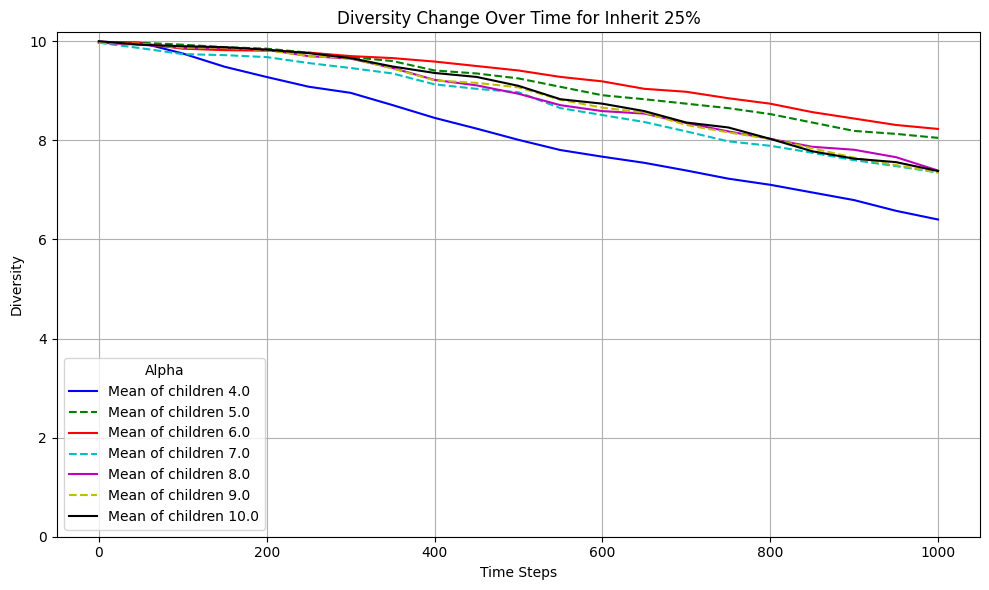

Skipping Inherit 50%, Mean of children 1.0 due to no data
Skipping Inherit 50%, Mean of children 2.0 due to no data
Skipping Inherit 50%, Mean of children 3.0 due to no data


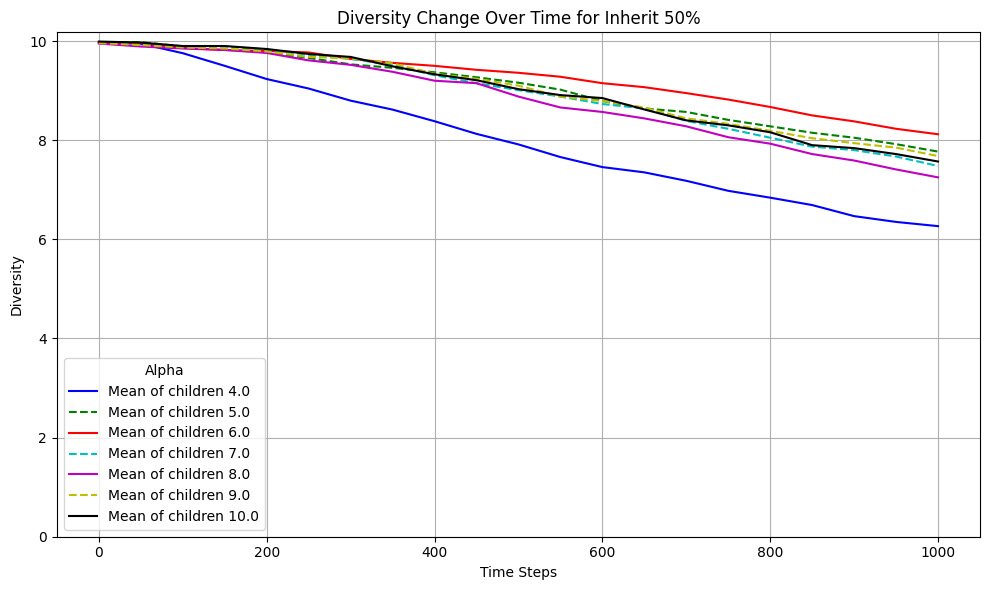

Skipping Inherit False%, Mean of children 1.0 due to no data
Skipping Inherit False%, Mean of children 2.0 due to no data
Skipping Inherit False%, Mean of children 3.0 due to no data


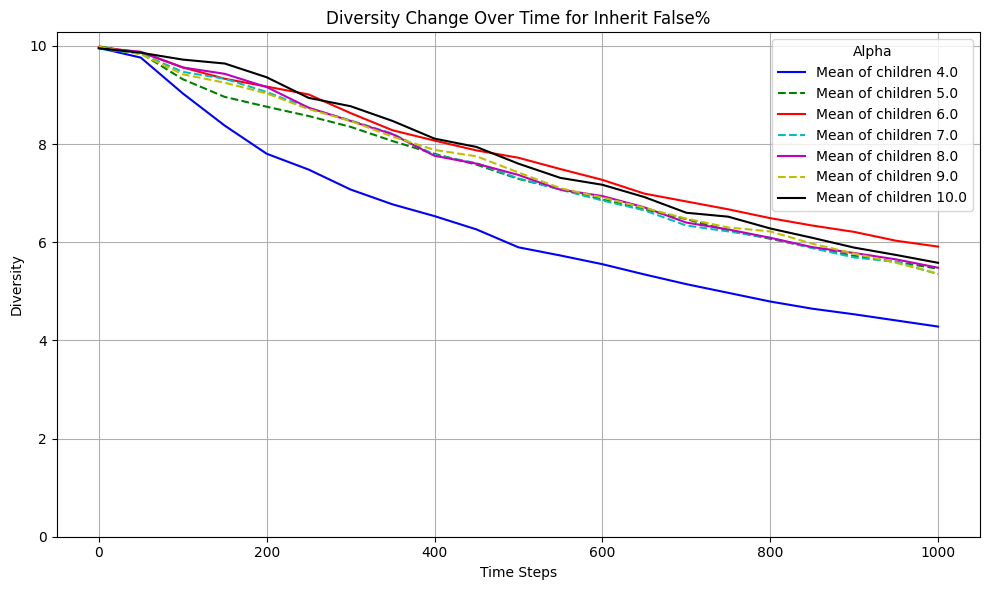

Skipping Inherit 0%, Mean of children 1.0 due to no data
Skipping Inherit 25%, Mean of children 1.0 due to no data
Skipping Inherit 50%, Mean of children 1.0 due to no data
Skipping Inherit False%, Mean of children 1.0 due to no data


C:\Users\jsolm\AppData\Local\Temp\ipykernel_4944\2807128713.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Inherit %")


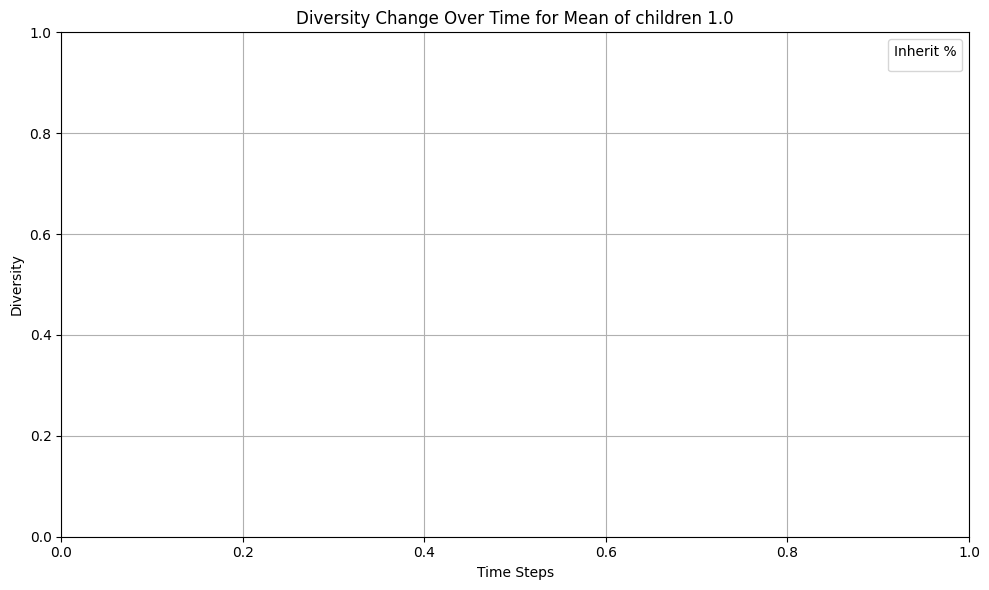

Skipping Inherit 0%, Mean of children 2.0 due to no data
Skipping Inherit 25%, Mean of children 2.0 due to no data
Skipping Inherit 50%, Mean of children 2.0 due to no data
Skipping Inherit False%, Mean of children 2.0 due to no data


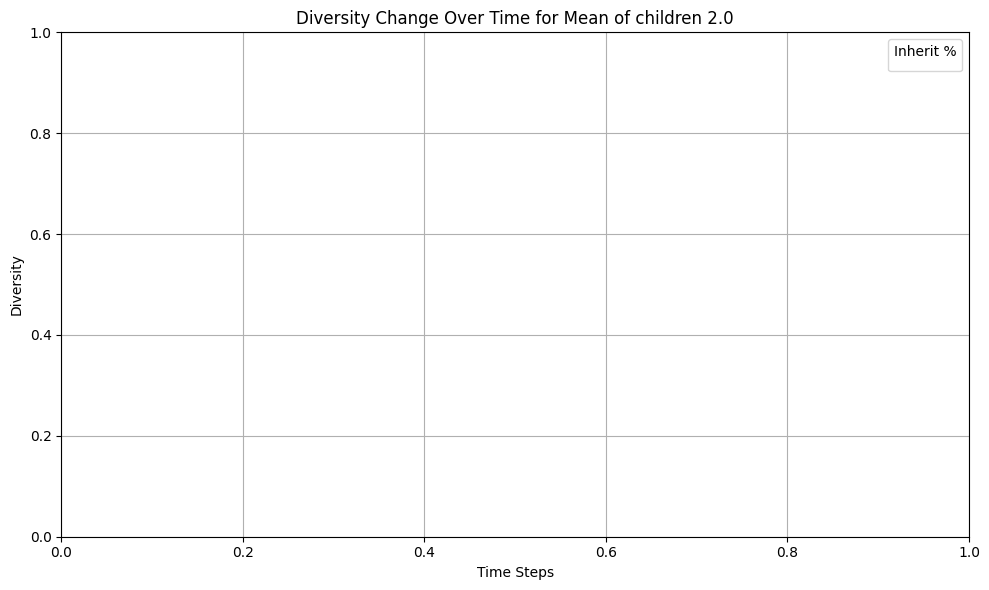

Skipping Inherit 0%, Mean of children 3.0 due to no data
Skipping Inherit 25%, Mean of children 3.0 due to no data
Skipping Inherit 50%, Mean of children 3.0 due to no data
Skipping Inherit False%, Mean of children 3.0 due to no data


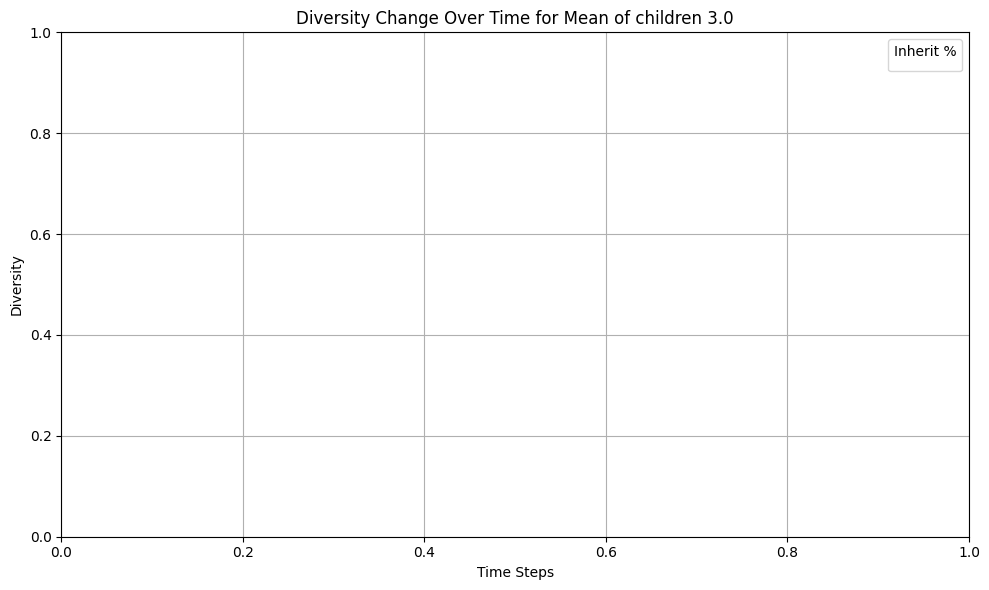

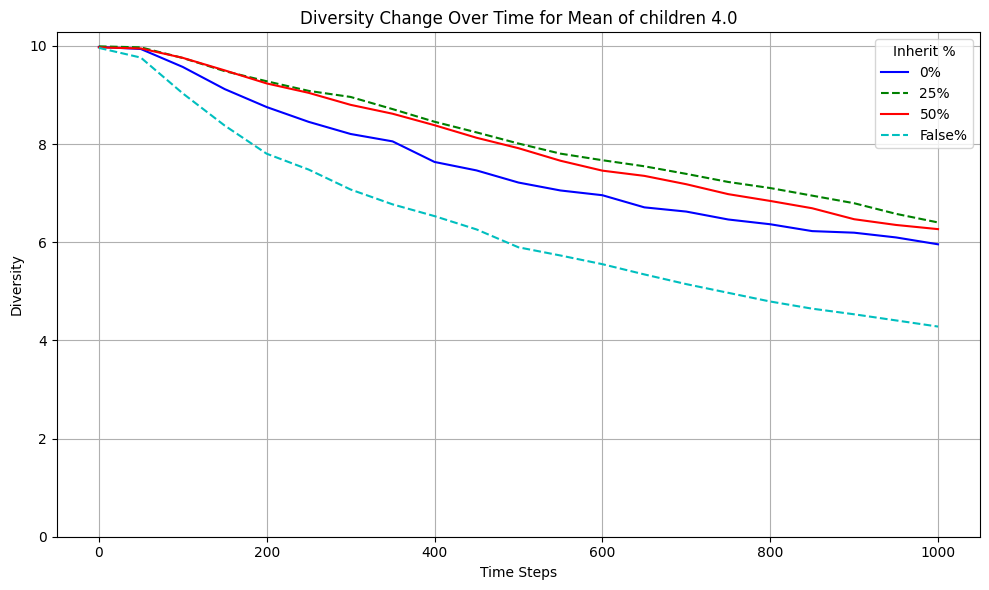

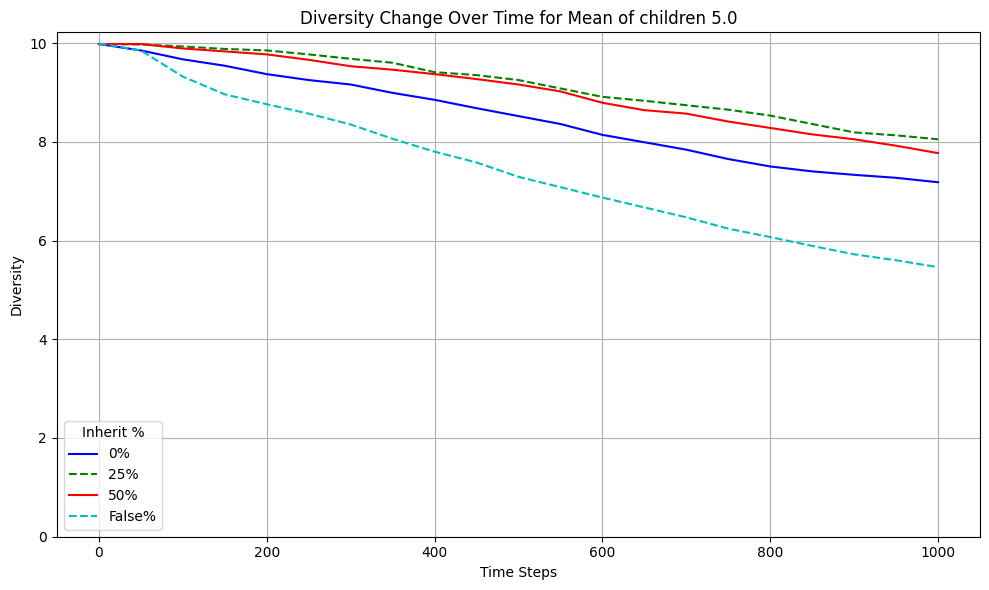

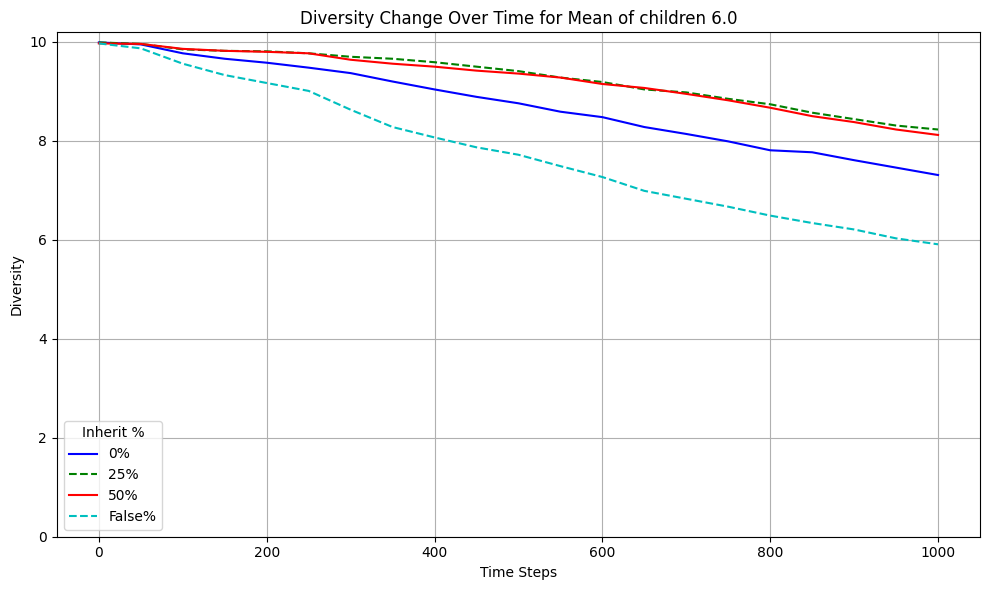

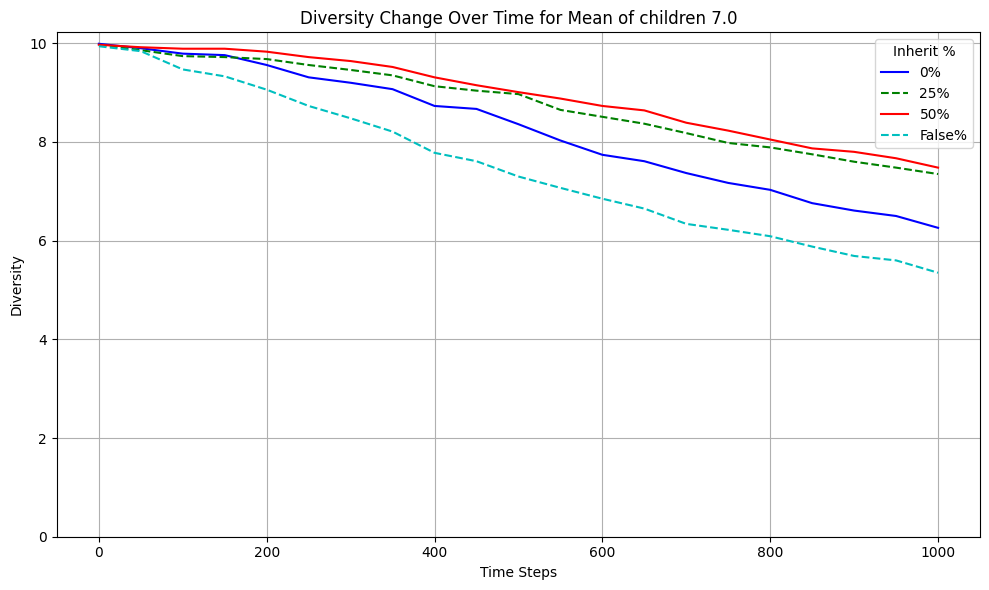

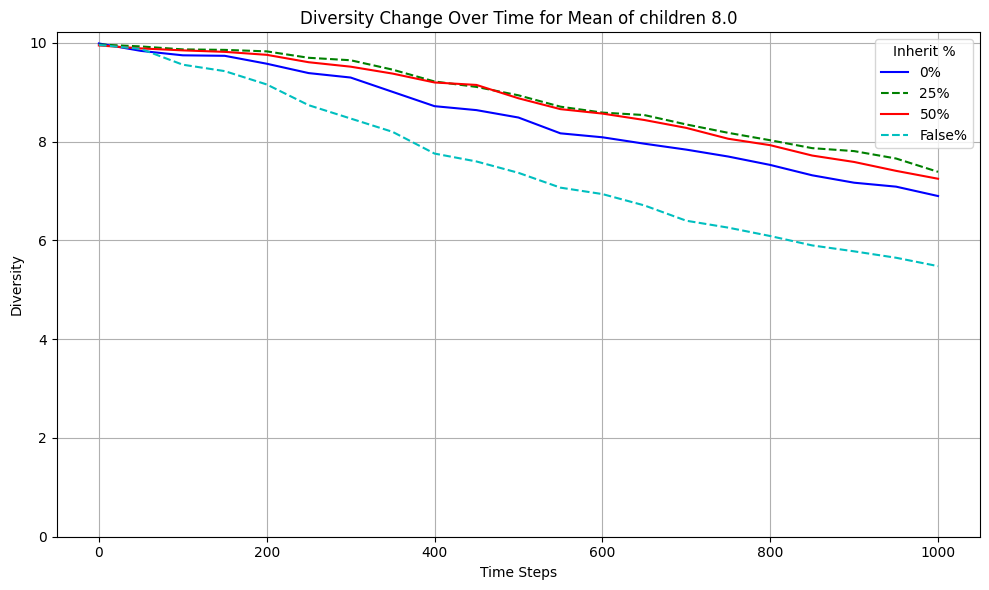

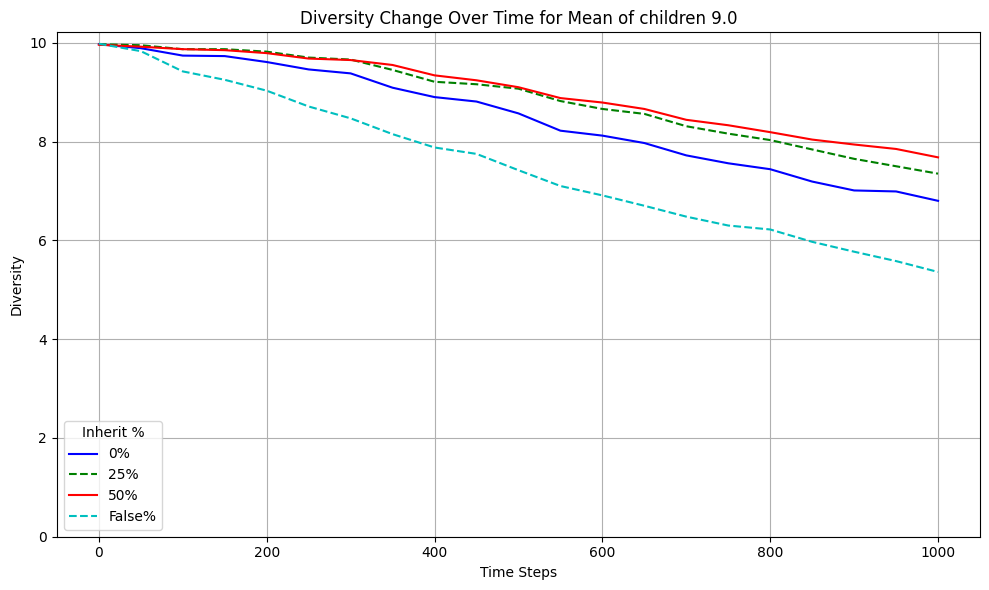

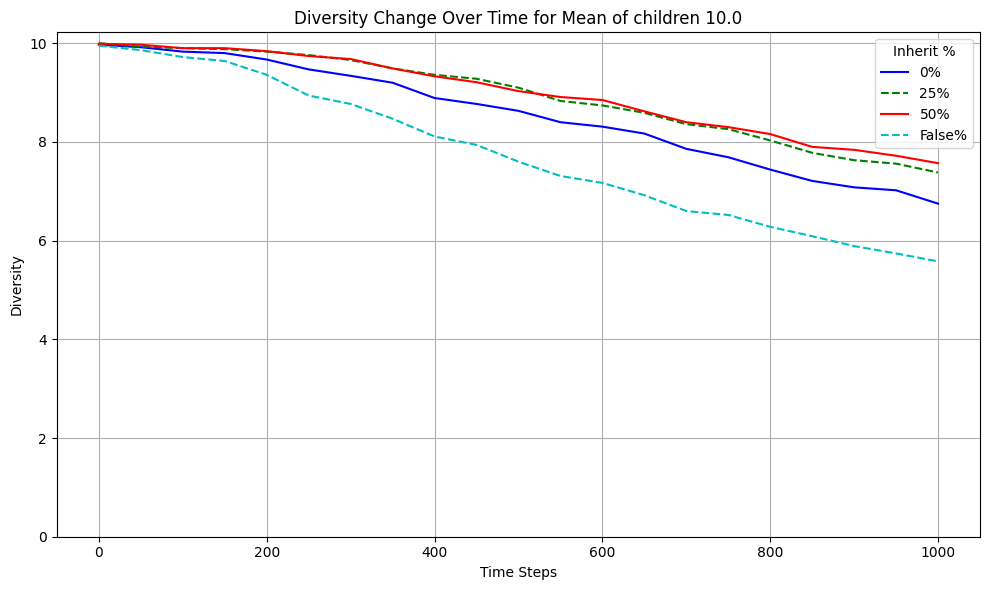

In [19]:
#heat_diversity_comm_level(EcM_datos, inherits, Ecalphas, 'Endogamy', variable='Mean of children')
#diversity_change_graphs(EcM_datos, inherits, Ecalphas, 'Endogamy', variable='Mean of children', limitant = True)
#diversity_change_by_row(EcM_datos, inherits, Ecalphas, 'Endogamy', variable='Mean of children', limitant=True)
#diversity_change_by_column(EcM_datos, inherits, Ecalphas, 'Endogamy', variable='Mean of children', limitant=True)
#plot_specific_graph(0, 3, EcM_datos, inherits, Ecalphas, 'Endogamy', variable='Mean of children', limitant = True)

In [ ]:
transversal_changes(EcM_datos, inherits, Ecalphas, 'Endogamy', variable='Mean of children')
transversal_alive(EcM_datos, inherits, Ecalphas, 'Endogamy', variable='Mean of children')

### Data and visualizations: population

In [ ]:
# heat_population(EcM_datos, inherits, Ecalphas, 'Endogamy', variable='Mean of children')
# heat_percentage_population(EcM_datos, inherits, Ecalphas, 'Endogamy', variable='Mean of children')
heat_stds(EcM_datos, inherits, Ecalphas, 'Endogamy', variable='Mean of children')

In [74]:
def heat_stds(matrix, inherits, alphas, kinship_system, variable = ''):
    # Heatmap population
    alive_values = np.array([[np.mean(matrix[i][j]['std']) for j in range(len(alphas))] for i in range(len(inherits))])
    fig, ax = plt.subplots(1, 1, figsize=(7, 5), facecolor="white")
    IM = ax.imshow(alive_values)
    cbar = fig.colorbar(IM, ax=ax, label="UDs")
    ax.set_xticks(np.arange(len(alphas)))
    ax.set_yticks(np.arange(len(inherits)))
    ax.set_xticklabels(alphas)
    ax.set_yticklabels(inherits)
    for i in range(len(inherits)):
        for j in range(len(alphas)):
            value = alive_values[i, j]
            bg_color = IM.cmap(IM.norm(value))
            brightness = (0.299 * bg_color[0] + 0.587 * bg_color[1] + 0.114 * bg_color[2])
            text_color = 'white' if brightness < 0.5 else 'black'
            ax.text(j, i, f'{value:.1f}', ha="center", va="center", color=text_color, fontsize=8)
    # Rotate x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Labels
    ax.set_ylabel("Inherit percentage")
    ax.set_xlabel(variable)
    plt.title(f"""
    {kinship_system}. Final population""")
    plt.tight_layout()
    plt.show()

## Mean varieties

In [ ]:
# This experiment has different values for Initial varieties mv
prob_morte = 0.06 #beta
media = 4 # Mean
m = 40
mv = 10
inherits = [0,25,50, 'False']
# inherits = [0,25,50] #Values for inherit
# inherits = [0, 'False'] #Values for inherit
Emvalphas = np.linspace(1,mv,mv)# Mean varieties from 1 to mv
# For data of behaviour
vM = np.empty((len(inherits), len(Emvalphas)), dtype=object) # alive, mean and diversity levels

punto_vista = 50
tiempo = 1000
tempo = list(range(0,tiempo+1,punto_vista))
experiments = 100
max_iterations = 200


print(vM.shape)
start = time.time()
print(f"started at:  {datetime.now()}")
for i, inherit in enumerate(inherits):
    for j, mvarieties  in enumerate(Emvalphas):
        star_configuration = time.time()
        #For population dynamics
        list_alive_UDs = []
        list_vivas_puntos_vista = []
        tasas_crecimiento = []
        #For diversity dynamics
        data_step_mean_var_ud = []
        data_step_var_system = []
        data_step_unique_system = []
        print(f"Experiments with inheritance {inherit} Initial UDs {m} and Mean varieties {mvarieties}")
        #Lists to store experiments' diversity data
        data_endo_mean_ud = []
        data_endo_com_level = []
        data_endo_total_varieties = []
        original_media = media
        #To see how frequent goes to extintion
        contador = 0
        iterations = 0
        while contador < experiments and iterations < max_iterations: 
        #for experiment in range(1, experiments+1):
            print(f'experimento {contador+1}')
            if inherit != 'False':
                
                #### Initialization
                UD_endogamy.uds = {}
                instancias_ud = []
                for id_ud in range(1, int(m) + 1):
                    instancias_ud.append(UD_endogamy(id_ud, media))
                ## Varieties
                limited_varieties = True
                if limited_varieties == False:
                    for id_ud, ud in UD_endogamy.uds.items():
                        for _ in range(3):
                            ud.varieties.append(Variety())
                else:
                    initial_varieties = [Variety() for _ in range (int(10))]
                    for ud in UD_endogamy.uds.values():
                        for _ in range(int(mvarieties)):
                            ud.varieties.append(random.choice(initial_varieties))   
                # Lists for graphs
                vivas_puntos_vista = [int(m)]
                vivas_tasa_crecimiento = [int(m)]
        #             mortas_puntos_vista = [0]
                #For diversity
                mean_var_ud = []
                var_system = []
                unique_system = []
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_endogamy.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                # Simulation
                for t in range(1, tiempo):
                    uds_copy = {id_ud: ud for id_ud, ud in UD_endogamy.uds.items() if ud.activa}
                    items = list(uds_copy.items())
                    random.shuffle(items)
                    uds_copy = dict(items)
                    alive = len(uds_copy)
                    if alive > 200 and (media == original_media):
                        media -= media//2
                        if media >= 4:
                            media = media //2
                    elif alive < 150 and media < original_media:
                        media = original_media
                    if not uds_copy: #Extintion
                        # Only 0
                        print(f"acabó en 0 el experimento {experiment} con herencia {inherits[i]} con unidades {Emvalphas[j]}")
                        break         
                    # Cycle:
                    for id_ud, ud in uds_copy.items():
                        ud.ter_filho()
                        ud.buscar_ud(uds_copy, int(media), inherit)
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
                    # Collecting data
                    vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                    if t % punto_vista == 0:
                        viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                        #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                        vivas_puntos_vista.append(viv)
                        # For diversity
                        var_ud = []
                        var_total = []
                        for ud in [ud for ud in UD_endogamy.uds.values() if ud.activa ==True]:
                            var_ud.append(len(ud.varieties))
                            for variety in ud.varieties:
                                var_total.append(variety.variety_id)
                        mean_var_ud.append(np.mean(var_ud))
                        var_system.append(len(var_total))
                        unique_system.append(len(set(var_total))) 
                viv = len([ud for id, ud in UD_endogamy.uds.items() if ud.activa])
                vivas_puntos_vista.append(viv)
                # For diversity
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_endogamy.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                alive = (len([ud for id, ud in uds_copy.items() if ud.activa]))
                if alive >= 1:   
                    total_varieties = []
                    varieties_per_UD = []
                    for ud in [ud for ud in UD_endogamy.uds.values() if ud.activa ==True]:
                        varieties_per_UD.append(len(ud.varieties))
                        for variety in ud.varieties:
                            total_varieties.append(variety.variety_id)
                    data_endo_mean_ud.append(np.mean(varieties_per_UD))
                    data_endo_com_level.append(len(set(total_varieties)))
                    data_endo_total_varieties.append(total_varieties)
            
            else:# Now with inherit == False
                #### Initialization
                UD_endogamy_al_inh.uds = {}
                instancias_ud = []
                for id_ud in range(1, int(m) + 1):
                    instancias_ud.append(UD_endogamy_al_inh(id_ud, media))
                ## Varieties
                limited_varieties = True
                if limited_varieties == False:
                    for id_ud, ud in UD_endogamy_al_inh.uds.items():
                        for _ in range(3):
                            ud.varieties.append(Variety())
                else:
                    initial_varieties = [Variety() for _ in range (int(10))]
                    for ud in UD_endogamy_al_inh.uds.values():
                        for _ in range(int(mvarieties)):
                            ud.varieties.append(random.choice(initial_varieties))   
                # Lists for graphs
                vivas_puntos_vista = [int(m)]
                vivas_tasa_crecimiento = [int(m)]
        #             mortas_puntos_vista = [0]
                #For diversity
                mean_var_ud = []
                var_system = []
                unique_system = []
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_endogamy_al_inh.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                # Simulation
                for t in range(1, tiempo):
                    uds_copy = {id_ud: ud for id_ud, ud in UD_endogamy_al_inh.uds.items() if ud.activa}
                    items = list(uds_copy.items())
                    random.shuffle(items)
                    uds_copy = dict(items)
                    alive = len(uds_copy)
                    if alive > 200 and (media == original_media):
                        media -= media//2
                        if media >= 4:
                            media = media //2
                    elif alive < 150 and media < original_media:
                        media = original_media
                    if not uds_copy: #Extintion
                        # Only 0
                        print(f"acabó en 0 el experimento {experiment} con herencia {inherits[i]} con unidades {Emvalphas[j]}")
                        break         
                    # Cycle:
                    varieties_list = [var for ud in uds_copy.values() for var in ud.varieties]
                    for id_ud, ud in uds_copy.items():
                        ud.ter_filho()
                        ud.buscar_ud(uds_copy, int(media), varieties_list, int(mvarieties))
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
                    # Collecting data
                    vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                    if t % punto_vista == 0:
                        viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                        #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                        vivas_puntos_vista.append(viv)
                        # For diversity
                        var_ud = []
                        var_total = []
                        for ud in [ud for ud in UD_endogamy_al_inh.uds.values() if ud.activa ==True]:
                            var_ud.append(len(ud.varieties))
                            for variety in ud.varieties:
                                var_total.append(variety.variety_id)
                        mean_var_ud.append(np.mean(var_ud))
                        var_system.append(len(var_total))
                        unique_system.append(len(set(var_total))) 
                viv = len([ud for id, ud in UD_endogamy_al_inh.uds.items() if ud.activa])
                vivas_puntos_vista.append(viv)
                # For diversity
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_endogamy_al_inh.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                alive = (len([ud for id, ud in uds_copy.items() if ud.activa]))
                if alive >= 1:   
                    total_varieties = []
                    varieties_per_UD = []
                    for ud in [ud for ud in UD_endogamy_al_inh.uds.values() if ud.activa ==True]:
                        varieties_per_UD.append(len(ud.varieties))
                        for variety in ud.varieties:
                            total_varieties.append(variety.variety_id)
                    data_endo_mean_ud.append(np.mean(varieties_per_UD))
                    data_endo_com_level.append(len(set(total_varieties)))
                    data_endo_total_varieties.append(total_varieties)
            
            
            # Final collection of the data after the simulation!
            if len(uds_copy) > 0:  # Only collect data if the system is alive
                list_alive_UDs.append(len([ud for id, ud in uds_copy.items() if ud.activa == True]))  # For heatmap
                list_vivas_puntos_vista.append(vivas_puntos_vista)
                data_step_var_system.append(var_system)
                data_step_unique_system.append(unique_system)
                data_step_mean_var_ud.append(mean_var_ud)
                contador += 1
            iterations += 1
            print('succesful', contador)
            print('iterations', iterations) 
            
            data_inherit_endo = [data_endo_mean_ud, data_endo_com_level, data_endo_total_varieties]
        data_steps_inherit_endo = [data_step_var_system, data_step_unique_system, data_step_mean_var_ud]
        media = original_media
        end_config = time.time()
        if contador == experiments:
            vM[i][j] = {
                'alive': np.mean(list_alive_UDs),
                'lstd': np.std(list_alive_UDs),
                'time used': end_config - star_configuration,
                'percentage_extinction': contador / experiments,
                'tempo': tempo, 
                'mean': np.mean(list_vivas_puntos_vista, axis=0), 
                'std': np.std(list_vivas_puntos_vista, axis=0),
                'growth rate': np.mean([np.mean(lista) for lista in tasas_crecimiento]),
                'diversity_info': data_inherit_endo,
                'diversity_info_steps': data_steps_inherit_endo,
            }
        else:  # Handle extinction-only scenarios
            vM[i][j] = {
                'alive': None,
                'lstd': None,
                'time used': end_config - star_configuration,
                'percentage_extinction': 1.0,  # All experiments went extinct
                'tempo': None, 
                'mean': None, 
                'std': None,
                'growth rate': None,
                'diversity_info': None,
                'diversity_info_steps': None,
            }
        print(f"""
The total time of the configuration of inherit percentage {inherit}, 
  initial UDs {m} and Mean varieties {mvarieties} is  {end_config - star_configuration}
        """)
# Folder
folder_name = 'Experiments_kinship_inheritance_parameters'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Heatmap and std
heat_std = os.path.join(folder_name, 'Endo_Initial_Mean_varieties.npy')
np.save(heat_std, vM)
now = datetime.now()
finish = time.time()
print(f"""
It finished at: {now}
It lasted {finish-start}
""")
print("done")

In [11]:
# Dowload the documents
#As a reference
mv = 10 # Mean
inherits = [0,25,50, 'False']
Emvalphas = np.linspace(1,mv,mv) # Mean of children from 1 to n
punto_vista = 50
tiempo = 1000
tempo = list(range(0,tiempo+1,punto_vista))

#Folders
folder_name = 'Experiments_kinship_inheritance_parameters'
heat_std = os.path.join(folder_name, 'Endo_Initial_Mean_varieties.npy')

## General Data
EmvM_datos = np.load(heat_std, allow_pickle=True)

### Diversity dynamics

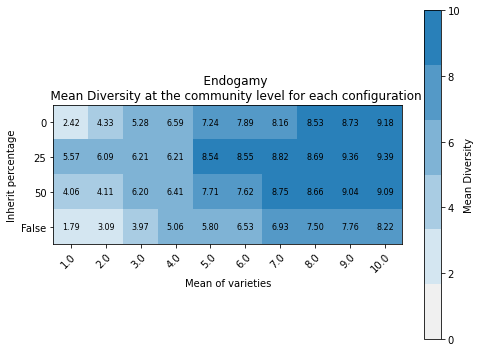

In [24]:
#heat_diversity_comm_level(EmvM_datos, inherits, Emvalphas, 'Endogamy', variable='Mean of varieties')
#diversity_change_graphs(EmvM_datos, inherits, Emvalphas, 'Endogamy', variable='Mean of varieties', limitant = True)
#diversity_change_by_row(EmvM_datos, inherits, Emvalphas, 'Endogamy', variable='Mean of varieties', limitant=True)
#diversity_change_by_column(EmvM_datos, inherits, Emvalphas, 'Endogamy', variable='Mean of varieties', limitant=True)
#plot_specific_graph(0, 1, EmvM_datos, inherits, Emvalphas, 'Endogamy', variable='Mean of varieties', limitant = True)

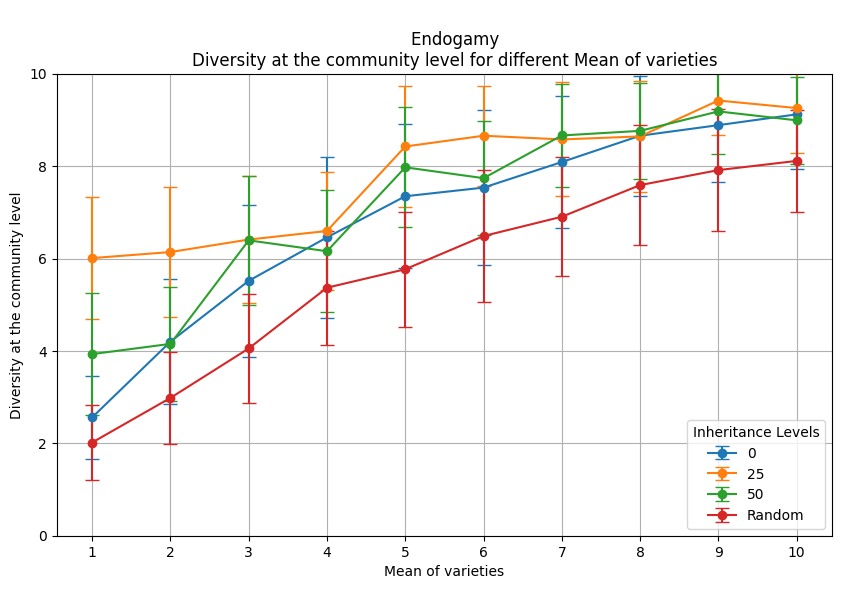

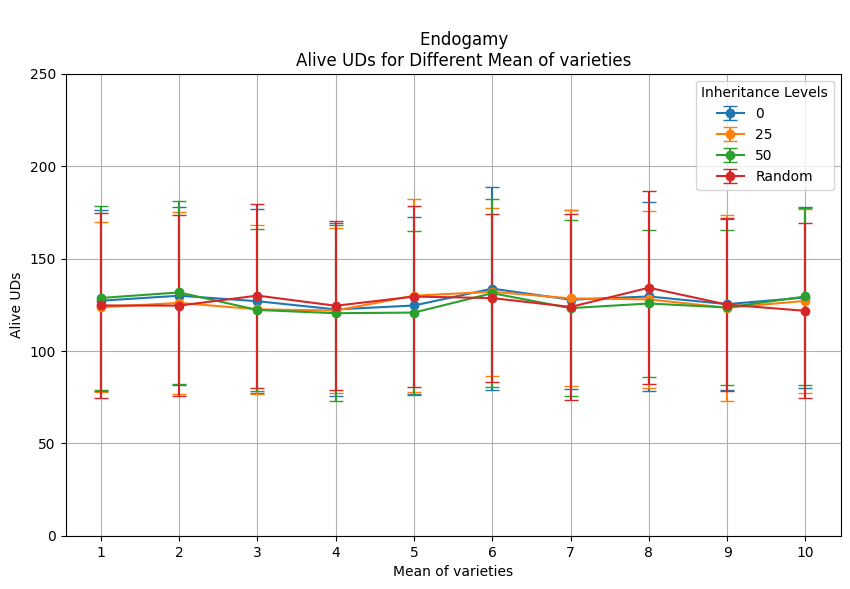

In [12]:
transversal_changes(EmvM_datos, inherits, Emvalphas, 'Endogamy', variable='Mean of varieties')
transversal_alive(EmvM_datos, inherits, Emvalphas, 'Endogamy', variable='Mean of varieties')

### Population dynamics

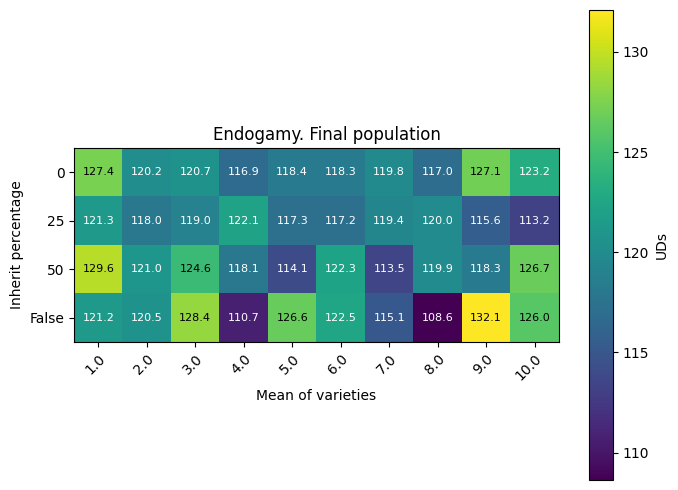

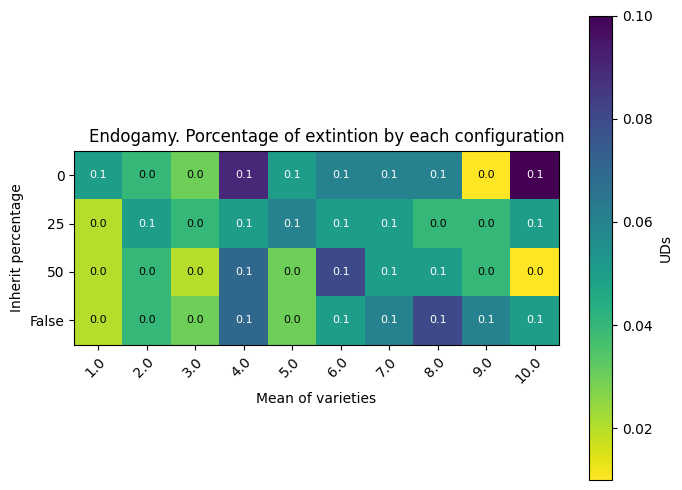

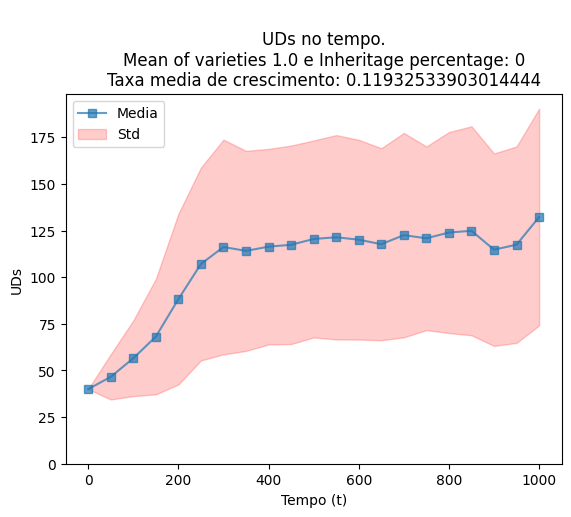

In [17]:
heat_population(EmvM_datos, inherits, Emvalphas, 'Endogamy', variable='Mean of varieties')

heat_percentage_population(EmvM_datos, inherits, Emvalphas, 'Endogamy', variable='Mean of varieties')

plot_specific_alivegraph(0, 0, EmvM_datos, inherits, Emvalphas, 'Endogamy', variable='Mean of varieties')

# Dual Organization

## Initial UDs

Here we experimento with Initial UDs. We try from 10 to 100

In [ ]:
# This experiment has different values for Initial UDs
prob_morte = 0.06 #beta
media = 4 # Mean
m = 100 # Initial UDs
inherits = [0,25,50, 'False']
# inherits = [0,25,50] #Values for inherit
# inherits = [0, 'False'] #Values for inherit
Dmalphas = np.linspace(10,m,int(m/10)) # Initial UDs: from 10 to m
# For data of behaviour
mM = np.empty((len(inherits), len(Dmalphas)), dtype=object) # alive, mean and diversity levels

punto_vista = 50
tiempo = 1000
tempo = list(range(0,tiempo+1,punto_vista))
experiments = 100
max_iterations = 400


print(mM.shape)
start = time.time()
print(f"started at:  {datetime.now()}")
for i, inherit in enumerate(inherits):
    for j, iniciais  in enumerate(Dmalphas):
        star_configuration = time.time()
        #For population dynamics
        list_alive_UDs = []
        list_vivas_puntos_vista = []
        tasas_crecimiento = []
        #For diversity dynamics
        data_step_mean_var_ud = []
        data_step_var_system = []
        data_step_unique_system = []
        print(f"Experiments with inheritance {inherit} and Initial UDs {iniciais}")
        #Lists to store experiments' diversity data
        data_endo_mean_ud = []
        data_endo_com_level = []
        data_endo_total_varieties = []
        original_media = media
        #To see how frequent goes to extintion
        contador = 0
        iterations = 0
        while contador < experiments and iterations < max_iterations: 
        #for experiment in range(1, experiments+1):
            print(f'experimento {contador+1}')
            ## Clans
            clans = (list(range(1, 2 + 1)) * (int(iniciais) // 2)) # Just 2 clans
            random.shuffle(clans)
            if inherit != 'False':          
                #### Initialization
                UD_dual_organization.uds = {}
                instancias_ud = []
                for id_ud in range(1, int(iniciais) + 1):
                    instancias_ud.append(UD_dual_organization(id_ud, media,clans.pop()))
                ## Varieties
                limited_varieties = True
                if limited_varieties == False:
                    for id_ud, ud in UD_dual_organization.uds.items():
                        for _ in range(3):
                            ud.varieties.append(Variety())
                else:
                    initial_varieties = [Variety() for _ in range (10)]
                    for ud in UD_dual_organization.uds.values():
                        for _ in range(3):
                            ud.varieties.append(random.choice(initial_varieties))   
                # Lists for graphs
                vivas_puntos_vista = [int(iniciais)]
                vivas_tasa_crecimiento = [int(iniciais)]
        #             mortas_puntos_vista = [0]
                #For diversity
                mean_var_ud = []
                var_system = []
                unique_system = []
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_dual_organization.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                # Simulation
                for t in range(1, tiempo):
                    uds_copy = {id_ud: ud for id_ud, ud in UD_dual_organization.uds.items() if ud.activa}
                    items = list(uds_copy.items())
                    random.shuffle(items)
                    uds_copy = dict(items)
                    alive = len(uds_copy)
                    if alive > 200 and (media == original_media):
                        media -= media//2
                        if media >= 4:
                            media = media //2
                    elif alive < 150 and media < original_media:
                        media = original_media
                    if not uds_copy: #Extintion
                        # Only 0
                        print(f"acabó en 0 el experimento {experiment} con herencia {inherits[i]} con unidades {Dmalphas[j]}")
                        break         
                    # Cycle:
                    for id_ud, ud in uds_copy.items():
                        ud.ter_filho()
                        ud.buscar_ud(uds_copy, int(media), inherit, True, 0.2)
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
                    # Collecting data
                    vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                    if t % punto_vista == 0:
                        viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                        #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                        vivas_puntos_vista.append(viv)
                        # For diversity
                        var_ud = []
                        var_total = []
                        for ud in [ud for ud in UD_dual_organization.uds.values() if ud.activa ==True]:
                            var_ud.append(len(ud.varieties))
                            for variety in ud.varieties:
                                var_total.append(variety.variety_id)
                        mean_var_ud.append(np.mean(var_ud))
                        var_system.append(len(var_total))
                        unique_system.append(len(set(var_total))) 
                viv = len([ud for id, ud in UD_dual_organization.uds.items() if ud.activa])
                vivas_puntos_vista.append(viv)
                # For diversity
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_dual_organization.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                alive = (len([ud for id, ud in uds_copy.items() if ud.activa]))
                if alive >= 1:   
                    total_varieties = []
                    varieties_per_UD = []
                    for ud in [ud for ud in UD_dual_organization.uds.values() if ud.activa ==True]:
                        varieties_per_UD.append(len(ud.varieties))
                        for variety in ud.varieties:
                            total_varieties.append(variety.variety_id)
                    data_endo_mean_ud.append(np.mean(varieties_per_UD))
                    data_endo_com_level.append(len(set(total_varieties)))
                    data_endo_total_varieties.append(total_varieties)
            
            else:# Now with inherit == False
                #### Initialization
                UD_dual_organization_al_inh.uds = {}
                instancias_ud = []
                for id_ud in range(1, int(iniciais) + 1):
                    instancias_ud.append(UD_dual_organization_al_inh(id_ud, media, clans.pop()))
                ## Varieties
                limited_varieties = True
                if limited_varieties == False:
                    for id_ud, ud in UD_dual_organization_al_inh.uds.items():
                        for _ in range(3):
                            ud.varieties.append(Variety())
                else:
                    initial_varieties = [Variety() for _ in range (10)]
                    for ud in UD_dual_organization_al_inh.uds.values():
                        for _ in range(3):
                            ud.varieties.append(random.choice(initial_varieties))   
                # Lists for graphs
                vivas_puntos_vista = [int(iniciais)]
                vivas_tasa_crecimiento = [int(iniciais)]
        #             mortas_puntos_vista = [0]
                #For diversity
                mean_var_ud = []
                var_system = []
                unique_system = []
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_dual_organization_al_inh.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                # Simulation
                for t in range(1, tiempo):
                    uds_copy = {id_ud: ud for id_ud, ud in UD_dual_organization_al_inh.uds.items() if ud.activa}
                    items = list(uds_copy.items())
                    random.shuffle(items)
                    uds_copy = dict(items)
                    alive = len(uds_copy)
                    if alive > 200 and (media == original_media):
                        media -= media//2
                        if media >= 4:
                            media = media //2
                    elif alive < 150 and media < original_media:
                        media = original_media
                    if not uds_copy: #Extintion
                        # Only 0
                        print(f"acabó en 0 el experimento {experiment} con herencia {inherits[i]} con unidades {Dmalphas[j]}")
                        break         
                    # Cycle:
                    varieties_list = [var for ud in uds_copy.values() for var in ud.varieties]
                    for id_ud, ud in uds_copy.items():
                        ud.ter_filho()
                        ud.buscar_ud(uds_copy, int(media), varieties_list, True, 3, 0.2)
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
                    # Collecting data
                    vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                    if t % punto_vista == 0:
                        viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                        #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                        vivas_puntos_vista.append(viv)
                        # For diversity
                        var_ud = []
                        var_total = []
                        for ud in [ud for ud in UD_dual_organization_al_inh.uds.values() if ud.activa ==True]:
                            var_ud.append(len(ud.varieties))
                            for variety in ud.varieties:
                                var_total.append(variety.variety_id)
                        mean_var_ud.append(np.mean(var_ud))
                        var_system.append(len(var_total))
                        unique_system.append(len(set(var_total))) 
                viv = len([ud for id, ud in UD_dual_organization_al_inh.uds.items() if ud.activa])
                vivas_puntos_vista.append(viv)
                # For diversity
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_dual_organization_al_inh.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                alive = (len([ud for id, ud in uds_copy.items() if ud.activa]))
                if alive >= 1:   
                    total_varieties = []
                    varieties_per_UD = []
                    for ud in [ud for ud in UD_dual_organization_al_inh.uds.values() if ud.activa ==True]:
                        varieties_per_UD.append(len(ud.varieties))
                        for variety in ud.varieties:
                            total_varieties.append(variety.variety_id)
                    data_endo_mean_ud.append(np.mean(varieties_per_UD))
                    data_endo_com_level.append(len(set(total_varieties)))
                    data_endo_total_varieties.append(total_varieties)
            
            
            # Final collection of the data after the simulation!
            if len(uds_copy) > 0:  # Only collect data if the system is alive
                list_alive_UDs.append(len([ud for id, ud in uds_copy.items() if ud.activa == True]))  # For heatmap
                list_vivas_puntos_vista.append(vivas_puntos_vista)
                data_step_var_system.append(var_system)
                data_step_unique_system.append(unique_system)
                data_step_mean_var_ud.append(mean_var_ud)
                contador += 1
            iterations += 1
            print('succesful', contador)
            print('iterations', iterations)   
            
            data_inherit_endo = [data_endo_mean_ud, data_endo_com_level, data_endo_total_varieties]
        data_steps_inherit_endo = [data_step_var_system, data_step_unique_system, data_step_mean_var_ud]
        media = original_media
        end_config = time.time()
        if contador == experiments:
            mM[i][j] = {
                'alive': np.mean(list_alive_UDs),
                'lstd': np.std(list_alive_UDs),
                'time used': end_config - star_configuration,
                'percentage_extinction': contador / experiments,
                'tempo': tempo, 
                'mean': np.mean(list_vivas_puntos_vista, axis=0), 
                'std': np.std(list_vivas_puntos_vista, axis=0),
                'growth rate': np.mean([np.mean(lista) for lista in tasas_crecimiento]),
                'diversity_info': data_inherit_endo,
                'diversity_info_steps': data_steps_inherit_endo,
            }
        else:  # Handle extinction-only scenarios
            mM[i][j] = {
                'alive': None,
                'lstd': None,
                'time used': end_config - star_configuration,
                'percentage_extinction': 1.0,  # All experiments went extinct
                'tempo': None, 
                'mean': None, 
                'std': None,
                'growth rate': None,
                'diversity_info': None,
                'diversity_info_steps': None,
            }
        print(f"""
The total time of the configuration of inherit percentage {inherit} and initial UDs {iniciais} is  {end_config - star_configuration}
        """)
# Folder
folder_name = 'Experiments_kinship_inheritance_parameters'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Data
heat_std = os.path.join(folder_name, 'Dual_Initial_UDs.npy')
np.save(heat_std, mM)
now = datetime.now()
finish = time.time()
print(f"""
It finished at: {now}
It lasted {finish-start}
""")
print("done")

In [13]:
# Dowload the documents
#As a reference
m = 100
inherits = [0,25,50, 'False']#Values for inherit
# inherits = [0, 'False'] #Values for inherit
Dmalphas = np.linspace(10,m,int(m/10)) # Initial UDs: from 10 to m
punto_vista = 50
tiempo = 1000
tempo = list(range(0,tiempo+1,punto_vista))

#Folders
folder_name = 'Experiments_kinship_inheritance_parameters'
heat_std = os.path.join(folder_name, 'Dual_Initial_UDs.npy')

## General Data
DmM_datos = np.load(heat_std, allow_pickle=True)

## Data and visualizations: diversity

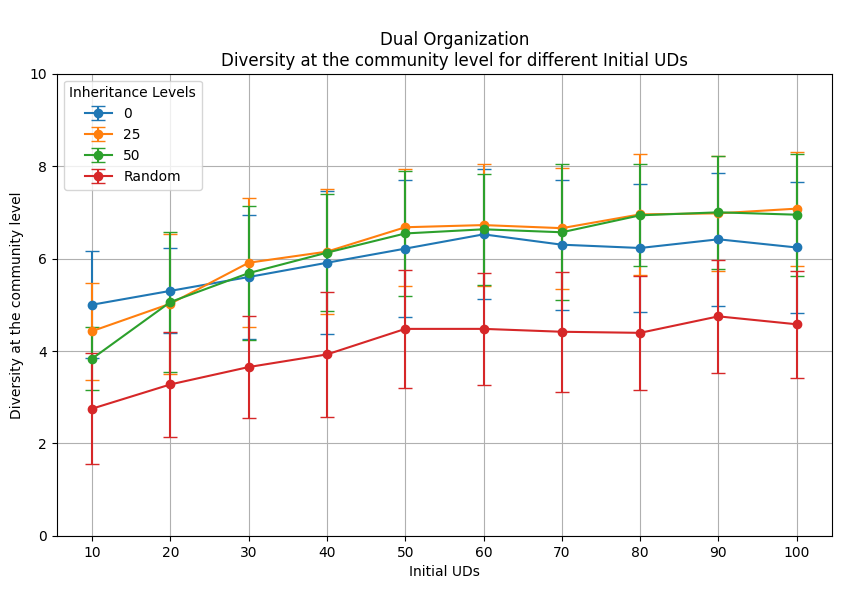

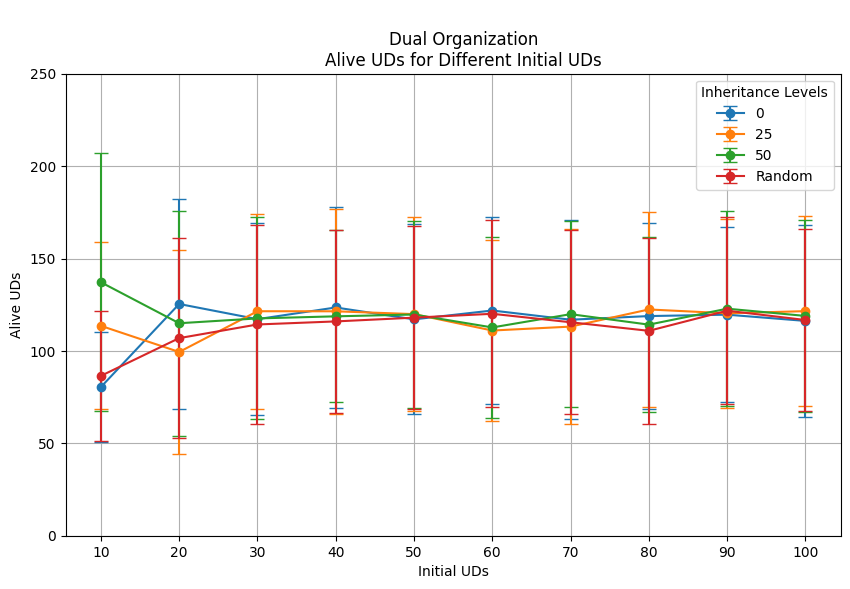

In [14]:
transversal_changes(DmM_datos, inherits, Dmalphas, 'Dual Organization', variable='Initial UDs')
transversal_alive(DmM_datos, inherits, Dmalphas, 'Dual Organization', variable='Initial UDs')

## Data and visualizations: pop

In [ ]:
heat_population(DmM_datos, inherits, Dmalphas, 'Dual Organization', variable='Initial UDs')

heat_percentage_population(DmM_datos, inherits, Dmalphas, 'Dual Organization', variable='Initial UDs')

heat_std(DmM_datos, inherits, Dmalphas, 'Dual Organization', variable = 'Initial UDs')

## Initial Varieties

Here we try with different values for the initial varieties in the system.
We go from 10 to 100.

In [ ]:
# This experiment has different values for Initial varieties VVVV
prob_morte = 0.06 #beta
media = 4 # Mean
iniciais = 40
v = 100 # Initial varieties
inherits = [0,25,50, 'False']
# inherits = [0,25,50] #Values for inherit
# inherits = [0, 'False'] #Values for inherit
Dvalphas = np.linspace(10,v,int(v/10)) # Initial Varieties: from 10 to v
# For data of behaviour
vM = np.empty((len(inherits), len(Dvalphas)), dtype=object) # alive, mean and diversity levels

punto_vista = 50
tiempo = 1000
tempo = list(range(0,tiempo+1,punto_vista))
experiments = 1000
max_iterations = 400


print(vM.shape)
start = time.time()
print(f"started at:  {datetime.now()}")
for i, inherit in enumerate(inherits):
    for j, varieties  in enumerate(Dvalphas):
        star_configuration = time.time()
        #For population dynamics
        list_alive_UDs = []
        list_vivas_puntos_vista = []
        tasas_crecimiento = []
        #For diversity dynamics
        data_step_mean_var_ud = []
        data_step_var_system = []
        data_step_unique_system = []
        print(f"Experiments with inheritance {inherit} Initial UDs {iniciais} and Initial varieties {varieties}")
        #Lists to store experiments' diversity data
        data_endo_mean_ud = []
        data_endo_com_level = []
        data_endo_total_varieties = []
        original_media = media
        #To see how frequent goes to extintion
        contador = 0
        iterations = 0
        while contador < experiments and iterations < max_iterations: 
        #for experiment in range(1, experiments+1):
            print(f'experimento {contador+1}')
            ## Clans
            clans = (list(range(1, 2 + 1)) * (int(iniciais) // 2)) # Just 2 clans
            random.shuffle(clans)
            if inherit != 'False':    
                #### Initialization
                UD_dual_organization.uds = {}
                instancias_ud = []
                for id_ud in range(1, int(iniciais) + 1):
                    instancias_ud.append(UD_dual_organization(id_ud, media, clans.pop()))
                ## Varieties
                limited_varieties = True
                if limited_varieties == False:
                    for id_ud, ud in UD_dual_organization.uds.items():
                        for _ in range(3):
                            ud.varieties.append(Variety())
                else:
                    initial_varieties = [Variety() for _ in range (int(varieties))]
                    for ud in UD_dual_organization.uds.values():
                        for _ in range(3):
                            ud.varieties.append(random.choice(initial_varieties))   
                # Lists for graphs
                vivas_puntos_vista = [int(iniciais)]
                vivas_tasa_crecimiento = [int(iniciais)]
        #             mortas_puntos_vista = [0]
                #For diversity
                mean_var_ud = []
                var_system = []
                unique_system = []
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_dual_organization.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                # Simulation
                for t in range(1, tiempo):
                    uds_copy = {id_ud: ud for id_ud, ud in UD_dual_organization.uds.items() if ud.activa}
                    items = list(uds_copy.items())
                    random.shuffle(items)
                    uds_copy = dict(items)
                    alive = len(uds_copy)
                    if alive > 200 and (media == original_media):
                        media -= media//2
                        if media >= 4:
                            media = media //2
                    elif alive < 150 and media < original_media:
                        media = original_media
                    if not uds_copy: #Extintion
                        # Only 0
                        print(f"acabó en 0 el experimento {experiment} con herencia {inherits[i]} con unidades {Dvalphas[j]}")
                        break         
                    # Cycle:
                    for id_ud, ud in uds_copy.items():
                        ud.ter_filho()
                        ud.buscar_ud(uds_copy, int(media), inherit, True, 0.2)
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
                    # Collecting data
                    vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                    if t % punto_vista == 0:
                        viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                        #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                        vivas_puntos_vista.append(viv)
                        # For diversity
                        var_ud = []
                        var_total = []
                        for ud in [ud for ud in UD_dual_organization.uds.values() if ud.activa ==True]:
                            var_ud.append(len(ud.varieties))
                            for variety in ud.varieties:
                                var_total.append(variety.variety_id)
                        mean_var_ud.append(np.mean(var_ud))
                        var_system.append(len(var_total))
                        unique_system.append(len(set(var_total))) 
                viv = len([ud for id, ud in UD_dual_organization.uds.items() if ud.activa])
                vivas_puntos_vista.append(viv)
                # For diversity
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_dual_organization.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                alive = (len([ud for id, ud in uds_copy.items() if ud.activa]))
                if alive >= 1:   
                    total_varieties = []
                    varieties_per_UD = []
                    for ud in [ud for ud in UD_dual_organization.uds.values() if ud.activa ==True]:
                        varieties_per_UD.append(len(ud.varieties))
                        for variety in ud.varieties:
                            total_varieties.append(variety.variety_id)
                    data_endo_mean_ud.append(np.mean(varieties_per_UD))
                    data_endo_com_level.append(len(set(total_varieties)))
                    data_endo_total_varieties.append(total_varieties)
            
            else:# Now with inherit == False
                #### Initialization
                UD_dual_organization_al_inh.uds = {}
                instancias_ud = []
                for id_ud in range(1, int(iniciais) + 1):
                    instancias_ud.append(UD_dual_organization_al_inh(id_ud, media, clans.pop()))
                ## Varieties
                limited_varieties = True
                if limited_varieties == False:
                    for id_ud, ud in UD_dual_organization_al_inh.uds.items():
                        for _ in range(3):
                            ud.varieties.append(Variety())
                else:
                    initial_varieties = [Variety() for _ in range (int(varieties))]
                    for ud in UD_dual_organization_al_inh.uds.values():
                        for _ in range(3):
                            ud.varieties.append(random.choice(initial_varieties))   
                # Lists for graphs
                vivas_puntos_vista = [int(iniciais)]
                vivas_tasa_crecimiento = [int(iniciais)]
        #             mortas_puntos_vista = [0]
                #For diversity
                mean_var_ud = []
                var_system = []
                unique_system = []
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_dual_organization_al_inh.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                # Simulation
                for t in range(1, tiempo):
                    uds_copy = {id_ud: ud for id_ud, ud in UD_dual_organization_al_inh.uds.items() if ud.activa}
                    items = list(uds_copy.items())
                    random.shuffle(items)
                    uds_copy = dict(items)
                    alive = len(uds_copy)
                    if alive > 200 and (media == original_media):
                        media -= media//2
                        if media >= 4:
                            media = media //2
                    elif alive < 150 and media < original_media:
                        media = original_media
                    if not uds_copy: #Extintion
                        # Only 0
                        print(f"acabó en 0 el experimento {experiment} con herencia {inherits[i]} con unidades {Dvalphas[j]}")
                        break         
                    # Cycle:
                    varieties_list = [var for ud in uds_copy.values() for var in ud.varieties]
                    for id_ud, ud in uds_copy.items():
                        ud.ter_filho()
                        ud.buscar_ud(uds_copy, int(media), varieties_list, True, 3, 0.2)
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
                    # Collecting data
                    vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                    if t % punto_vista == 0:
                        viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                        #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                        vivas_puntos_vista.append(viv)
                        # For diversity
                        var_ud = []
                        var_total = []
                        for ud in [ud for ud in UD_dual_organization_al_inh.uds.values() if ud.activa ==True]:
                            var_ud.append(len(ud.varieties))
                            for variety in ud.varieties:
                                var_total.append(variety.variety_id)
                        mean_var_ud.append(np.mean(var_ud))
                        var_system.append(len(var_total))
                        unique_system.append(len(set(var_total))) 
                viv = len([ud for id, ud in UD_dual_organization_al_inh.uds.items() if ud.activa])
                vivas_puntos_vista.append(viv)
                # For diversity
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_dual_organization_al_inh.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                alive = (len([ud for id, ud in uds_copy.items() if ud.activa]))
                if alive >= 1:   
                    total_varieties = []
                    varieties_per_UD = []
                    for ud in [ud for ud in UD_dual_organization_al_inh.uds.values() if ud.activa ==True]:
                        varieties_per_UD.append(len(ud.varieties))
                        for variety in ud.varieties:
                            total_varieties.append(variety.variety_id)
                    data_endo_mean_ud.append(np.mean(varieties_per_UD))
                    data_endo_com_level.append(len(set(total_varieties)))
                    data_endo_total_varieties.append(total_varieties)
            
            
            # Final collection of the data after the simulation!
            if len(uds_copy) > 0:  # Only collect data if the system is alive
                list_alive_UDs.append(len([ud for id, ud in uds_copy.items() if ud.activa == True]))  # For heatmap
                list_vivas_puntos_vista.append(vivas_puntos_vista)
                data_step_var_system.append(var_system)
                data_step_unique_system.append(unique_system)
                data_step_mean_var_ud.append(mean_var_ud)
                contador += 1
            iterations += 1
            print('succesful', contador)
            print('iterations', iterations)
            
            data_inherit_endo = [data_endo_mean_ud, data_endo_com_level, data_endo_total_varieties]
        data_steps_inherit_endo = [data_step_var_system, data_step_unique_system, data_step_mean_var_ud]
        media = original_media
        end_config = time.time()
        if contador == experiments:
            vM[i][j] = {
                'alive': np.mean(list_alive_UDs),
                'lstd': np.std(list_alive_UDs),
                'time used': end_config - star_configuration,
                'percentage_extinction': contador / experiments,
                'tempo': tempo, 
                'mean': np.mean(list_vivas_puntos_vista, axis=0), 
                'std': np.std(list_vivas_puntos_vista, axis=0),
                'growth rate': np.mean([np.mean(lista) for lista in tasas_crecimiento]),
                'diversity_info': data_inherit_endo,
                'diversity_info_steps': data_steps_inherit_endo,
            }
        else:  # Handle extinction-only scenarios
            vM[i][j] = {
                'alive': None,
                'lstd': None,
                'time used': end_config - star_configuration,
                'percentage_extinction': 1.0,  # All experiments went extinct
                'tempo': None, 
                'mean': None, 
                'std': None,
                'growth rate': None,
                'diversity_info': None,
                'diversity_info_steps': None,
            }
        print(f"""
The total time of the configuration of inherit percentage {inherit}, 
  initial UDs {iniciais} and Initial varieties {varieties} is  {end_config - star_configuration}
        """)
# Folder
folder_name = 'Experiments_kinship_inheritance_parameters'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Heatmap and std
heat_std = os.path.join(folder_name, 'Dual_Initial_Varieties.npy')
np.save(heat_std, vM)
now = datetime.now()
finish = time.time()
print(f"""
It finished at: {now}
It lasted {finish-start}
""")
print("done")

In [15]:
# Dowload the documents
#As a reference
v = 100
inherits = [0,25,50, 'False']#Values for inherit
# inherits = [0, 'False'] #Values for inherit
Dvalphas = np.linspace(10,v,int(v/10)) # Initial UDs: from 10 to m
punto_vista = 50
tiempo = 1000
tempo = list(range(0,tiempo+1,punto_vista))

#Folders
folder_name = 'Experiments_kinship_inheritance_parameters'
heat_std = os.path.join(folder_name, 'Dual_Initial_Varieties.npy')
## heatmap and mean
DvM_datos = np.load(heat_std, allow_pickle=True)

## Diversity dynamics

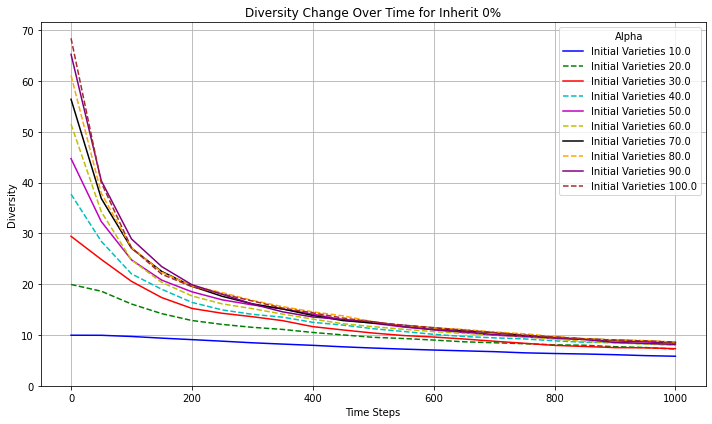

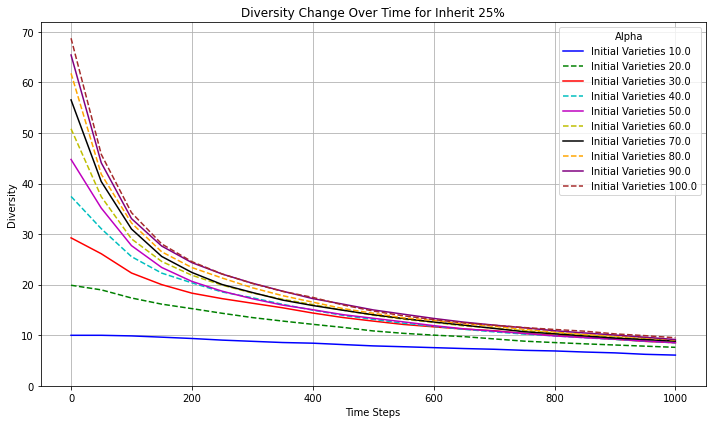

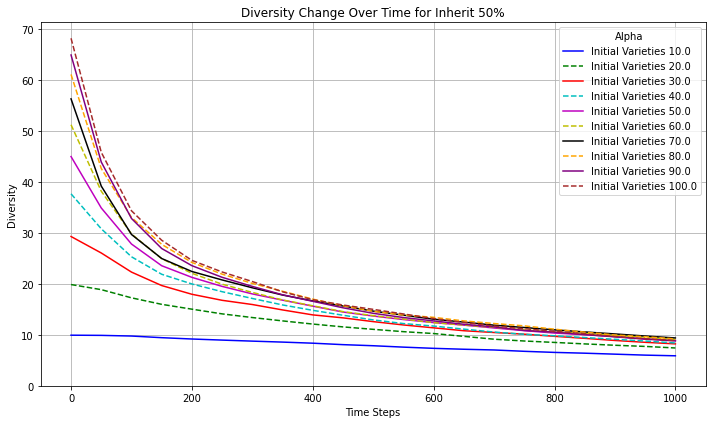

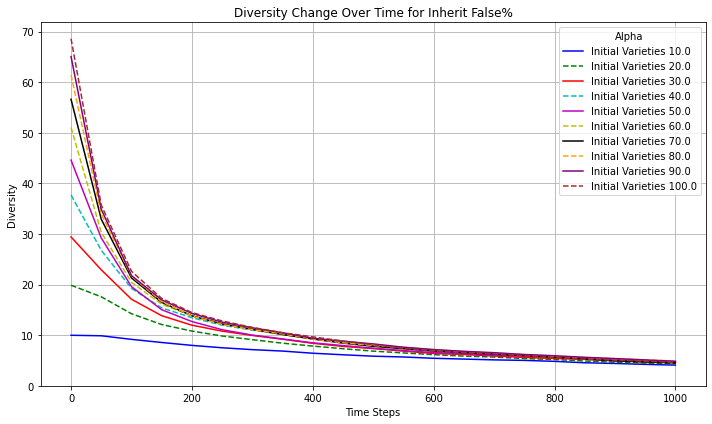

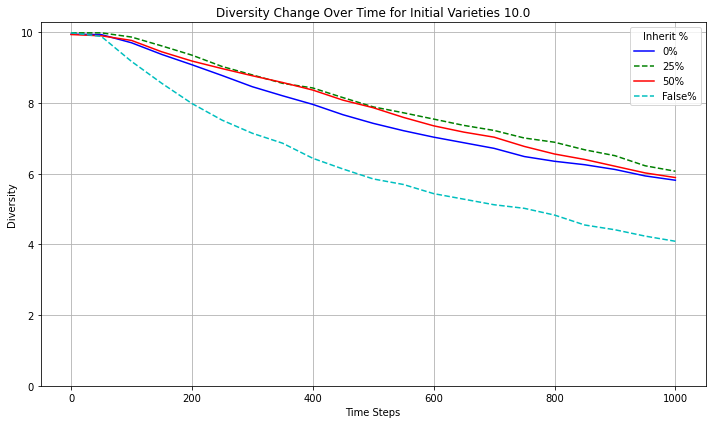

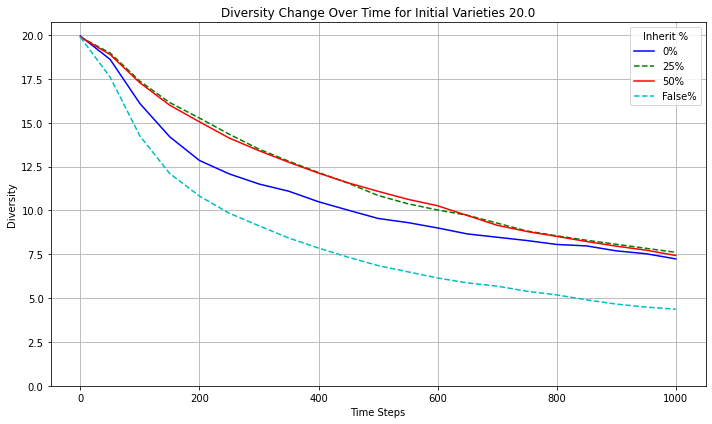

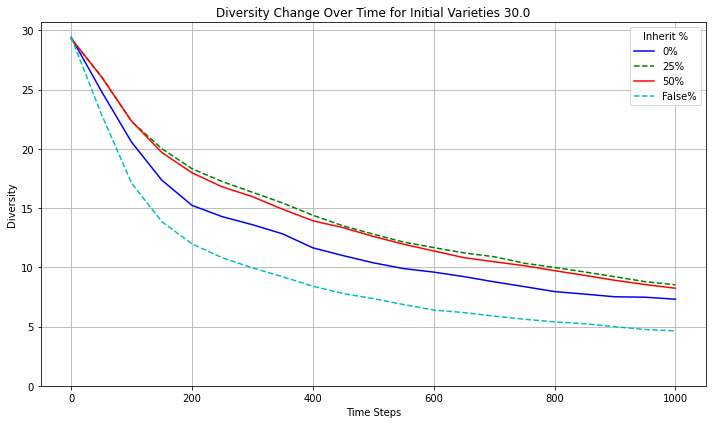

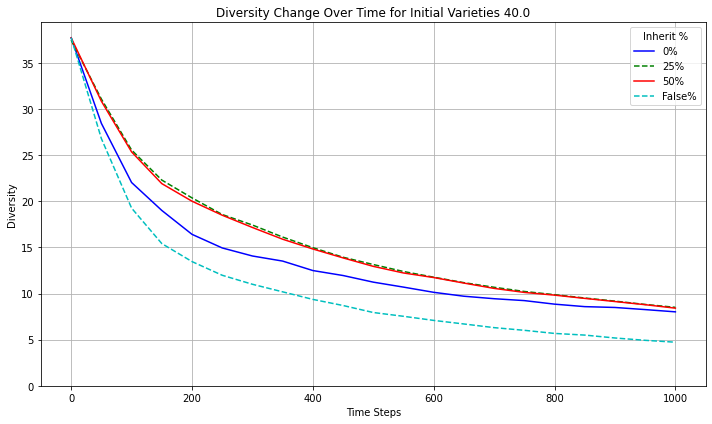

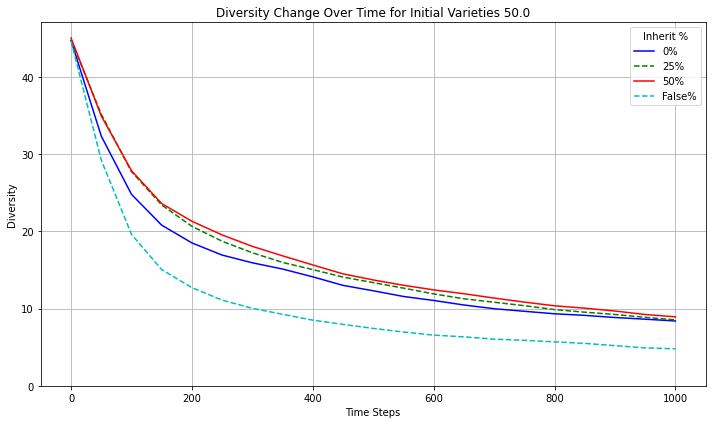

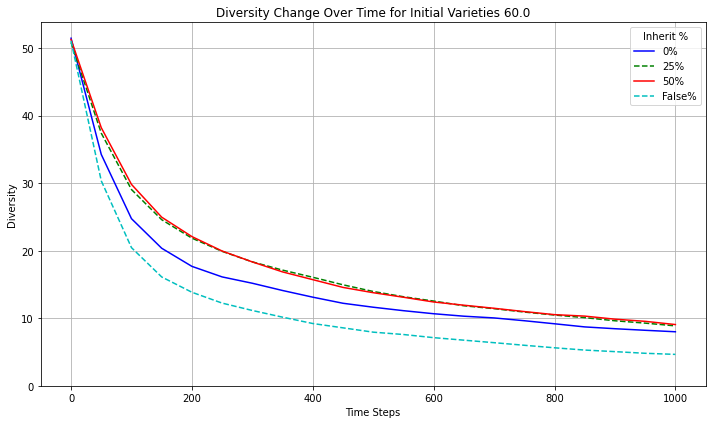

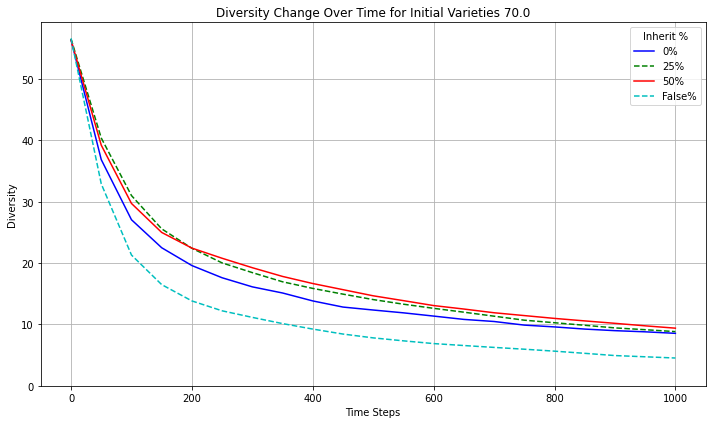

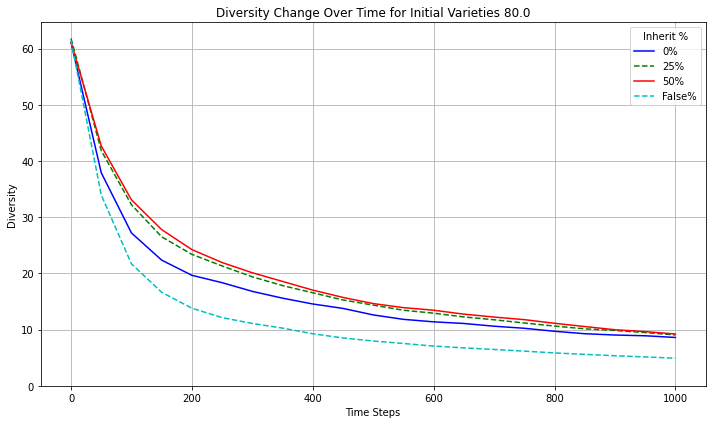

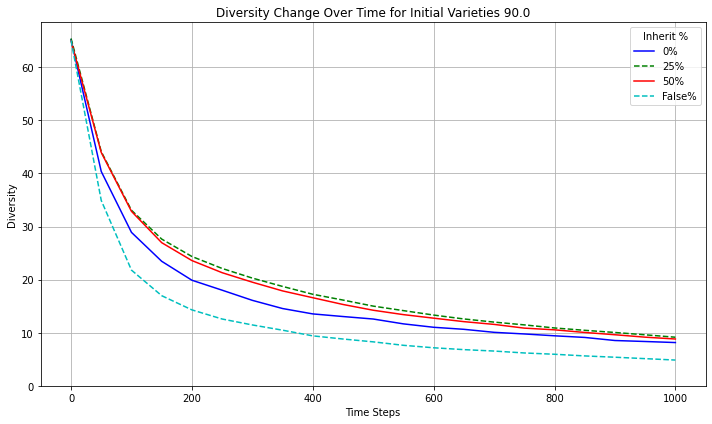

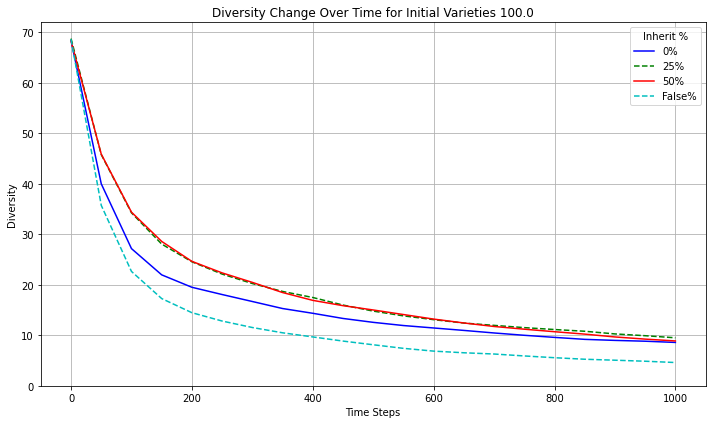

In [36]:
#heat_diversity_comm_level(DvM_datos, inherits, Dvalphas, 'Dual Organization', variable='Initial Varieties')
#diversity_change_graphs(DvM_datos, inherits, Dvalphas, 'Dual Organization', variable='Initial Varieties', limitant = True)
#diversity_change_by_row(DvM_datos, inherits, Dvalphas, 'Dual Organization', variable='Initial Varieties', limitant=True)
#diversity_change_by_column(DvM_datos, inherits, Dvalphas, 'Dual Organization', variable='Initial Varieties', limitant=True)
#plot_specific_graph(1, 1, DvM_datos, inherits, Dvalphas, 'Dual Organization', variable='Initial Varieties', limitant = True)


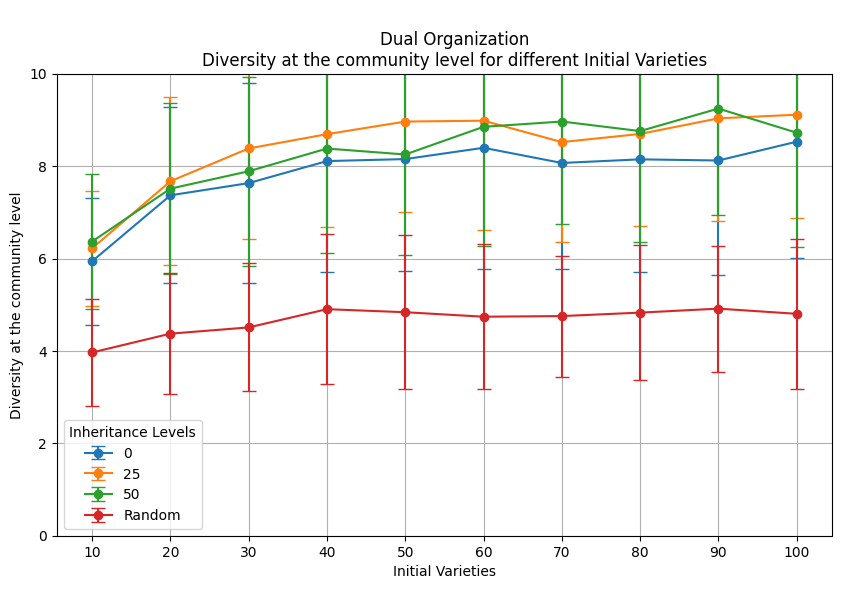

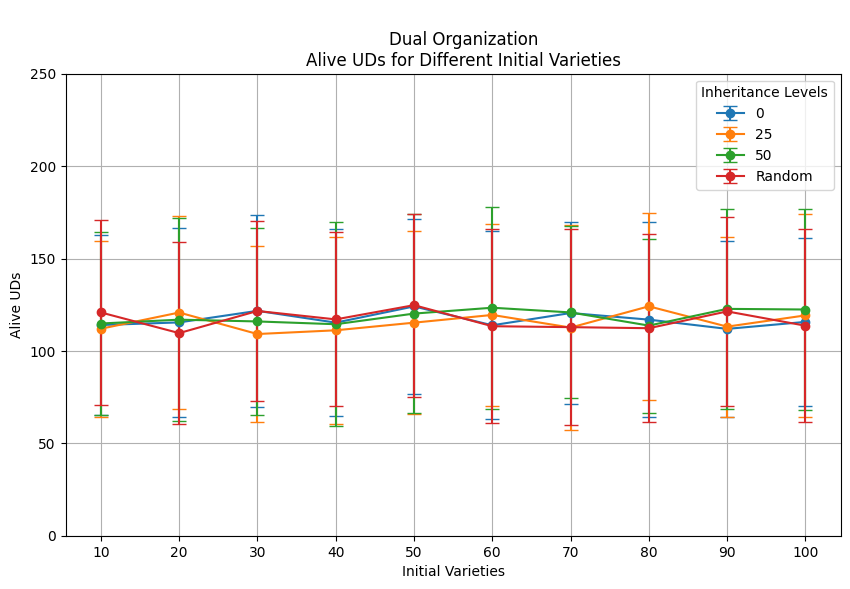

In [16]:
transversal_changes(DvM_datos, inherits, Dvalphas, 'Dual Organization', variable='Initial Varieties')
transversal_alive(DvM_datos, inherits, Dvalphas, 'Dual Organization', variable='Initial Varieties')

## Pop dynamics

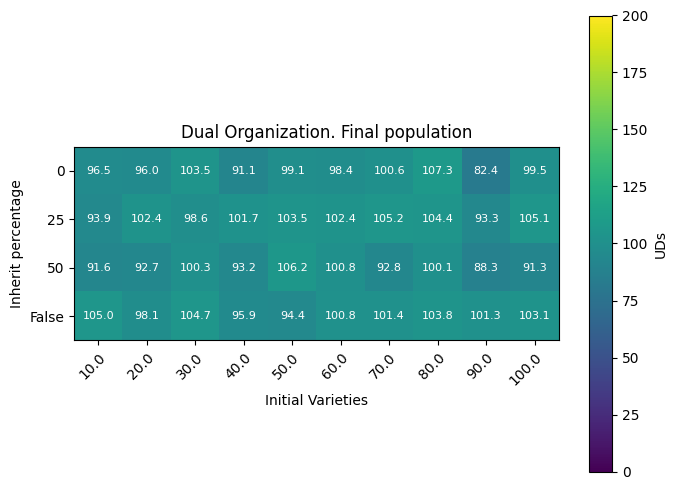

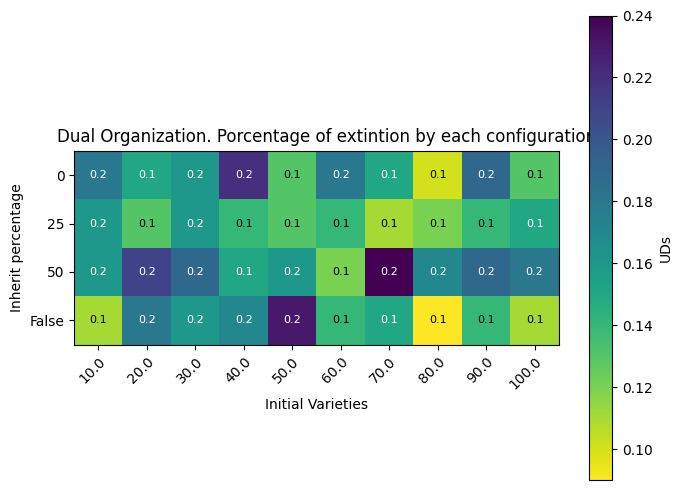

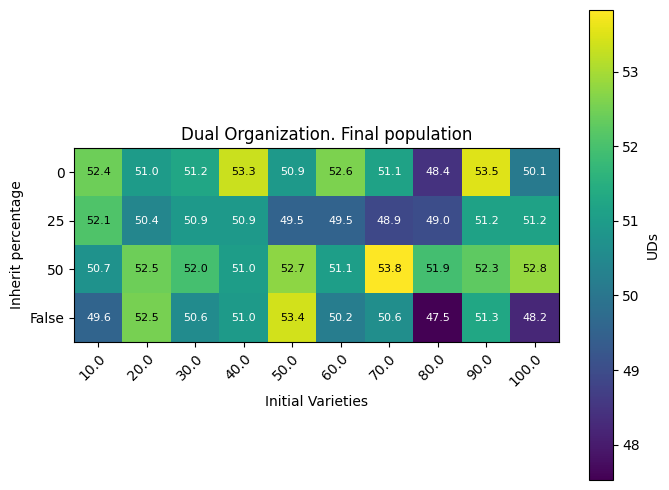

In [92]:
heat_population(DvM_datos, inherits, Dvalphas, 'Dual Organization', variable='Initial Varieties')

heat_percentage_population(DvM_datos, inherits, Dvalphas, 'Dual Organization', variable='Initial Varieties')

heat_std (DvM_datos, inherits, Dvalphas, 'Dual Organization', variable='Initial Varieties')

## Mean of children

In [ ]:
# This experiment has different values for Mean of children
prob_morte = 0.06 #beta
n = 10 # Mean
m = 40 # Initial UDs
inherits = [0,25,50, 'False']
Dcalphas = np.linspace(1,n,n) # Mean of children from 1 to n
# For data of behaviour
cM = np.empty((len(inherits), len(Dcalphas)), dtype=object) # alive, mean and diversity levels

punto_vista = 50
tiempo = 1000
tempo = list(range(0,tiempo+1,punto_vista))
experiments = 100
max_iterations = 400


print(cM.shape)
start = time.time()
print(f"started at:  {datetime.now()}")
for i, inherit in enumerate(inherits):
    for j, media  in enumerate(Dcalphas):
        star_configuration = time.time()
        #For population dynamics
        list_alive_UDs = []
        list_vivas_puntos_vista = []
        tasas_crecimiento = []
        #For diversity dynamics
        data_step_mean_var_ud = []
        data_step_var_system = []
        data_step_unique_system = []
        print(f"Experiments with inheritance {inherit} and Mean of Children {media}")
        #Lists to store experiments' diversity data
        data_endo_mean_ud = []
        data_endo_com_level = []
        data_endo_total_varieties = []
        original_media = media
        #To see how frequent goes to extintion
        contador = 0
        iterations = 0
        while contador < experiments and iterations < max_iterations: 
        #for experiment in range(1, experiments+1):
            print(f'experimento {contador+1}')
            ## Clans
            clans = (list(range(1, 2 + 1)) * (int(m) // 2)) # Just 2 clans
            random.shuffle(clans)
            if inherit != 'False':
                #### Initialization
                UD_dual_organization.uds = {}
                instancias_ud = []
                for id_ud in range(1, int(m) + 1):
                    instancias_ud.append(UD_dual_organization(id_ud, media, clans.pop()))
                ## Varieties
                limited_varieties = True
                if limited_varieties == False:
                    for id_ud, ud in UD_dual_organization.uds.items():
                        for _ in range(3):
                            ud.varieties.append(Variety())
                else:
                    initial_varieties = [Variety() for _ in range (10)]
                    for ud in UD_dual_organization.uds.values():
                        for _ in range(3):
                            ud.varieties.append(random.choice(initial_varieties))   
                # Lists for graphs
                vivas_puntos_vista = [int(m)]
                vivas_tasa_crecimiento = [int(m)]
        #             mortas_puntos_vista = [0]
                #For diversity
                mean_var_ud = []
                var_system = []
                unique_system = []
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_dual_organization.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                # Simulation
                for t in range(1, tiempo):
                    uds_copy = {id_ud: ud for id_ud, ud in UD_dual_organization.uds.items() if ud.activa}
                    items = list(uds_copy.items())
                    random.shuffle(items)
                    uds_copy = dict(items)
                    alive = len(uds_copy)
                    if alive > 200 and (media == original_media):
                        media -= media//2
                        if media >= 4:
                            media = media //2
                    elif alive < 150 and media < original_media:
                        media = original_media
                    if not uds_copy: #Extintion
                        # Only 0
                        print(f"acabó en 0 el experimento {experiment} con herencia {inherits[i]} con mean {Dcalphas[j]}")
                        break         
                    # Cycle:
                    for id_ud, ud in uds_copy.items():
                        ud.ter_filho()
                        ud.buscar_ud(uds_copy, int(media), inherit, True, 0.2)
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
                    # Collecting data
                    vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                    if t % punto_vista == 0:
                        viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                        #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                        vivas_puntos_vista.append(viv)
                        # For diversity
                        var_ud = []
                        var_total = []
                        for ud in [ud for ud in UD_dual_organization.uds.values() if ud.activa ==True]:
                            var_ud.append(len(ud.varieties))
                            for variety in ud.varieties:
                                var_total.append(variety.variety_id)
                        mean_var_ud.append(np.mean(var_ud))
                        var_system.append(len(var_total))
                        unique_system.append(len(set(var_total))) 
                viv = len([ud for id, ud in UD_dual_organization.uds.items() if ud.activa])
                vivas_puntos_vista.append(viv)
                # For diversity
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_dual_organization.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                alive = (len([ud for id, ud in uds_copy.items() if ud.activa]))
                if alive >= 1:   
                    total_varieties = []
                    varieties_per_UD = []
                    for ud in [ud for ud in UD_dual_organization.uds.values() if ud.activa ==True]:
                        varieties_per_UD.append(len(ud.varieties))
                        for variety in ud.varieties:
                            total_varieties.append(variety.variety_id)
                    data_endo_mean_ud.append(np.mean(varieties_per_UD))
                    data_endo_com_level.append(len(set(total_varieties)))
                    data_endo_total_varieties.append(total_varieties)
            
            else:# Now with inherit == False
                #### Initialization
                UD_dual_organization_al_inh.uds = {}
                instancias_ud = []
                for id_ud in range(1, int(m) + 1):
                    instancias_ud.append(UD_dual_organization_al_inh(id_ud, media, clans.pop()))
                ## Varieties
                limited_varieties = True
                if limited_varieties == False:
                    for id_ud, ud in UD_dual_organization_al_inh.uds.items():
                        for _ in range(3):
                            ud.varieties.append(Variety())
                else:
                    initial_varieties = [Variety() for _ in range (10)]
                    for ud in UD_dual_organization_al_inh.uds.values():
                        for _ in range(3):
                            ud.varieties.append(random.choice(initial_varieties))   
                # Lists for graphs
                vivas_puntos_vista = [int(m)]
                vivas_tasa_crecimiento = [int(m)]
        #             mortas_puntos_vista = [0]
                #For diversity
                mean_var_ud = []
                var_system = []
                unique_system = []
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_dual_organization_al_inh.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                # Simulation
                for t in range(1, tiempo):
                    uds_copy = {id_ud: ud for id_ud, ud in UD_dual_organization_al_inh.uds.items() if ud.activa}
                    items = list(uds_copy.items())
                    random.shuffle(items)
                    uds_copy = dict(items)
                    alive = len(uds_copy)
                    if alive > 200 and (media == original_media):
                        media -= media//2
                        if media >= 4:
                            media = media //2
                    elif alive < 150 and media < original_media:
                        media = original_media
                    if not uds_copy: #Extintion
                        # Only 0
                        print(f"acabó en 0 el experimento {experiment} con herencia {inherits[i]} con mean {Dcalphas[j]}")
                        break         
                    # Cycle:
                    varieties_list = [var for ud in uds_copy.values() for var in ud.varieties]
                    for id_ud, ud in uds_copy.items():
                        ud.ter_filho()
                        ud.buscar_ud(uds_copy, int(media), varieties_list, True, 3, 0.2)
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
                    # Collecting data
                    vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                    if t % punto_vista == 0:
                        viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                        #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                        vivas_puntos_vista.append(viv)
                        # For diversity
                        var_ud = []
                        var_total = []
                        for ud in [ud for ud in UD_dual_organization_al_inh.uds.values() if ud.activa ==True]:
                            var_ud.append(len(ud.varieties))
                            for variety in ud.varieties:
                                var_total.append(variety.variety_id)
                        mean_var_ud.append(np.mean(var_ud))
                        var_system.append(len(var_total))
                        unique_system.append(len(set(var_total))) 
                viv = len([ud for id, ud in UD_dual_organization_al_inh.uds.items() if ud.activa])
                vivas_puntos_vista.append(viv)
                # For diversity
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_dual_organization_al_inh.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                alive = (len([ud for id, ud in uds_copy.items() if ud.activa]))
                if alive >= 1:   
                    total_varieties = []
                    varieties_per_UD = []
                    for ud in [ud for ud in UD_dual_organization_al_inh.uds.values() if ud.activa ==True]:
                        varieties_per_UD.append(len(ud.varieties))
                        for variety in ud.varieties:
                            total_varieties.append(variety.variety_id)
                    data_endo_mean_ud.append(np.mean(varieties_per_UD))
                    data_endo_com_level.append(len(set(total_varieties)))
                    data_endo_total_varieties.append(total_varieties)
            
            
            # Final collection of the data after the simulation!
            if len(uds_copy) > 0:  # Only collect data if the system is alive
                list_alive_UDs.append(len([ud for id, ud in uds_copy.items() if ud.activa == True]))  # For heatmap
                list_vivas_puntos_vista.append(vivas_puntos_vista)
                data_step_var_system.append(var_system)
                data_step_unique_system.append(unique_system)
                data_step_mean_var_ud.append(mean_var_ud)
                contador += 1
            iterations += 1
            print('succesful', contador)
            print('iterations', iterations) 
            
            data_inherit_endo = [data_endo_mean_ud, data_endo_com_level, data_endo_total_varieties]
        data_steps_inherit_endo = [data_step_var_system, data_step_unique_system, data_step_mean_var_ud]
        media = original_media
        end_config = time.time()
        if contador == experiments:
            cM[i][j] = {
                'alive': np.mean(list_alive_UDs),
                'lstd': np.std(list_alive_UDs),
                'time used': end_config - star_configuration,
                'percentage_extinction': contador / experiments,
                'tempo': tempo, 
                'mean': np.mean(list_vivas_puntos_vista, axis=0), 
                'std': np.std(list_vivas_puntos_vista, axis=0),
                'growth rate': np.mean([np.mean(lista) for lista in tasas_crecimiento]),
                'diversity_info': data_inherit_endo,
                'diversity_info_steps': data_steps_inherit_endo,
            }
        else:  # Handle extinction-only scenarios
            cM[i][j] = {
                'alive': None,
                'lstd': None,
                'time used': end_config - star_configuration,
                'percentage_extinction': 1.0,  # All experiments went extinct
                'tempo': None, 
                'mean': None, 
                'std': None,
                'growth rate': None,
                'diversity_info': None,
                'diversity_info_steps': None,
            }
        print(f"""
The total time of the configuration of inherit percentage {inherit} and initial UDs {m} and mean {media} is  {end_config - star_configuration}
        """)
# Folder
folder_name = 'Experiments_kinship_inheritance_parameters'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Data
heat_std = os.path.join(folder_name, 'Dual_Mean_children.npy')
np.save(heat_std, cM)
now = datetime.now()
finish = time.time()
print(f"""
It finished at: {now}
It lasted {finish-start}
""")
print("done")

In [17]:
# Dowload the documents
#As a reference
n = 10 # Mean
# m = 40 # Initial UDs
inherits = [0,25,50, 'False']
Dcalphas = np.linspace(1,n,n) # Mean of children from 1 to n
punto_vista = 50
tiempo = 1000
tempo = list(range(0,tiempo+1,punto_vista))

#Folders
folder_name = 'Experiments_kinship_inheritance_parameters'
heat_std = os.path.join(folder_name, 'Dual_Mean_children.npy')

## General Data
DcM_datos = np.load(heat_std, allow_pickle=True)

## Diversity dynamics

Skipping Inherit 0%, Mean of children 1.0 due to no data
Skipping Inherit 0%, Mean of children 2.0 due to no data
Skipping Inherit 0%, Mean of children 3.0 due to no data


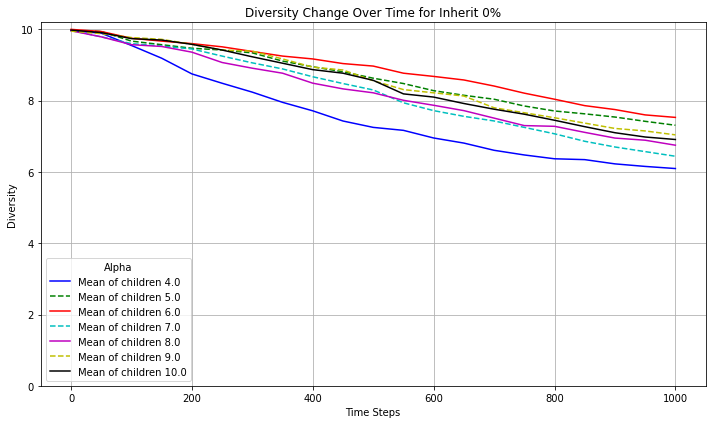

Skipping Inherit 25%, Mean of children 1.0 due to no data
Skipping Inherit 25%, Mean of children 2.0 due to no data
Skipping Inherit 25%, Mean of children 3.0 due to no data


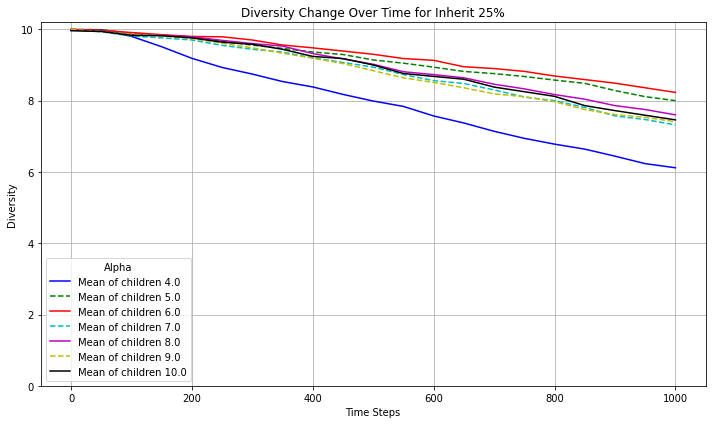

Skipping Inherit 50%, Mean of children 1.0 due to no data
Skipping Inherit 50%, Mean of children 2.0 due to no data
Skipping Inherit 50%, Mean of children 3.0 due to no data


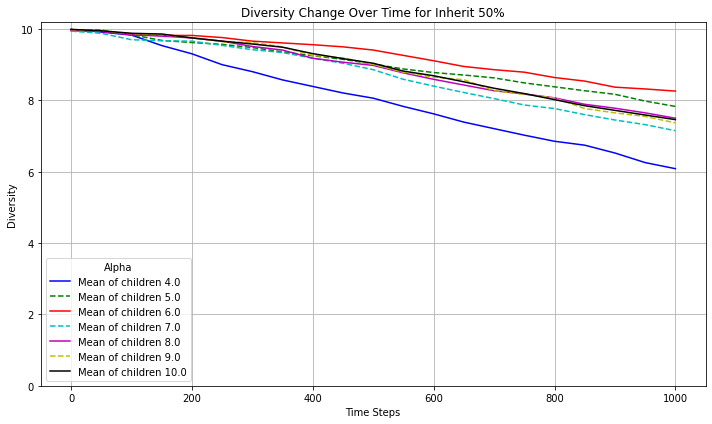

Skipping Inherit False%, Mean of children 1.0 due to no data
Skipping Inherit False%, Mean of children 2.0 due to no data
Skipping Inherit False%, Mean of children 3.0 due to no data


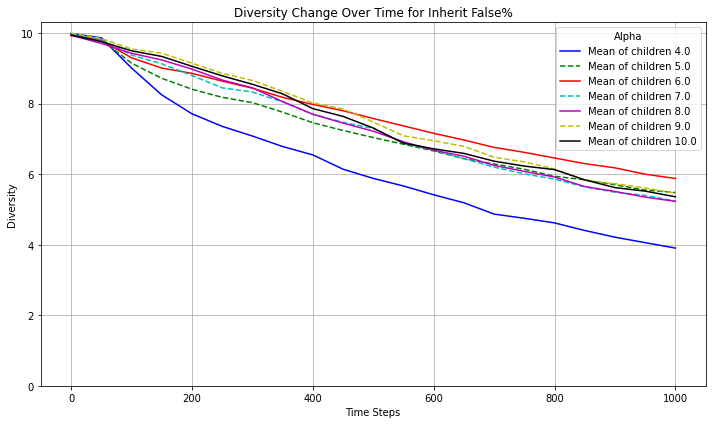

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Skipping Inherit 0%, Mean of children 1.0 due to no data
Skipping Inherit 25%, Mean of children 1.0 due to no data
Skipping Inherit 50%, Mean of children 1.0 due to no data
Skipping Inherit False%, Mean of children 1.0 due to no data


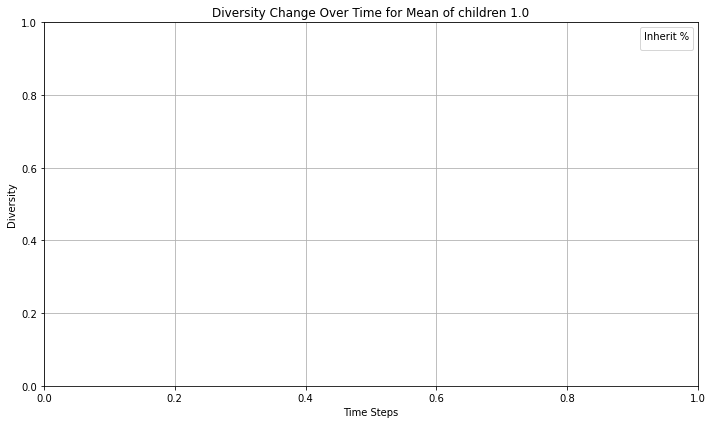

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Skipping Inherit 0%, Mean of children 2.0 due to no data
Skipping Inherit 25%, Mean of children 2.0 due to no data
Skipping Inherit 50%, Mean of children 2.0 due to no data
Skipping Inherit False%, Mean of children 2.0 due to no data


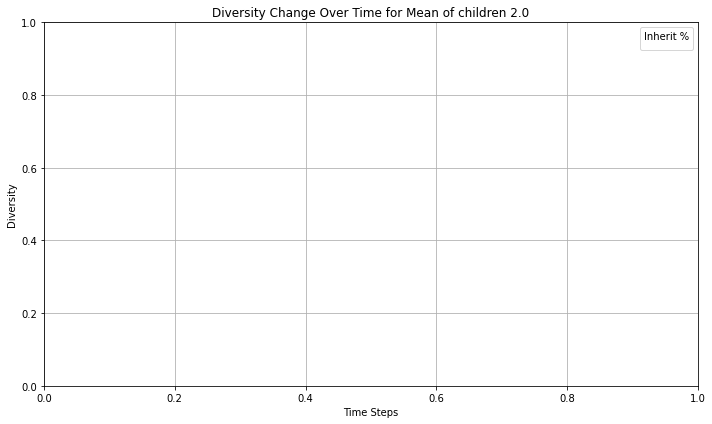

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Skipping Inherit 0%, Mean of children 3.0 due to no data
Skipping Inherit 25%, Mean of children 3.0 due to no data
Skipping Inherit 50%, Mean of children 3.0 due to no data
Skipping Inherit False%, Mean of children 3.0 due to no data


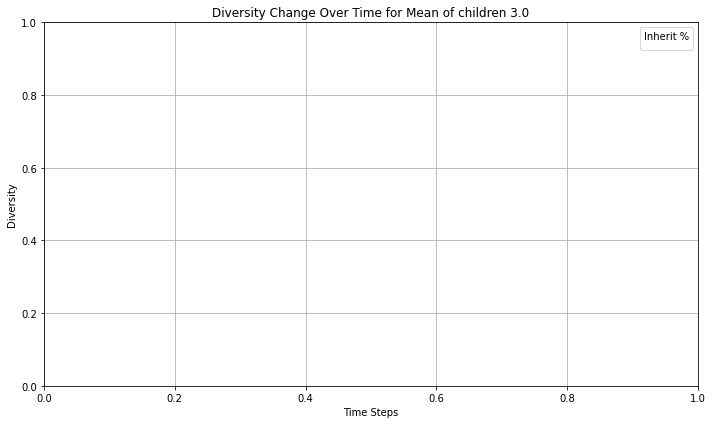

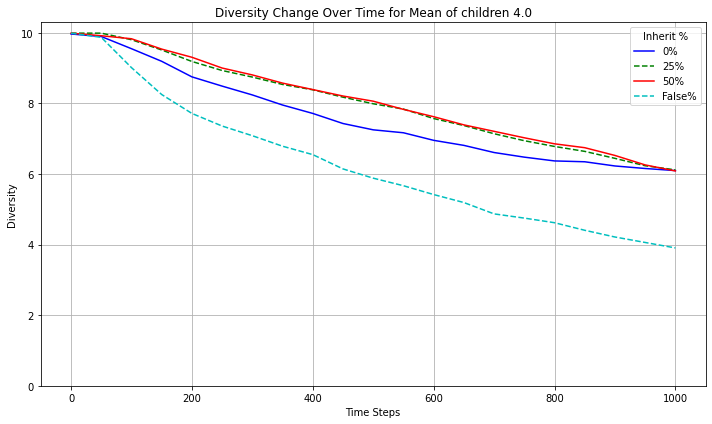

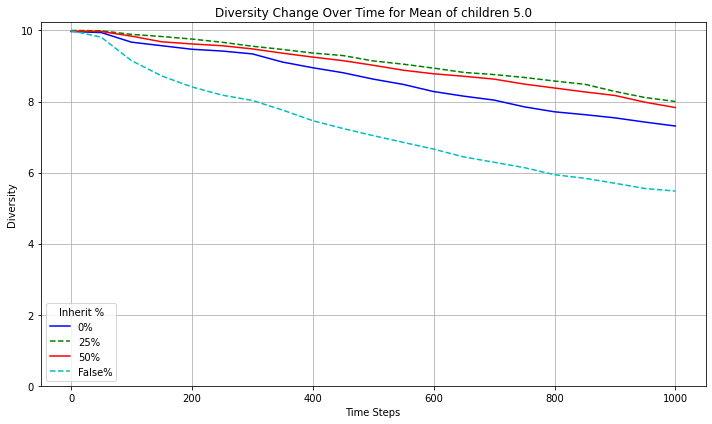

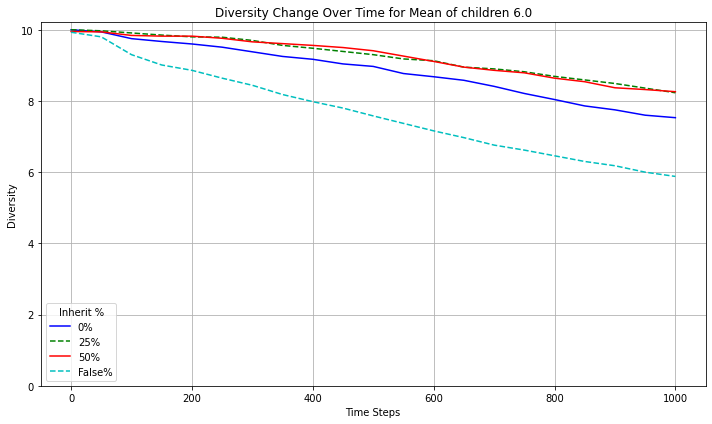

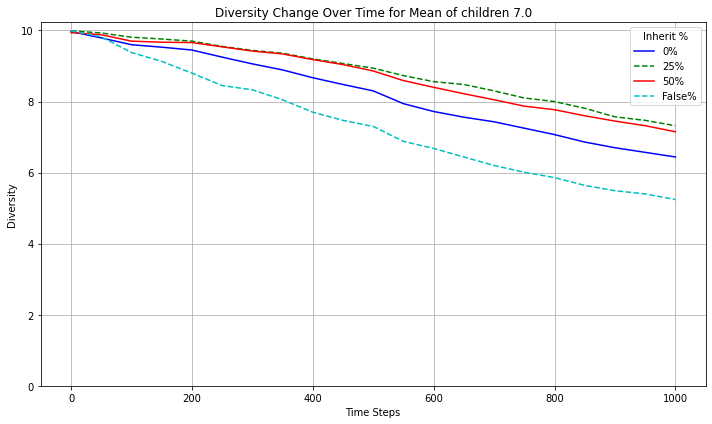

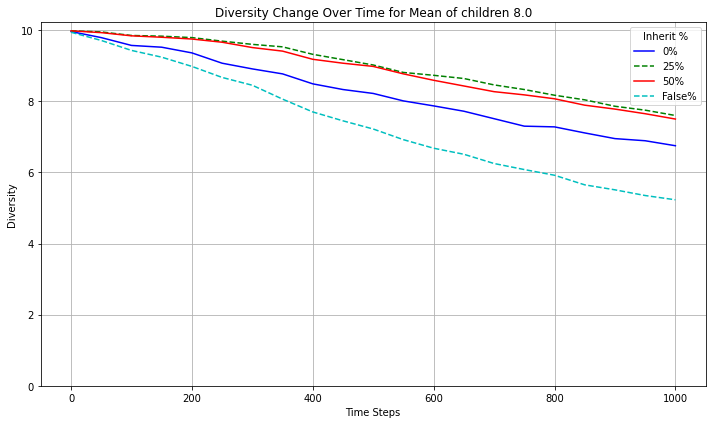

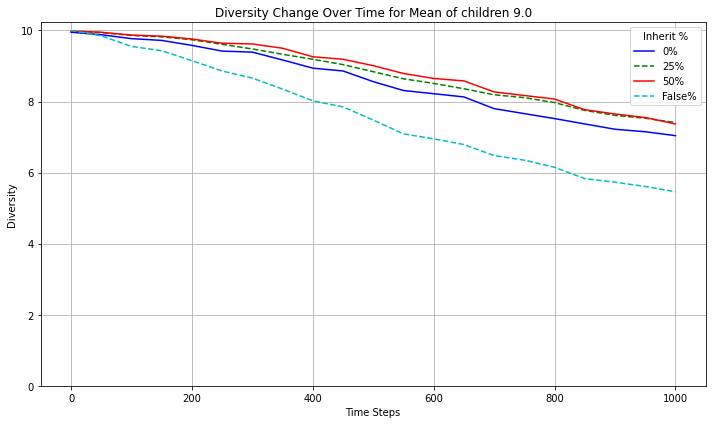

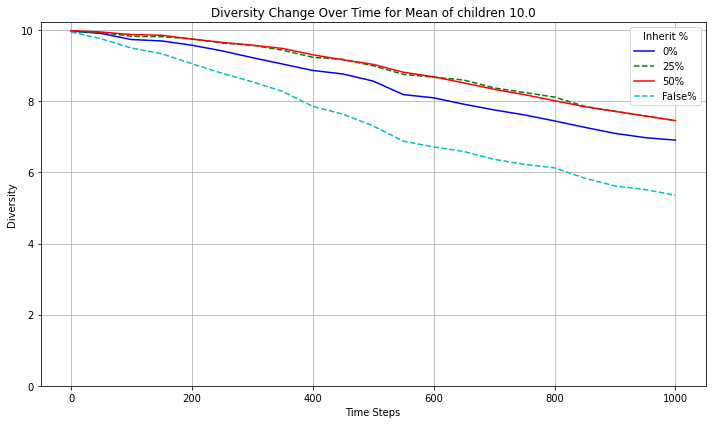

In [38]:
#heat_diversity_comm_level(DcM_datos, inherits, Dcalphas, 'Dual Organization', variable='Mean of children')
#diversity_change_graphs(DcM_datos, inherits, Dcalphas, 'Dual Organization', variable='Mean of children', limitant = True)
#diversity_change_by_row(DcM_datos, inherits, Dcalphas, 'Dual Organization', variable='Mean of children', limitant=True)
#diversity_change_by_column(DcM_datos, inherits, Dcalphas, 'Dual Organization', variable='Mean of children', limitant=True)

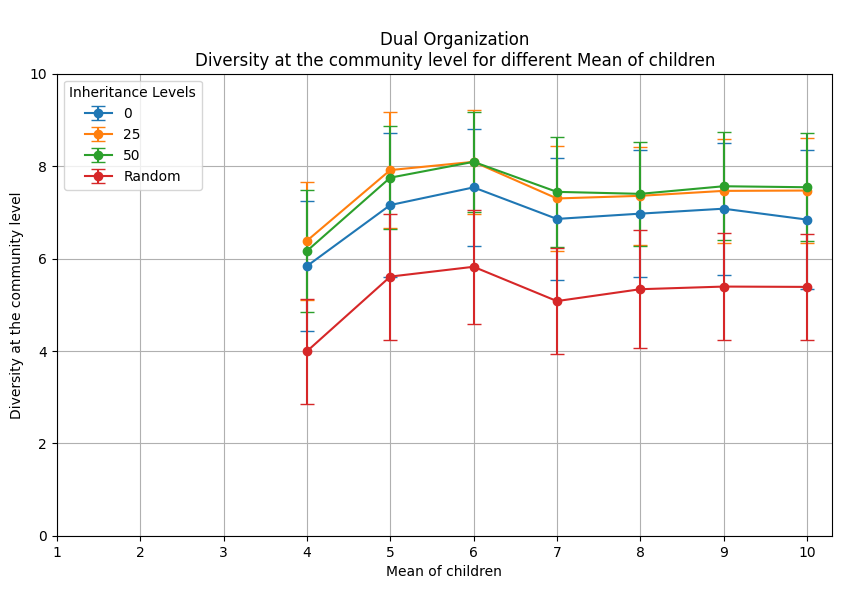

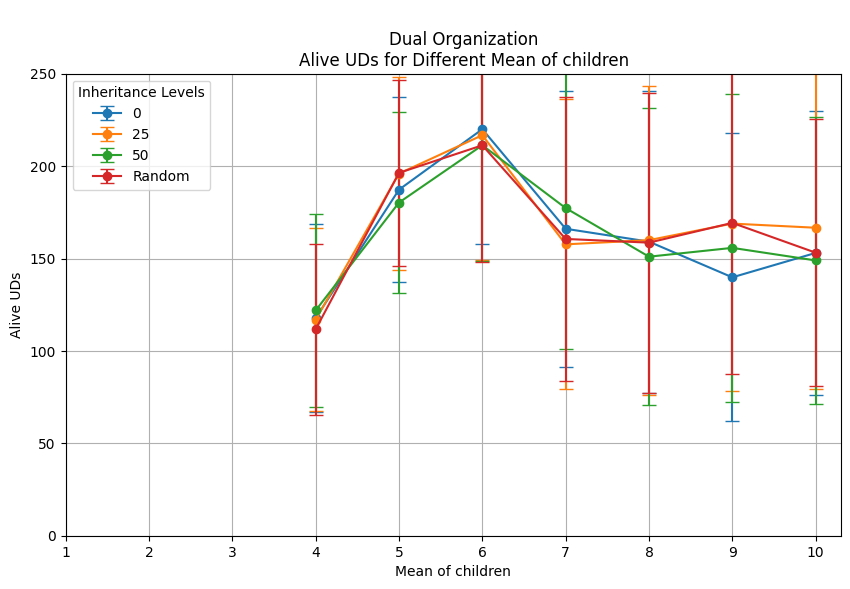

In [18]:
transversal_changes(DcM_datos, inherits, Dcalphas, 'Dual Organization', variable='Mean of children')
transversal_alive(DcM_datos, inherits, Dcalphas, 'Dual Organization', variable='Mean of children')

## Pop dynamics

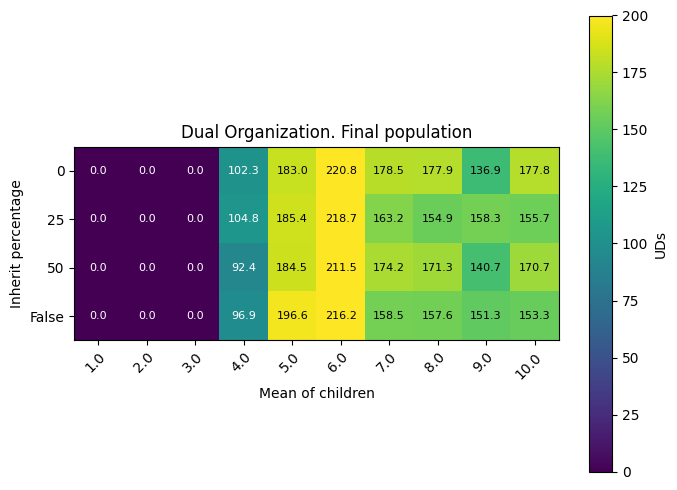

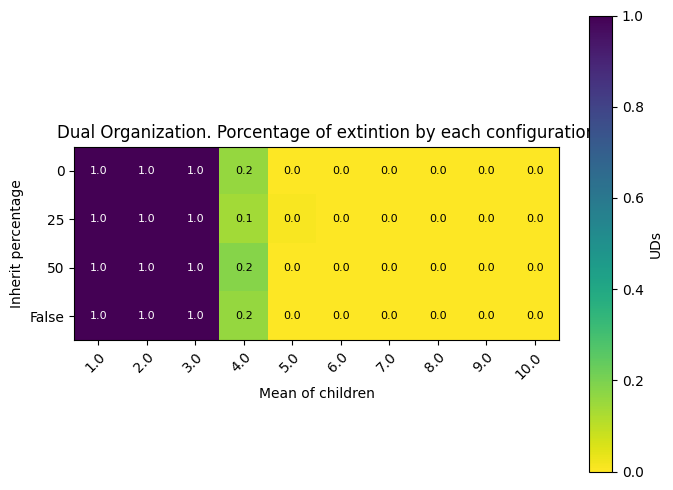

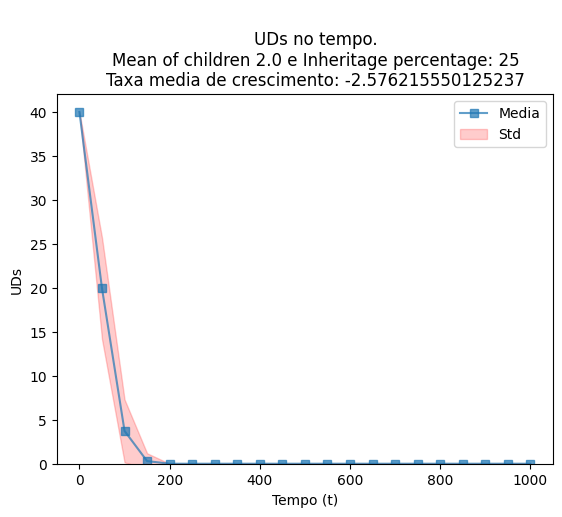

In [93]:
heat_population(DcM_datos, inherits, Dcalphas, 'Dual Organization', variable='Mean of children')

heat_percentage_population(DcM_datos, inherits, Dcalphas, 'Dual Organization', variable='Mean of children')

plot_specific_alivegraph(1, 1, DcM_datos, inherits, Dcalphas, 'Dual Organization', variable='Mean of children')

## Mean varieties

In [ ]:
# This experiment has different values for Initial varieties mv
prob_morte = 0.06 #beta
media = 4 # Mean
m = 40
#v = 10 # Initial varieties
mv = 10
inherits = [0,25,50, 'False'] #Values for inherit
# inherits = [0,25,50] #Values for inherit
Dmvalphas = np.linspace(1,mv,mv)# Mean varieties from 1 to mv
# For data of behaviour
vM = np.empty((len(inherits), len(Dmvalphas)), dtype=object) # alive, mean and diversity levels

punto_vista = 50
tiempo = 1000
tempo = list(range(0,tiempo+1,punto_vista))
experiments = 100
max_iterations = 400


print(vM.shape)
start = time.time()
print(f"started at:  {datetime.now()}")
for i, inherit in enumerate(inherits):
    for j, mvarieties  in enumerate(Dmvalphas):
        star_configuration = time.time()
        #For population dynamics
        list_alive_UDs = []
        list_vivas_puntos_vista = []
        tasas_crecimiento = []
        #For diversity dynamics
        data_step_mean_var_ud = []
        data_step_var_system = []
        data_step_unique_system = []
        print(f"Experiments with inheritance {inherit} Initial UDs {m} and Mean varieties {mvarieties}")
        #Lists to store experiments' diversity data
        data_endo_mean_ud = []
        data_endo_com_level = []
        data_endo_total_varieties = []
        original_media = media
        #To see how frequent goes to extintion
        contador = 0
        iterations = 0
        while contador < experiments and iterations < max_iterations: 
        #for experiment in range(1, experiments+1):
            print(f'experimento {contador+1}')
            ## Clans
            clans = (list(range(1, 2 + 1)) * (int(m) // 2)) # Just 2 clans
            random.shuffle(clans)
            if inherit != 'False':
                #### Initialization
                UD_dual_organization.uds = {}
                instancias_ud = []
                for id_ud in range(1, int(m) + 1):
                    instancias_ud.append(UD_dual_organization(id_ud, media, clans.pop()))
                ## Varieties
                limited_varieties = True
                if limited_varieties == False:
                    for id_ud, ud in UD_dual_organization.uds.items():
                        for _ in range(3):
                            ud.varieties.append(Variety())
                else:
                    initial_varieties = [Variety() for _ in range (int(10))]
                    for ud in UD_dual_organization.uds.values():
                        for _ in range(int(mvarieties)):
                            ud.varieties.append(random.choice(initial_varieties))   
                # Lists for graphs
                vivas_puntos_vista = [int(m)]
                vivas_tasa_crecimiento = [int(m)]
        #             mortas_puntos_vista = [0]
                #For diversity
                mean_var_ud = []
                var_system = []
                unique_system = []
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_dual_organization.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                # Simulation
                for t in range(1, tiempo):
                    uds_copy = {id_ud: ud for id_ud, ud in UD_dual_organization.uds.items() if ud.activa}
                    items = list(uds_copy.items())
                    random.shuffle(items)
                    uds_copy = dict(items)
                    alive = len(uds_copy)
                    if alive > 200 and (media == original_media):
                        media -= media//2
                        if media >= 4:
                            media = media //2
                    elif alive < 150 and media < original_media:
                        media = original_media
                    if not uds_copy: #Extintion
                        # Only 0
                        print(f"acabó en 0 el experimento {experiment} con herencia {inherits[i]} con unidades {Dmvalphas[j]}")
                        break         
                    # Cycle:
                    for id_ud, ud in uds_copy.items():
                        ud.ter_filho()
                        ud.buscar_ud(uds_copy, int(media), inherit, True, 0.2)
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
                    # Collecting data
                    vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                    if t % punto_vista == 0:
                        viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                        #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                        vivas_puntos_vista.append(viv)
                        # For diversity
                        var_ud = []
                        var_total = []
                        for ud in [ud for ud in UD_dual_organization.uds.values() if ud.activa ==True]:
                            var_ud.append(len(ud.varieties))
                            for variety in ud.varieties:
                                var_total.append(variety.variety_id)
                        mean_var_ud.append(np.mean(var_ud))
                        var_system.append(len(var_total))
                        unique_system.append(len(set(var_total))) 
                viv = len([ud for id, ud in UD_dual_organization.uds.items() if ud.activa])
                vivas_puntos_vista.append(viv)
                # For diversity
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_dual_organization.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                alive = (len([ud for id, ud in uds_copy.items() if ud.activa]))
                if alive >= 1:   
                    total_varieties = []
                    varieties_per_UD = []
                    for ud in [ud for ud in UD_dual_organization.uds.values() if ud.activa ==True]:
                        varieties_per_UD.append(len(ud.varieties))
                        for variety in ud.varieties:
                            total_varieties.append(variety.variety_id)
                    data_endo_mean_ud.append(np.mean(varieties_per_UD))
                    data_endo_com_level.append(len(set(total_varieties)))
                    data_endo_total_varieties.append(total_varieties)
            
            else:# Now with inherit == False
                #### Initialization
                UD_dual_organization_al_inh.uds = {}
                instancias_ud = []
                for id_ud in range(1, int(m) + 1):
                    instancias_ud.append(UD_dual_organization_al_inh(id_ud, media, clans.pop()))
                ## Varieties
                limited_varieties = True
                if limited_varieties == False:
                    for id_ud, ud in UD_dual_organization_al_inh.uds.items():
                        for _ in range(3):
                            ud.varieties.append(Variety())
                else:
                    initial_varieties = [Variety() for _ in range (int(10))]
                    for ud in UD_dual_organization_al_inh.uds.values():
                        for _ in range(int(mvarieties)):
                            ud.varieties.append(random.choice(initial_varieties))   
                # Lists for graphs
                vivas_puntos_vista = [int(m)]
                vivas_tasa_crecimiento = [int(m)]
        #             mortas_puntos_vista = [0]
                #For diversity
                mean_var_ud = []
                var_system = []
                unique_system = []
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_dual_organization_al_inh.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                # Simulation
                for t in range(1, tiempo):
                    uds_copy = {id_ud: ud for id_ud, ud in UD_dual_organization_al_inh.uds.items() if ud.activa}
                    items = list(uds_copy.items())
                    random.shuffle(items)
                    uds_copy = dict(items)
                    alive = len(uds_copy)
                    if alive > 200 and (media == original_media):
                        media -= media//2
                        if media >= 4:
                            media = media //2
                    elif alive < 150 and media < original_media:
                        media = original_media
                    if not uds_copy: #Extintion
                        # Only 0
                        print(f"acabó en 0 el experimento {experiment} con herencia {inherits[i]} con unidades {Dmvalphas[j]}")
                        break         
                    # Cycle:
                    varieties_list = [var for ud in uds_copy.values() for var in ud.varieties]
                    for id_ud, ud in uds_copy.items():
                        ud.ter_filho()
                        ud.buscar_ud(uds_copy, int(media), varieties_list, True, int(mvarieties), 0.2)
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
                    # Collecting data
                    vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                    if t % punto_vista == 0:
                        viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                        #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                        vivas_puntos_vista.append(viv)
                        # For diversity
                        var_ud = []
                        var_total = []
                        for ud in [ud for ud in UD_dual_organization_al_inh.uds.values() if ud.activa ==True]:
                            var_ud.append(len(ud.varieties))
                            for variety in ud.varieties:
                                var_total.append(variety.variety_id)
                        mean_var_ud.append(np.mean(var_ud))
                        var_system.append(len(var_total))
                        unique_system.append(len(set(var_total))) 
                viv = len([ud for id, ud in UD_dual_organization_al_inh.uds.items() if ud.activa])
                vivas_puntos_vista.append(viv)
                # For diversity
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_dual_organization_al_inh.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                alive = (len([ud for id, ud in uds_copy.items() if ud.activa]))
                if alive >= 1:   
                    total_varieties = []
                    varieties_per_UD = []
                    for ud in [ud for ud in UD_dual_organization_al_inh.uds.values() if ud.activa ==True]:
                        varieties_per_UD.append(len(ud.varieties))
                        for variety in ud.varieties:
                            total_varieties.append(variety.variety_id)
                    data_endo_mean_ud.append(np.mean(varieties_per_UD))
                    data_endo_com_level.append(len(set(total_varieties)))
                    data_endo_total_varieties.append(total_varieties)
            
            
            # Final collection of the data after the simulation!
            if len(uds_copy) > 0:  # Only collect data if the system is alive
                list_alive_UDs.append(len([ud for id, ud in uds_copy.items() if ud.activa == True]))  # For heatmap
                list_vivas_puntos_vista.append(vivas_puntos_vista)
                data_step_var_system.append(var_system)
                data_step_unique_system.append(unique_system)
                data_step_mean_var_ud.append(mean_var_ud)
                contador += 1
            iterations += 1
            print('succesful', contador)
            print('iterations', iterations)   
            
            data_inherit_endo = [data_endo_mean_ud, data_endo_com_level, data_endo_total_varieties]
        data_steps_inherit_endo = [data_step_var_system, data_step_unique_system, data_step_mean_var_ud]
        media = original_media
        end_config = time.time()
        if contador == experiments:
            vM[i][j] = {
                'alive': np.mean(list_alive_UDs),
                'lstd': np.std(list_alive_UDs),
                'time used': end_config - star_configuration,
                'percentage_extinction': contador / experiments,
                'tempo': tempo, 
                'mean': np.mean(list_vivas_puntos_vista, axis=0), 
                'std': np.std(list_vivas_puntos_vista, axis=0),
                'growth rate': np.mean([np.mean(lista) for lista in tasas_crecimiento]),
                'diversity_info': data_inherit_endo,
                'diversity_info_steps': data_steps_inherit_endo,
            }
        else:  # Handle extinction-only scenarios
            vM[i][j] = {
                'alive': None,
                'lstd': None,
                'time used': end_config - star_configuration,
                'percentage_extinction': 1.0,  # All experiments went extinct
                'tempo': None, 
                'mean': None, 
                'std': None,
                'growth rate': None,
                'diversity_info': None,
                'diversity_info_steps': None,
            }
        print(f"""
The total time of the configuration of inherit percentage {inherit}, 
  initial UDs {m} and Mean varieties {mvarieties} is  {end_config - star_configuration}
        """)
# Folder
folder_name = 'Experiments_kinship_inheritance_parameters'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Heatmap and std
heat_std = os.path.join(folder_name, 'Dual_Initial_Mean_varieties.npy')
np.save(heat_std, vM)
now = datetime.now()
finish = time.time()
print(f"""
It finished at: {now}
It lasted {finish-start}
""")
print("done")

In [19]:
# Dowload the documents
#As a reference
mv = 10 # Mean
inherits = [0,25,50, 'False']
#inherits = [0,'False']
Dmvalphas = np.linspace(1,mv,mv) # Mean of children from 1 to n
punto_vista = 50
tiempo = 1000
tempo = list(range(0,tiempo+1,punto_vista))

#Folders
folder_name = 'Experiments_kinship_inheritance_parameters'
heat_std = os.path.join(folder_name, 'Dual_Initial_Mean_varieties.npy')

## General Data
DmvM_datos = np.load(heat_std, allow_pickle=True)

## Diversity dynamics

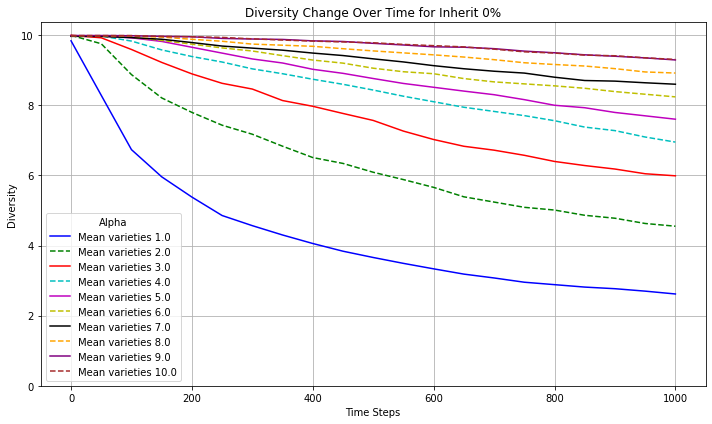

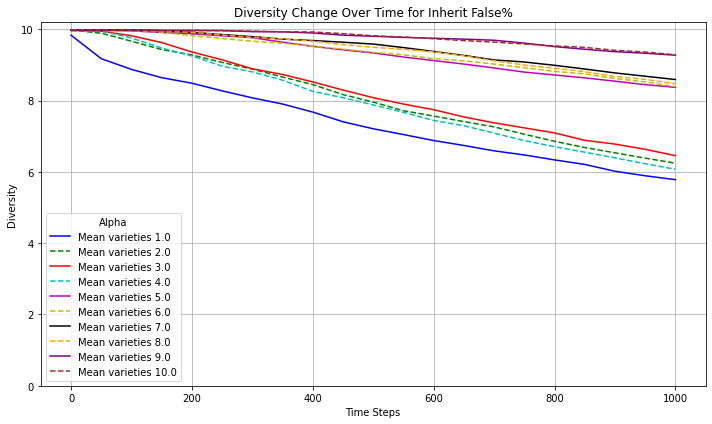

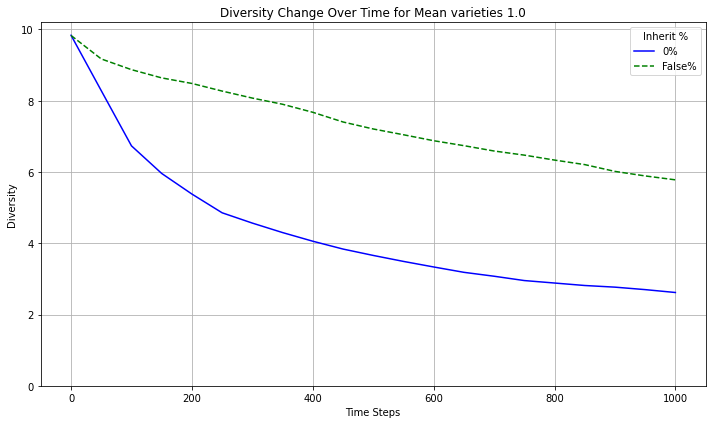

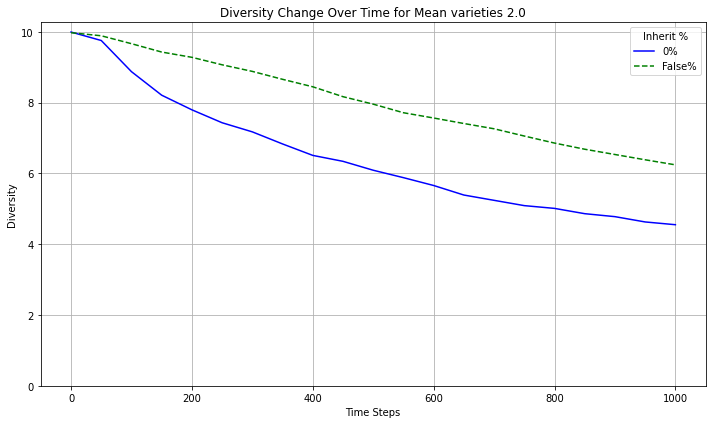

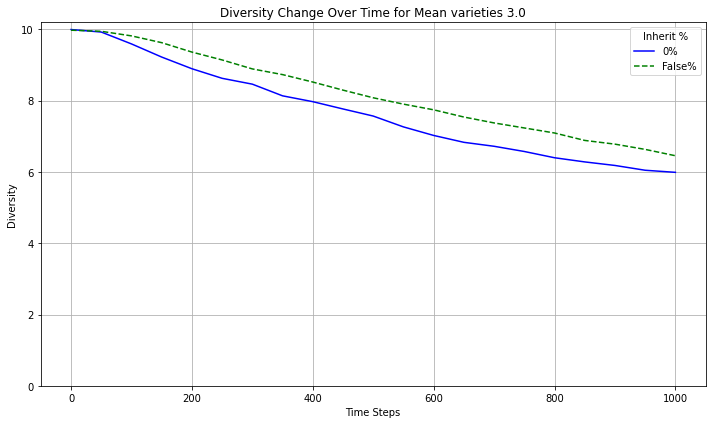

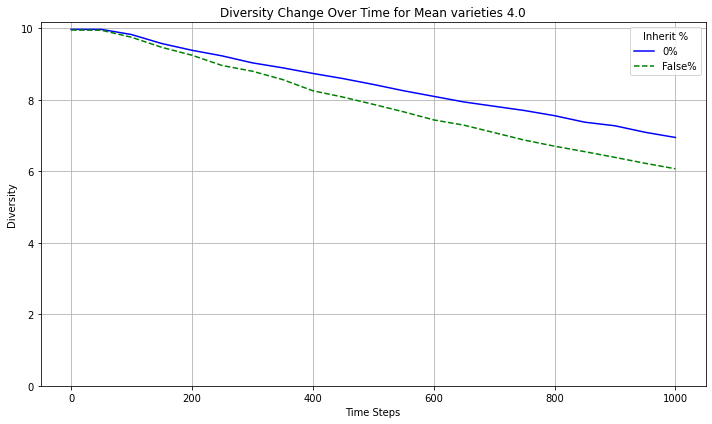

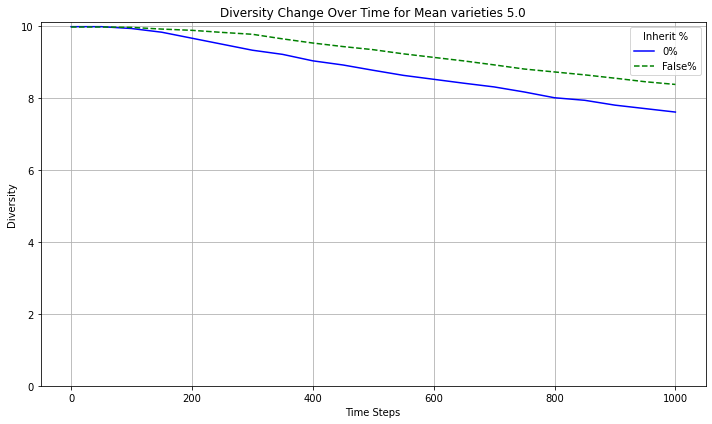

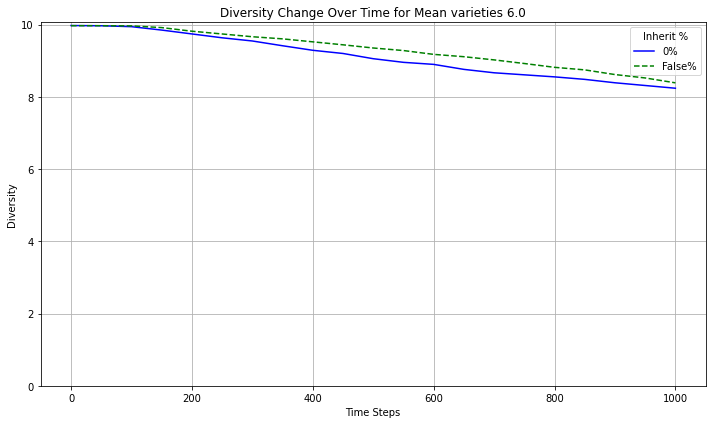

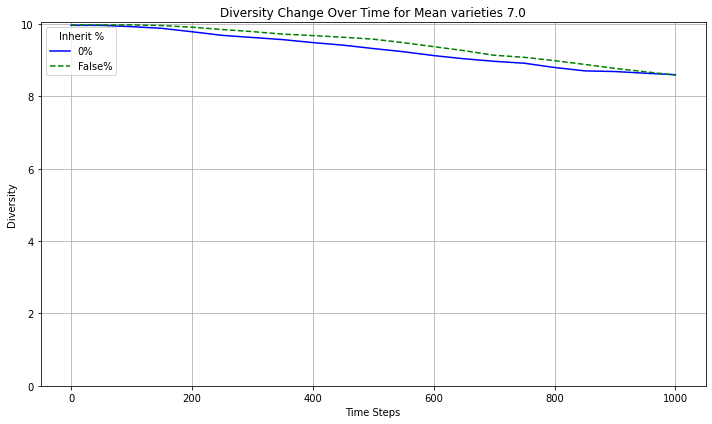

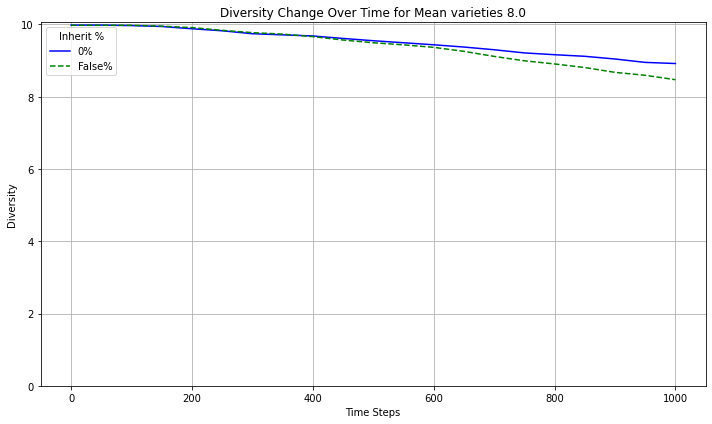

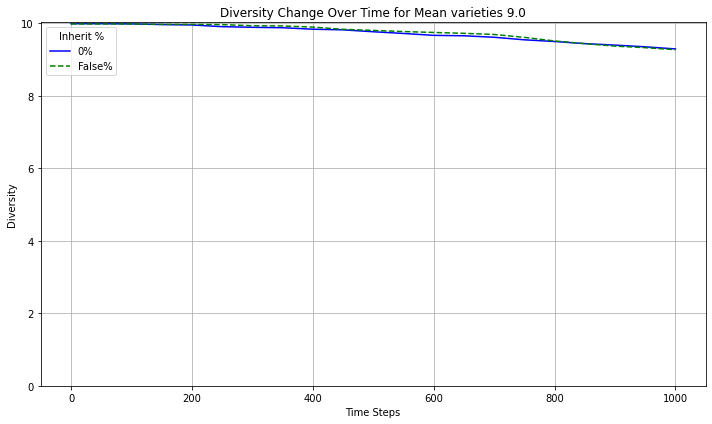

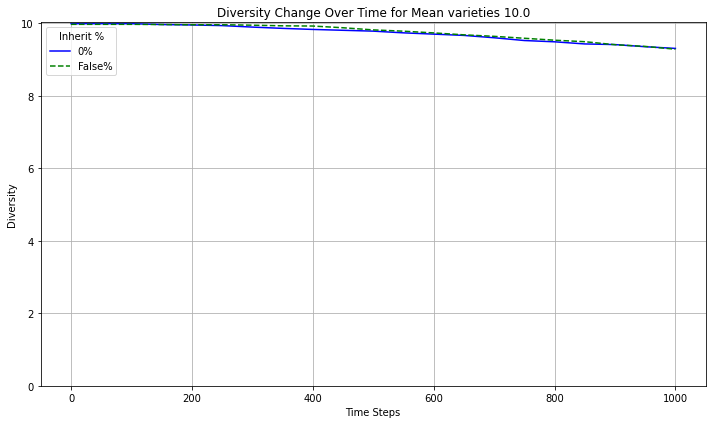

In [26]:
#heat_diversity_comm_level(DmvM_datos, inherits, Dmvalphas, 'Dual Organization', variable='Mean varieties')
#diversity_change_graphs(DmvM_datos, inherits, Dmvalphas, 'Dual Organization', variable='Mean varieties', limitant = True)
#diversity_change_by_row(DmvM_datos, inherits, Dmvalphas, 'Dual Organization', variable='Mean varieties', limitant=True)
#diversity_change_by_column(DmvM_datos, inherits, Dmvalphas, 'Dual Organization', variable='Mean varieties', limitant=True)

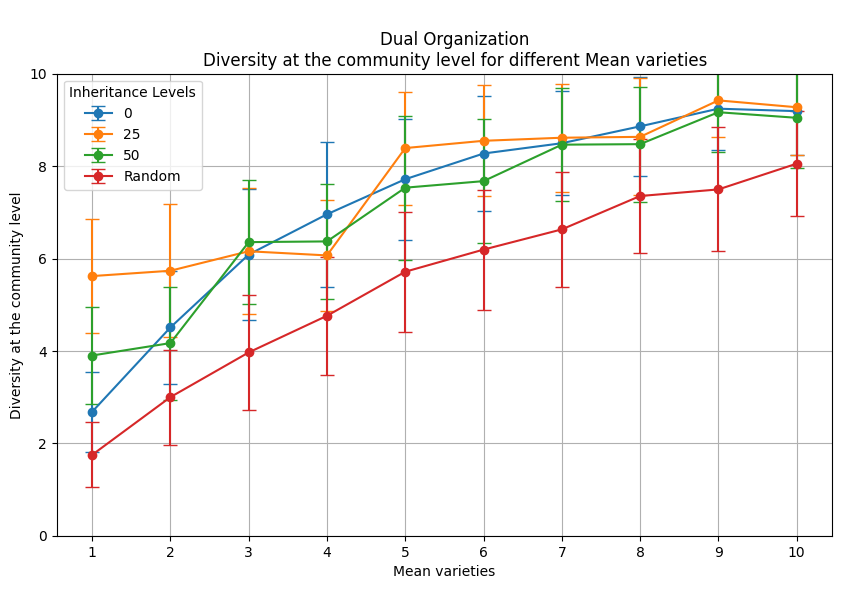

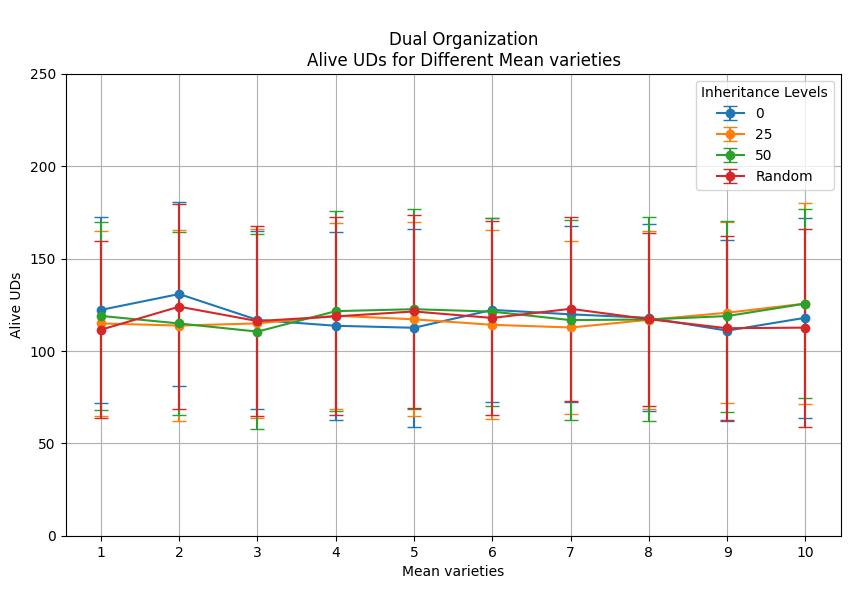

In [20]:
transversal_changes(DmvM_datos, inherits, Dmvalphas, 'Dual Organization', variable='Mean varieties')
transversal_alive(DmvM_datos, inherits, Dmvalphas, 'Dual Organization', variable='Mean varieties')

## Population dynamics

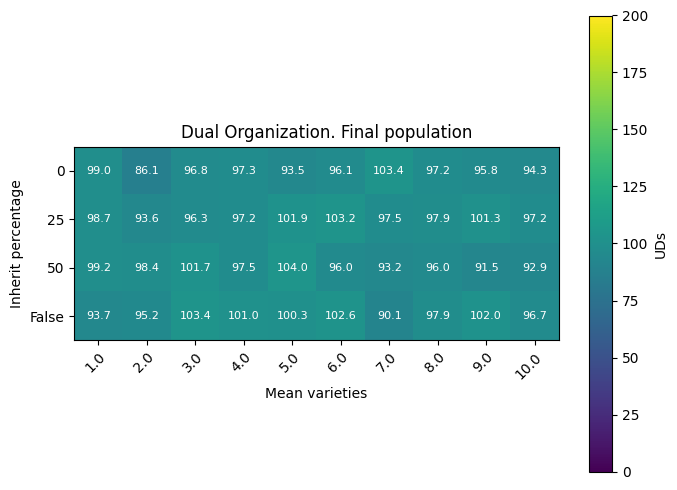

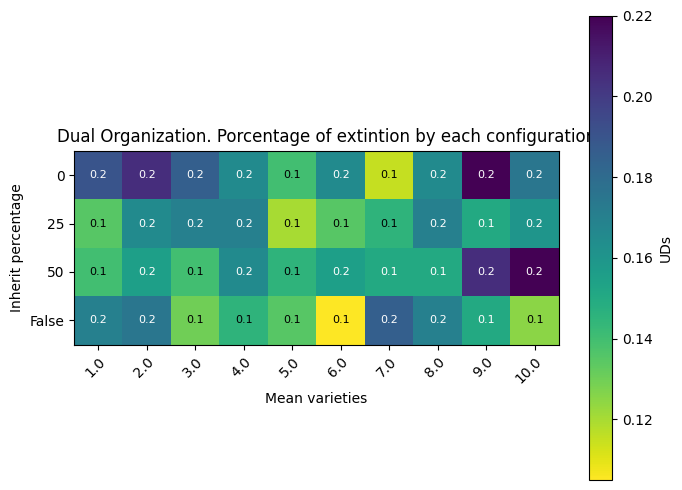

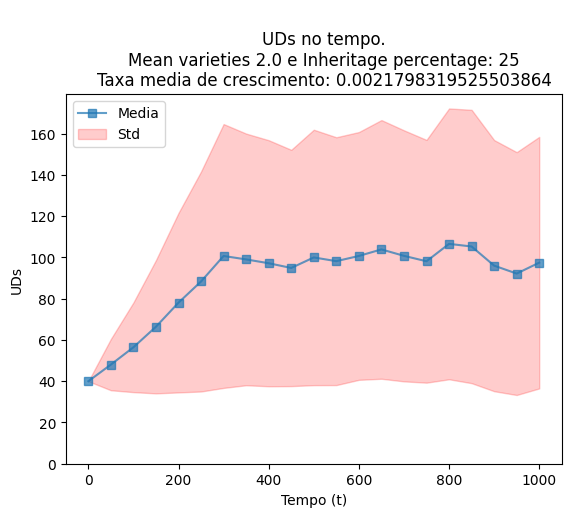

In [100]:
heat_population(DmvM_datos, inherits, Dmvalphas, 'Dual Organization', variable='Mean varieties')
heat_percentage_population(DmvM_datos, inherits, Dmvalphas, 'Dual Organization', variable='Mean varieties')
plot_specific_alivegraph(1, 1, DmvM_datos, inherits, Dmvalphas, 'Dual Organization', variable='Mean varieties')

# Generalized

## Initial UDs

Here we experimento with Initial UDs. We try from 10 to 100

In [ ]:
# This experiment has different values for Initial UDs
prob_morte = 0.06 #beta
media = 4 # Mean
m = 100 # Initial UDs
inherits = [0,25,50, 'False']
# inherits = [0,25,50] #Values for inherit
#inherits = ['False'] #Values for inherit
Gmalphas = np.linspace(10,m,int(m/10)) # Initial UDs: from 10 to m
# For data of behaviour
mM = np.empty((len(inherits), len(Gmalphas)), dtype=object) # alive, mean and diversity levels

punto_vista = 50
tiempo = 1000
tempo = list(range(0,tiempo+1,punto_vista))
experiments = 100
max_iterations = 400

print(mM.shape)
start = time.time()
print(f"started at:  {datetime.now()}")
for i, inherit in enumerate(inherits):
    for j, iniciais  in enumerate(Gmalphas):
        star_configuration = time.time()
        #For population dynamics
        list_alive_UDs = []
        list_vivas_puntos_vista = []
        tasas_crecimiento = []
        #For diversity dynamics
        data_step_mean_var_ud = []
        data_step_var_system = []
        data_step_unique_system = []
        print(f"Experiments with inheritance {inherit} and Initial UDs {iniciais}")
        #Lists to store experiments' diversity data
        data_endo_mean_ud = []
        data_endo_com_level = []
        data_endo_total_varieties = []
        original_media = media
        #To see how frequent goes to extintion
        contador = 0
        iterations = 0
        while contador < experiments and iterations < max_iterations:
        #for experiment in range(1, experiments+1):
            print(f'experimento {contador+1}')
            ## Clans
            clans = (list(range(1, 4)) * (int(iniciais) // 3 + 1))[:int(iniciais)] # Just 3 clans
            random.shuffle(clans)
            if inherit != 'False':          
                #### Initialization
                UD_generalized.uds = {}
                instancias_ud = []
                for id_ud in range(1, int(iniciais) + 1):
                    instancias_ud.append(UD_generalized(id_ud, media,clans.pop()))
                ## Varieties
                limited_varieties = True
                if limited_varieties == False:
                    for id_ud, ud in UD_generalized.uds.items():
                        for _ in range(3):
                            ud.varieties.append(Variety())
                else:
                    initial_varieties = [Variety() for _ in range (10)]
                    for ud in UD_generalized.uds.values():
                        for _ in range(3):
                            ud.varieties.append(random.choice(initial_varieties))   
                # Lists for graphs
                vivas_puntos_vista = [int(iniciais)]
                vivas_tasa_crecimiento = [int(iniciais)]
        #             mortas_puntos_vista = [0]
                #For diversity
                mean_var_ud = []
                var_system = []
                unique_system = []
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_generalized.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                # Simulation
                for t in range(1, tiempo):
                    uds_copy = {id_ud: ud for id_ud, ud in UD_generalized.uds.items() if ud.activa}
                    items = list(uds_copy.items())
                    random.shuffle(items)
                    uds_copy = dict(items)
                    alive = len(uds_copy)
                    if alive > 200 and (media == original_media):
                        media -= media//2
                        if media >= 4:
                            media = media //2
                    elif alive < 150 and media < original_media:
                        media = original_media
                    if not uds_copy: #Extintion
                        # Only 0
                        print(f"acabó en 0 el experimento {experiment} con herencia {inherits[i]} con unidades {Gmalphas[j]}")
                        break         
                    # Cycle:
                    for id_ud, ud in uds_copy.items():
                        ud.ter_filho()
                        ud.buscar_ud(uds_copy, int(media), inherit, True, 0.2)
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
                    # Collecting data
                    vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                    if t % punto_vista == 0:
                        viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                        #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                        vivas_puntos_vista.append(viv)
                        # For diversity
                        var_ud = []
                        var_total = []
                        for ud in [ud for ud in UD_generalized.uds.values() if ud.activa ==True]:
                            var_ud.append(len(ud.varieties))
                            for variety in ud.varieties:
                                var_total.append(variety.variety_id)
                        mean_var_ud.append(np.mean(var_ud))
                        var_system.append(len(var_total))
                        unique_system.append(len(set(var_total))) 
                viv = len([ud for id, ud in UD_generalized.uds.items() if ud.activa])
                vivas_puntos_vista.append(viv)
                # For diversity
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_generalized.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                alive = (len([ud for id, ud in uds_copy.items() if ud.activa]))
                if alive >= 1:   
                    total_varieties = []
                    varieties_per_UD = []
                    for ud in [ud for ud in UD_generalized.uds.values() if ud.activa ==True]:
                        varieties_per_UD.append(len(ud.varieties))
                        for variety in ud.varieties:
                            total_varieties.append(variety.variety_id)
                    data_endo_mean_ud.append(np.mean(varieties_per_UD))
                    data_endo_com_level.append(len(set(total_varieties)))
                    data_endo_total_varieties.append(total_varieties)
            
            else:# Now with inherit == False
                #### Initialization
                UD_generalized_al_inh.uds = {}
                instancias_ud = []
                for id_ud in range(1, int(iniciais) + 1):
                    instancias_ud.append(UD_generalized_al_inh(id_ud, media, clans.pop()))
                ## Varieties
                limited_varieties = True
                if limited_varieties == False:
                    for id_ud, ud in UD_generalized_al_inh.uds.items():
                        for _ in range(3):
                            ud.varieties.append(Variety())
                else:
                    initial_varieties = [Variety() for _ in range (10)]
                    for ud in UD_generalized_al_inh.uds.values():
                        for _ in range(3):
                            ud.varieties.append(random.choice(initial_varieties))   
                # Lists for graphs
                vivas_puntos_vista = [int(iniciais)]
                vivas_tasa_crecimiento = [int(iniciais)]
        #             mortas_puntos_vista = [0]
                #For diversity
                mean_var_ud = []
                var_system = []
                unique_system = []
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_generalized_al_inh.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                # Simulation
                for t in range(1, tiempo):
                    uds_copy = {id_ud: ud for id_ud, ud in UD_generalized_al_inh.uds.items() if ud.activa}
                    items = list(uds_copy.items())
                    random.shuffle(items)
                    uds_copy = dict(items)
                    alive = len(uds_copy)
                    if alive > 200 and (media == original_media):
                        media -= media//2
                        if media >= 4:
                            media = media //2
                    elif alive < 150 and media < original_media:
                        media = original_media
                    if not uds_copy: #Extintion
                        # Only 0
                        print(f"acabó en 0 el experimento {experiment} con herencia {inherits[i]} con unidades {Gmalphas[j]}")
                        break         
                    # Cycle:
                    varieties_list = [var for ud in uds_copy.values() for var in ud.varieties]
                    for id_ud, ud in uds_copy.items():
                        ud.ter_filho()
                        ud.buscar_ud(uds_copy, int(media), varieties_list, True, 3, 0.2)
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
                    # Collecting data
                    vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                    if t % punto_vista == 0:
                        viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                        #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                        vivas_puntos_vista.append(viv)
                        # For diversity
                        var_ud = []
                        var_total = []
                        for ud in [ud for ud in UD_generalized_al_inh.uds.values() if ud.activa ==True]:
                            var_ud.append(len(ud.varieties))
                            for variety in ud.varieties:
                                var_total.append(variety.variety_id)
                        mean_var_ud.append(np.mean(var_ud))
                        var_system.append(len(var_total))
                        unique_system.append(len(set(var_total))) 
                viv = len([ud for id, ud in UD_generalized_al_inh.uds.items() if ud.activa])
                vivas_puntos_vista.append(viv)
                # For diversity
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_generalized_al_inh.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                alive = (len([ud for id, ud in uds_copy.items() if ud.activa]))
                if alive >= 1:   
                    total_varieties = []
                    varieties_per_UD = []
                    for ud in [ud for ud in UD_generalized_al_inh.uds.values() if ud.activa ==True]:
                        varieties_per_UD.append(len(ud.varieties))
                        for variety in ud.varieties:
                            total_varieties.append(variety.variety_id)
                    data_endo_mean_ud.append(np.mean(varieties_per_UD))
                    data_endo_com_level.append(len(set(total_varieties)))
                    data_endo_total_varieties.append(total_varieties)
            
            
            # Final collection of the data after the simulation!
            if len(uds_copy) > 0:  # Only collect data if the system is alive
                list_alive_UDs.append(len([ud for id, ud in uds_copy.items() if ud.activa == True]))  # For heatmap
                list_vivas_puntos_vista.append(vivas_puntos_vista)
                data_step_var_system.append(var_system)
                data_step_unique_system.append(unique_system)
                data_step_mean_var_ud.append(mean_var_ud)
                contador += 1
            iterations += 1
            print('succesful', contador)
            print('iterations', iterations) 
            
            data_inherit_endo = [data_endo_mean_ud, data_endo_com_level, data_endo_total_varieties]
        data_steps_inherit_endo = [data_step_var_system, data_step_unique_system, data_step_mean_var_ud]
        media = original_media
        end_config = time.time()
        if contador == experiments:
            mM[i][j] = {
                'alive': np.mean(list_alive_UDs),
                'lstd': np.std(list_alive_UDs),
                'time used': end_config - star_configuration,
                'percentage_extinction': contador / experiments,
                'tempo': tempo, 
                'mean': np.mean(list_vivas_puntos_vista, axis=0), 
                'std': np.std(list_vivas_puntos_vista, axis=0),
                'growth rate': np.mean([np.mean(lista) for lista in tasas_crecimiento]),
                'diversity_info': data_inherit_endo,
                'diversity_info_steps': data_steps_inherit_endo,
            }
        else:  # Handle extinction-only scenarios
            mM[i][j] = {
                'alive': None,
                'lstd': None,
                'time used': end_config - star_configuration,
                'percentage_extinction': 1.0,  # All experiments went extinct
                'tempo': None, 
                'mean': None, 
                'std': None,
                'growth rate': None,
                'diversity_info': None,
                'diversity_info_steps': None,
            }
        print(f"""
The total time of the configuration of inherit percentage {inherit} and initial UDs {iniciais} is  {end_config - star_configuration}
        """)
# Folder
folder_name = 'Experiments_kinship_inheritance_parameters'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Data
heat_std = os.path.join(folder_name, 'Generalized_Initial_UDs.npy')
np.save(heat_std, mM)
now = datetime.now()
finish = time.time()
print(f"""
It finished at: {now}
It lasted {finish-start}
""")
print("done")

In [21]:
# Dowload the documents
#As a reference
m = 100
inherits = [0,25,50, 'False']#Values for inherit
# inherits = [0, 'False'] #Values for inherit
Gmalphas = np.linspace(10,m,int(m/10)) # Initial UDs: from 10 to m
punto_vista = 50
tiempo = 1000
tempo = list(range(0,tiempo+1,punto_vista))

#Folders
folder_name = 'Experiments_kinship_inheritance_parameters'
heat_std = os.path.join(folder_name, 'Generalized_Initial_UDs.npy')

## General Data
GmM_datos = np.load(heat_std, allow_pickle=True)

## Diversity dynamics

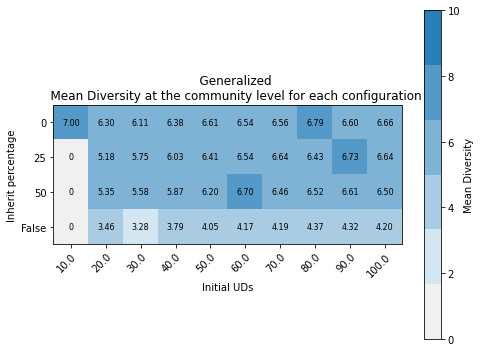

In [40]:
# heat_diversity_comm_level(GmM_datos, inherits, Gmalphas, 'Generalized', variable='Initial UDs')

# #diversity_change_graphs(GmM_datos, inherits, Gmalphas, 'Generalized', variable='Initial UDs')
# diversity_change_by_row(GmM_datos, inherits, Gmalphas, 'Generalized', variable='Initial UDs', limitant=True)

# diversity_change_by_column(GmM_datos, inherits, Gmalphas, 'Generalized', variable='Initial UDs', limitant=True)

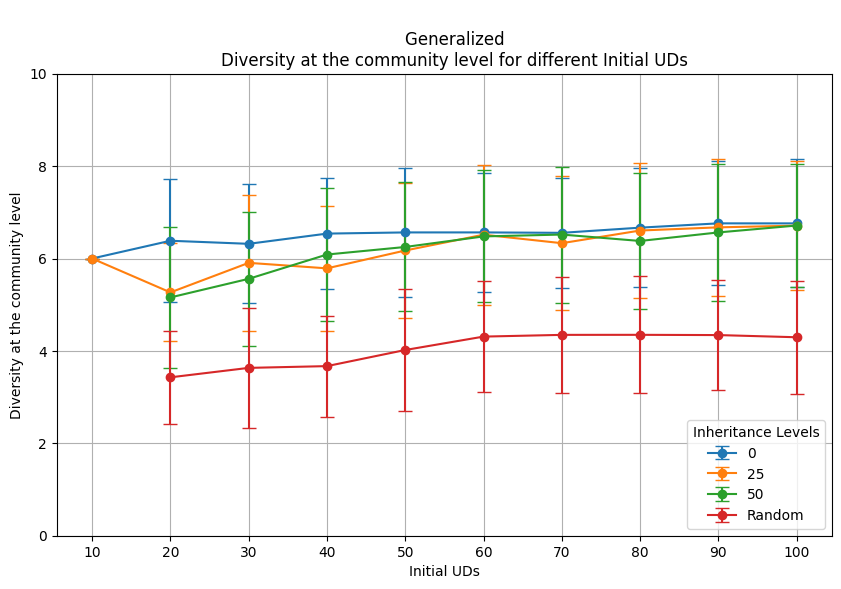

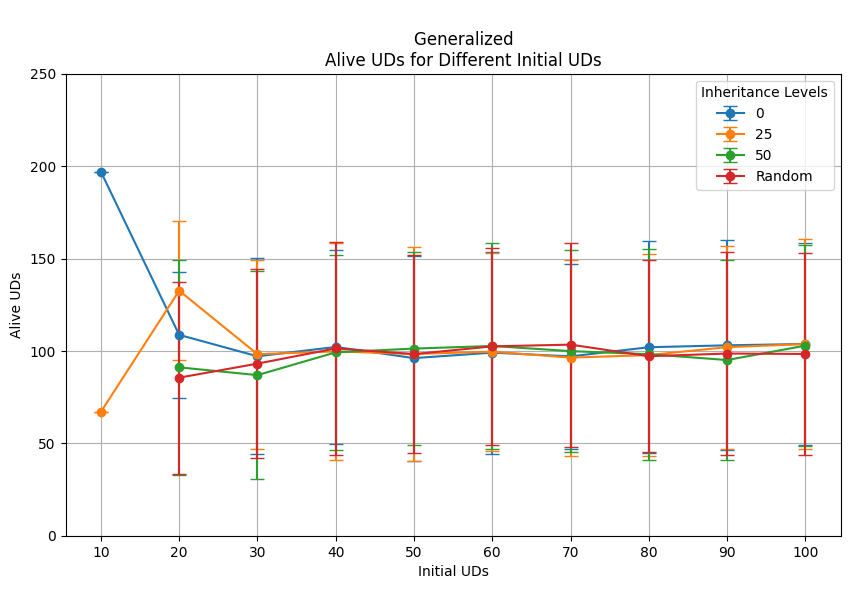

In [22]:
transversal_changes(GmM_datos, inherits, Gmalphas, 'Generalized', variable='Initial UDs')
transversal_alive(GmM_datos, inherits, Gmalphas, 'Generalized', variable='Initial UDs')

## Pop dynamics

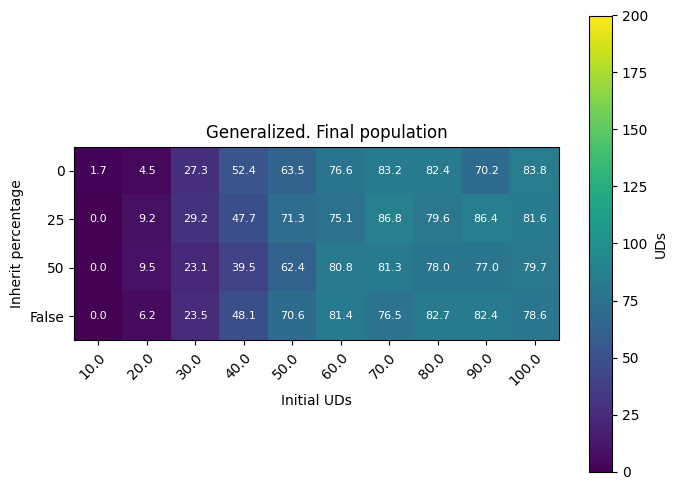

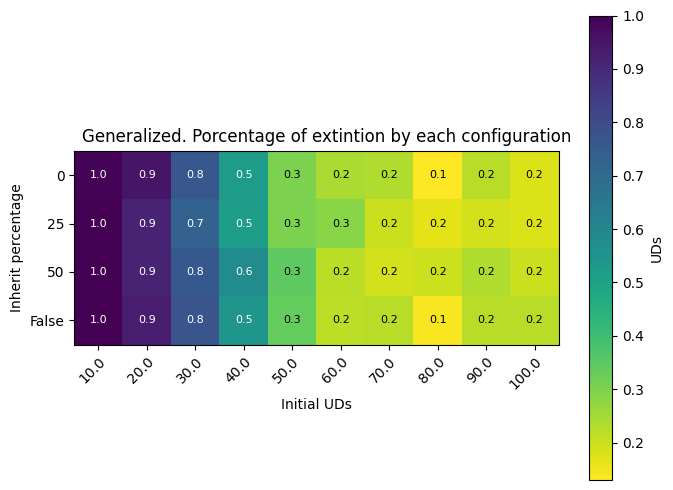

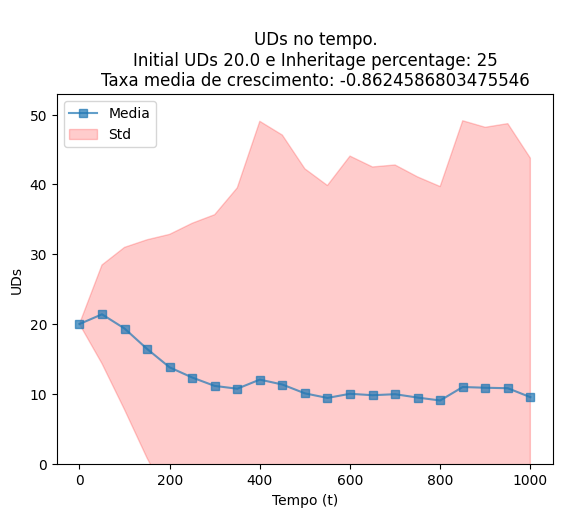

In [13]:
heat_population(GmM_datos, inherits, Gmalphas, 'Generalized', variable='Initial UDs')

heat_percentage_population(GmM_datos, inherits, Gmalphas, 'Generalized', variable='Initial UDs')

plot_specific_alivegraph(1, 1, GmM_datos, inherits, Gmalphas, 'Generalized', variable='Initial UDs')

## Initial Varieties

Here we try with different values for the initial varieties in the system.
We go from 10 to 100.

In [ ]:
# This experiment has different values for Initial varieties VVVV
prob_morte = 0.06 #beta
media = 4 # Mean
m = 40
v = 100 # Initial varieties
inherits = [0,25,50, 'False']
# inherits = [0,25,50] #Values for inherit
#inherits = ['False'] #Values for inherit
Dvalphas = np.linspace(10,v,int(v/10)) # Initial Varieties: from 10 to v
# For data of behaviour
vM = np.empty((len(inherits), len(Dvalphas)), dtype=object) # alive, mean and diversity levels

punto_vista = 50
tiempo = 1000
tempo = list(range(0,tiempo+1,punto_vista))
experiments = 100
max_iterations = 400 


print(vM.shape)
start = time.time()
print(f"started at:  {datetime.now()}")
for i, inherit in enumerate(inherits):
    for j, varieties  in enumerate(Dvalphas):
        star_configuration = time.time()
        #For population dynamics
        list_alive_UDs = []
        list_vivas_puntos_vista = []
        tasas_crecimiento = []
        #For diversity dynamics
        data_step_mean_var_ud = []
        data_step_var_system = []
        data_step_unique_system = []
        print(f"Experiments with inheritance {inherit} Initial UDs {m} and Initial varieties {varieties}")
        #Lists to store experiments' diversity data
        data_endo_mean_ud = []
        data_endo_com_level = []
        data_endo_total_varieties = []
        original_media = media
        #To see how frequent goes to extintion
        contador = 0
        iterations = 0
        while contador < experiments and iterations < max_iterations:
        #for experiment in range(1, experiments+1):
            print(f'experimento {contador+1}')
            #### Initialization generalized_exchange
            ## Clans
            clans = (list(range(1, 4)) * (m // 3 + 1))[:m] # Just 3 clans
            random.shuffle(clans)
            if inherit != 'False':    
                #### Initialization
                UD_generalized.uds = {}
                instancias_ud = []
                for id_ud in range(1, int(m) + 1):
                    instancias_ud.append(UD_generalized(id_ud, media, clans.pop()))
                ## Varieties
                limited_varieties = True
                if limited_varieties == False:
                    for id_ud, ud in UD_generalized.uds.items():
                        for _ in range(3):
                            ud.varieties.append(Variety())
                else:
                    initial_varieties = [Variety() for _ in range (int(varieties))]
                    for ud in UD_generalized.uds.values():
                        for _ in range(3):
                            ud.varieties.append(random.choice(initial_varieties))   
                # Lists for graphs
                vivas_puntos_vista = [int(m)]
                vivas_tasa_crecimiento = [int(m)]
        #             mortas_puntos_vista = [0]
                #For diversity
                mean_var_ud = []
                var_system = []
                unique_system = []
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_generalized.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                # Simulation
                for t in range(1, tiempo):
                    uds_copy = {id_ud: ud for id_ud, ud in UD_generalized.uds.items() if ud.activa}
                    items = list(uds_copy.items())
                    random.shuffle(items)
                    uds_copy = dict(items)
                    alive = len(uds_copy)
                    if alive > 200 and (media == original_media):
                        media -= media//2
                        if media >= 4:
                            media = media //2
                    elif alive < 150 and media < original_media:
                        media = original_media
                    if not uds_copy: #Extintion
                        # Only 0
                        print(f"acabó en 0 el experimento {contador+1} con herencia {inherits[i]} con unidades {Dvalphas[j]}")
                        break         
                    # Cycle:
                    for id_ud, ud in uds_copy.items():
                        ud.ter_filho()
                        ud.buscar_ud(uds_copy, int(media), inherit, True, 0.2)
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
                    # Collecting data
                    vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                    if t % punto_vista == 0:
                        viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                        #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                        vivas_puntos_vista.append(viv)
                        # For diversity
                        var_ud = []
                        var_total = []
                        for ud in [ud for ud in UD_generalized.uds.values() if ud.activa ==True]:
                            var_ud.append(len(ud.varieties))
                            for variety in ud.varieties:
                                var_total.append(variety.variety_id)
                        mean_var_ud.append(np.mean(var_ud))
                        var_system.append(len(var_total))
                        unique_system.append(len(set(var_total))) 
                viv = len([ud for id, ud in UD_generalized.uds.items() if ud.activa])
                vivas_puntos_vista.append(viv)
                # For diversity
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_generalized.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                alive = (len([ud for id, ud in uds_copy.items() if ud.activa]))
                if alive >= 1:   
                    total_varieties = []
                    varieties_per_UD = []
                    for ud in [ud for ud in UD_generalized.uds.values() if ud.activa ==True]:
                        varieties_per_UD.append(len(ud.varieties))
                        for variety in ud.varieties:
                            total_varieties.append(variety.variety_id)
                    data_endo_mean_ud.append(np.mean(varieties_per_UD))
                    data_endo_com_level.append(len(set(total_varieties)))
                    data_endo_total_varieties.append(total_varieties)
            
            else:# Now with inherit == False
                #### Initialization
                UD_generalized_al_inh.uds = {}
                instancias_ud = []
                for id_ud in range(1, int(m) + 1):
                    instancias_ud.append(UD_generalized_al_inh(id_ud, media, clans.pop()))
                ## Varieties
                limited_varieties = True
                if limited_varieties == False:
                    for id_ud, ud in UD_generalized_al_inh.uds.items():
                        for _ in range(3):
                            ud.varieties.append(Variety())
                else:
                    initial_varieties = [Variety() for _ in range (int(varieties))]
                    for ud in UD_generalized_al_inh.uds.values():
                        for _ in range(3):
                            ud.varieties.append(random.choice(initial_varieties))   
                # Lists for graphs
                vivas_puntos_vista = [int(m)]
                vivas_tasa_crecimiento = [int(m)]
        #             mortas_puntos_vista = [0]
                #For diversity
                mean_var_ud = []
                var_system = []
                unique_system = []
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_generalized_al_inh.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                # Simulation
                for t in range(1, tiempo):
                    uds_copy = {id_ud: ud for id_ud, ud in UD_generalized_al_inh.uds.items() if ud.activa}
                    items = list(uds_copy.items())
                    random.shuffle(items)
                    uds_copy = dict(items)
                    alive = len(uds_copy)
                    if alive > 200 and (media == original_media):
                        media -= media//2
                        if media >= 4:
                            media = media //2
                    elif alive < 150 and media < original_media:
                        media = original_media
                    if not uds_copy: #Extintion
                        # Only 0
                        print(f"acabó en 0 el experimento {contador+1} con herencia {inherits[i]} con unidades {Dvalphas[j]}")
                        break         
                    # Cycle:
                    varieties_list = [var for ud in uds_copy.values() for var in ud.varieties]
                    for id_ud, ud in uds_copy.items():
                        ud.ter_filho()
                        ud.buscar_ud(uds_copy, int(media), varieties_list, True, 3, 0.2)
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
                    # Collecting data
                    vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                    if t % punto_vista == 0:
                        viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                        #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                        vivas_puntos_vista.append(viv)
                        # For diversity
                        var_ud = []
                        var_total = []
                        for ud in [ud for ud in UD_generalized_al_inh.uds.values() if ud.activa ==True]:
                            var_ud.append(len(ud.varieties))
                            for variety in ud.varieties:
                                var_total.append(variety.variety_id)
                        mean_var_ud.append(np.mean(var_ud))
                        var_system.append(len(var_total))
                        unique_system.append(len(set(var_total))) 
                viv = len([ud for id, ud in UD_generalized_al_inh.uds.items() if ud.activa])
                vivas_puntos_vista.append(viv)
                # For diversity
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_generalized_al_inh.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                alive = (len([ud for id, ud in uds_copy.items() if ud.activa]))
                if alive >= 1:   
                    total_varieties = []
                    varieties_per_UD = []
                    for ud in [ud for ud in UD_generalized_al_inh.uds.values() if ud.activa ==True]:
                        varieties_per_UD.append(len(ud.varieties))
                        for variety in ud.varieties:
                            total_varieties.append(variety.variety_id)
                    data_endo_mean_ud.append(np.mean(varieties_per_UD))
                    data_endo_com_level.append(len(set(total_varieties)))
                    data_endo_total_varieties.append(total_varieties)
            
            
            # Final collection of the data after the simulation!
            if len(uds_copy) > 0:  # Only collect data if the system is alive
                list_alive_UDs.append(len([ud for id, ud in uds_copy.items() if ud.activa == True]))  # For heatmap
                list_vivas_puntos_vista.append(vivas_puntos_vista)
                data_step_var_system.append(var_system)
                data_step_unique_system.append(unique_system)
                data_step_mean_var_ud.append(mean_var_ud)
                contador += 1
            iterations += 1
            print('succesful')
            print(contador)
            print('iterations')
            print(iterations)   
            
            
            data_inherit_endo = [data_endo_mean_ud, data_endo_com_level, data_endo_total_varieties]
        data_steps_inherit_endo = [data_step_var_system, data_step_unique_system, data_step_mean_var_ud]
        media = original_media
        end_config = time.time()
        if contador == experiments: 
            vM[i][j] = {
                'alive': np.mean(list_alive_UDs),
                'lstd': np.std(list_alive_UDs),
                'time used': end_config - star_configuration,
                'percentage_extinction': contador / experiments,
                'tempo': tempo, 
                'mean': np.mean(list_vivas_puntos_vista, axis=0), 
                'std': np.std(list_vivas_puntos_vista, axis=0),
                'growth rate': np.mean([np.mean(lista) for lista in tasas_crecimiento]),
                'diversity_info': data_inherit_endo,
                'diversity_info_steps': data_steps_inherit_endo,
            }
        else:  # Handle extinction-only scenarios
            vM[i][j] = {
                'alive': None,
                'lstd': None,
                'time used': end_config - star_configuration,
                'percentage_extinction': 1.0,  # All experiments went extinct
                'tempo': None, 
                'mean': None, 
                'std': None,
                'growth rate': None,
                'diversity_info': None,
                'diversity_info_steps': None,
            }
        print(f"""
The total time of the configuration of inherit percentage {inherit}, 
  initial UDs {m} and Initial varieties {varieties} is  {end_config - star_configuration}
        """)
# Folder
folder_name = 'Experiments_kinship_inheritance_parameters'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Heatmap and std
heat_std = os.path.join(folder_name, 'Generalized_Initial_Varieties.npy')
np.save(heat_std, vM)
now = datetime.now()
finish = time.time()
print(f"""
It finished at: {now}
It lasted {finish-start}
""")
print("done")

In [23]:
# Dowload the documents
#As a reference
v = 100
inherits = [0,25,50, 'False']#Values for inherit
# inherits = [0, 'False'] #Values for inherit
Dvalphas = np.linspace(10,v,int(v/10)) # Initial UDs: from 10 to m
punto_vista = 50
tiempo = 100
tempo = list(range(0,tiempo+1,punto_vista))

#Folders
folder_name = 'Experiments_kinship_inheritance_parameters'
heat_std = os.path.join(folder_name, 'Generalized_Initial_Varieties.npy')
## heatmap and mean
DvM_datos = np.load(heat_std, allow_pickle=True)

## Diversity dynamics

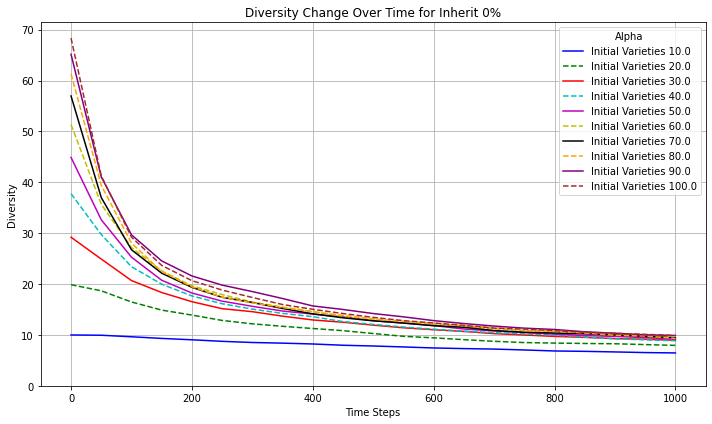

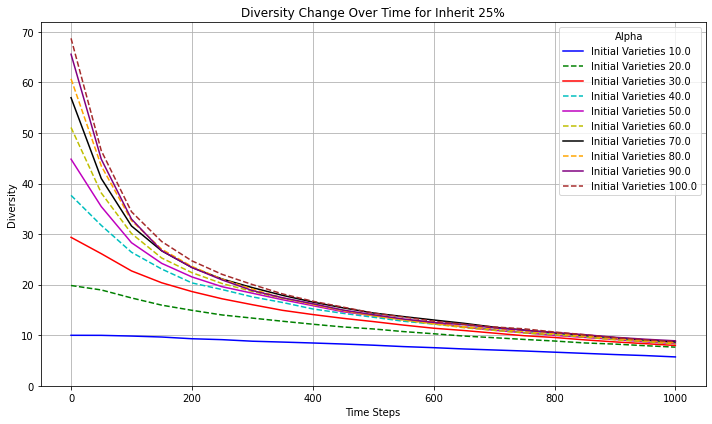

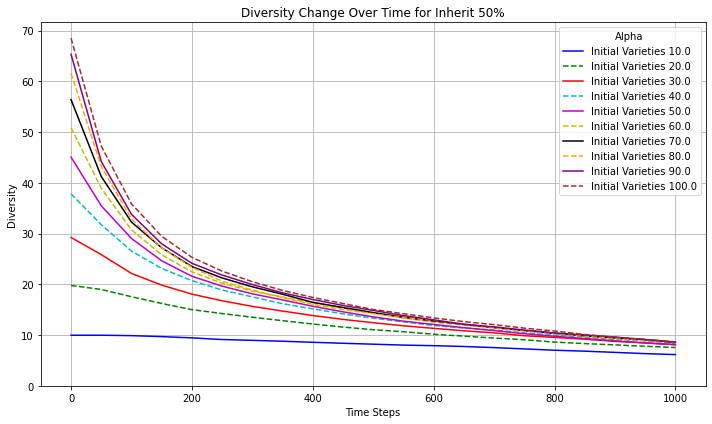

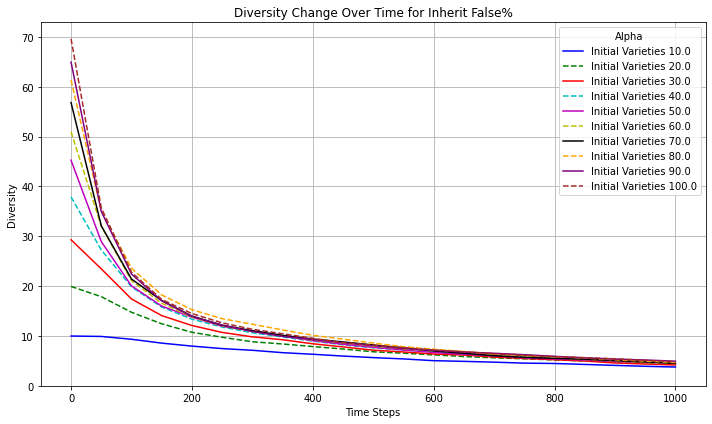

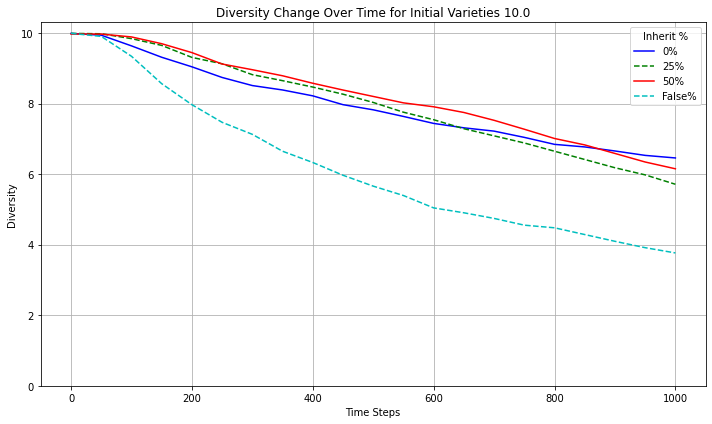

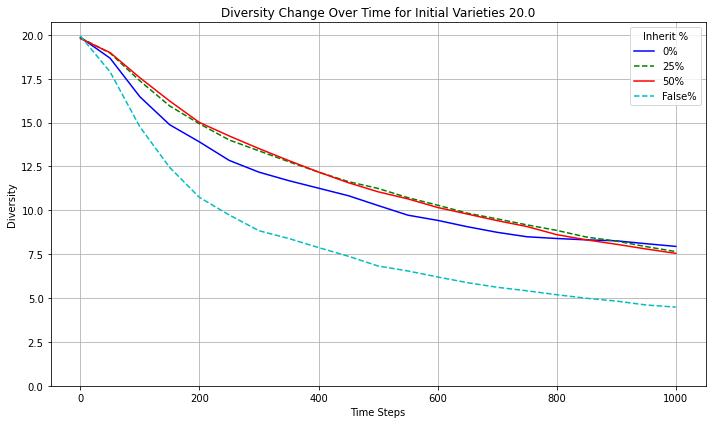

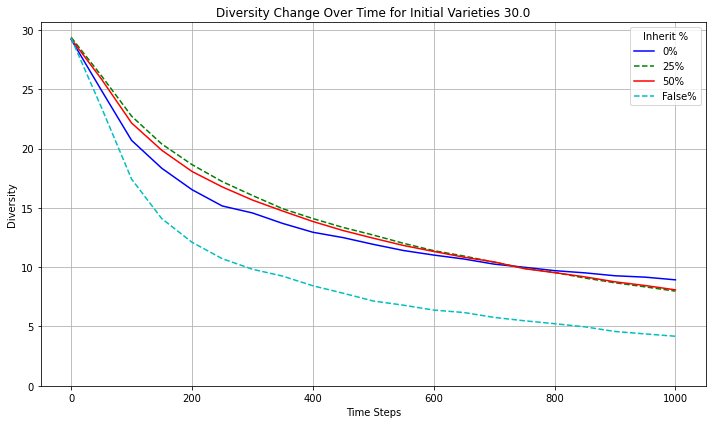

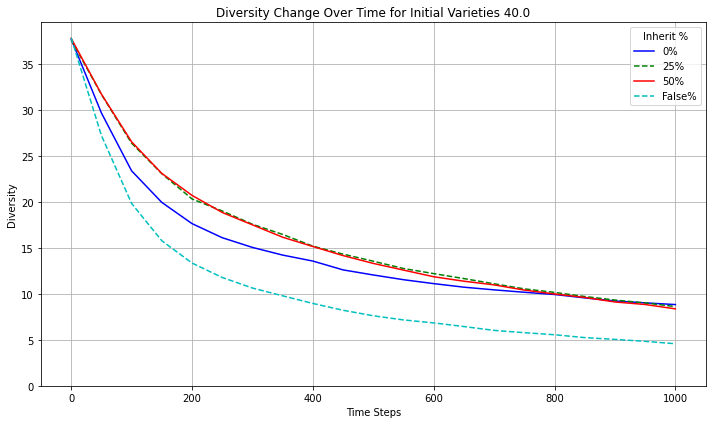

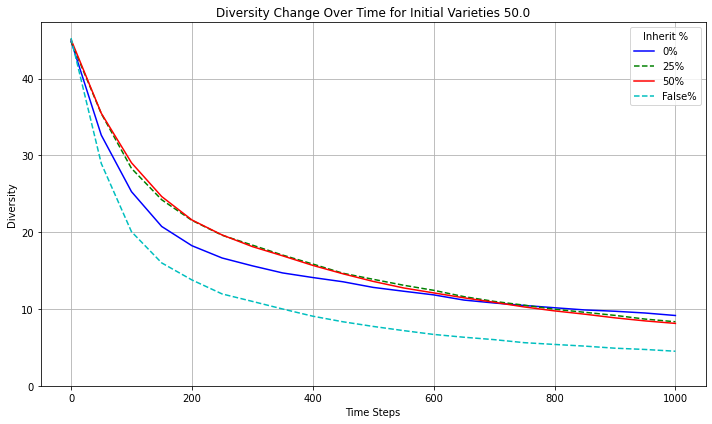

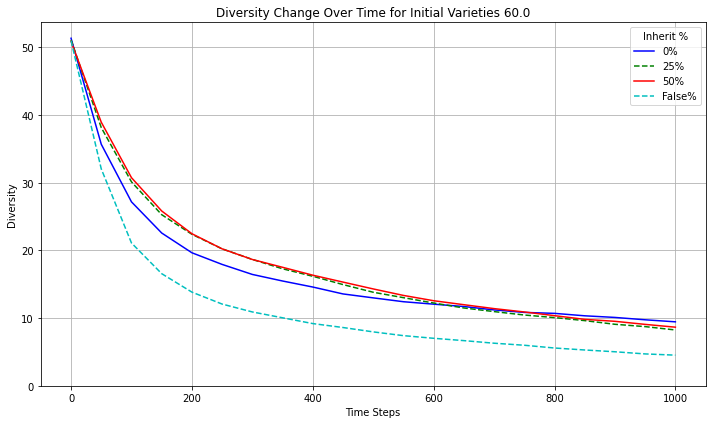

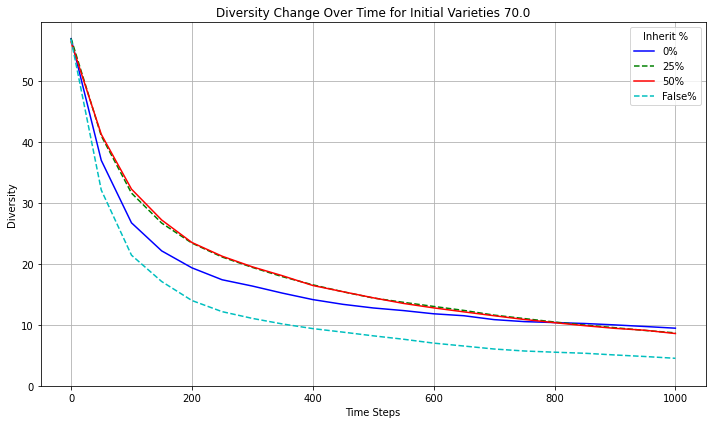

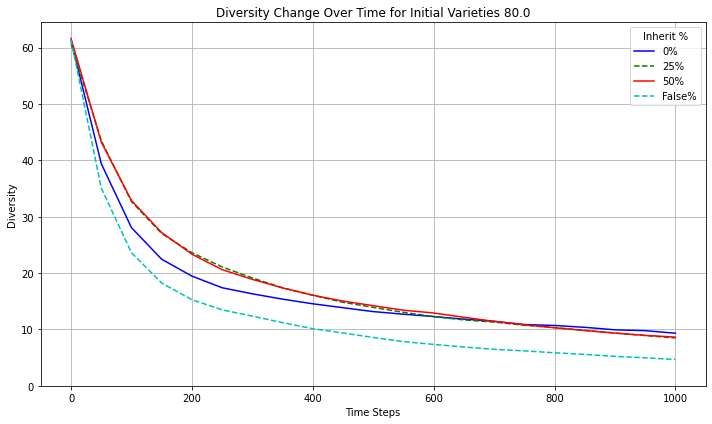

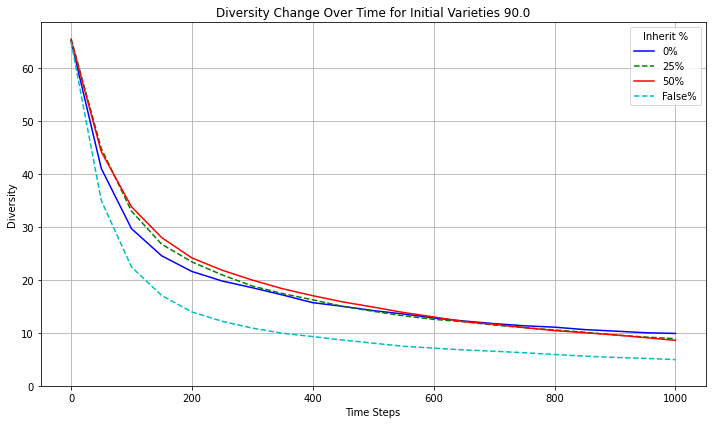

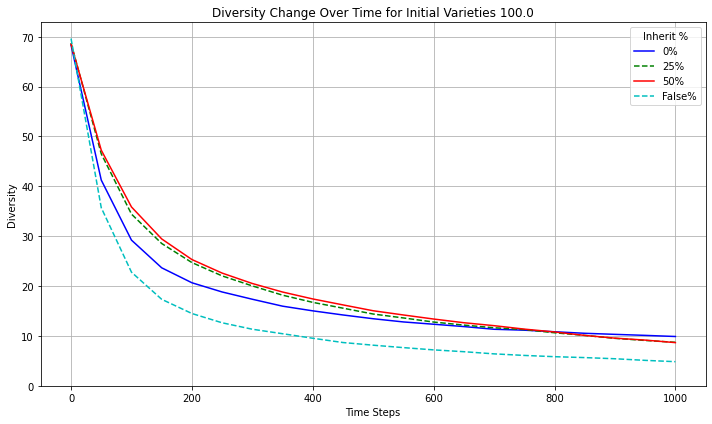

In [38]:
#heat_diversity_comm_level(DvM_datos, inherits, Dvalphas, 'Generalized', variable='Initial Varieties')
#diversity_change_graphs(DvM_datos, inherits, Dvalphas, 'Generalized', variable='Initial Varieties', limitant = True)
#diversity_change_by_row(DvM_datos, inherits, Dvalphas, 'Generalized', variable='Initial Varieties', limitant = True)
#diversity_change_by_column(DvM_datos, inherits, Dvalphas, 'Generalized', variable='Initial Varieties', limitant = True)

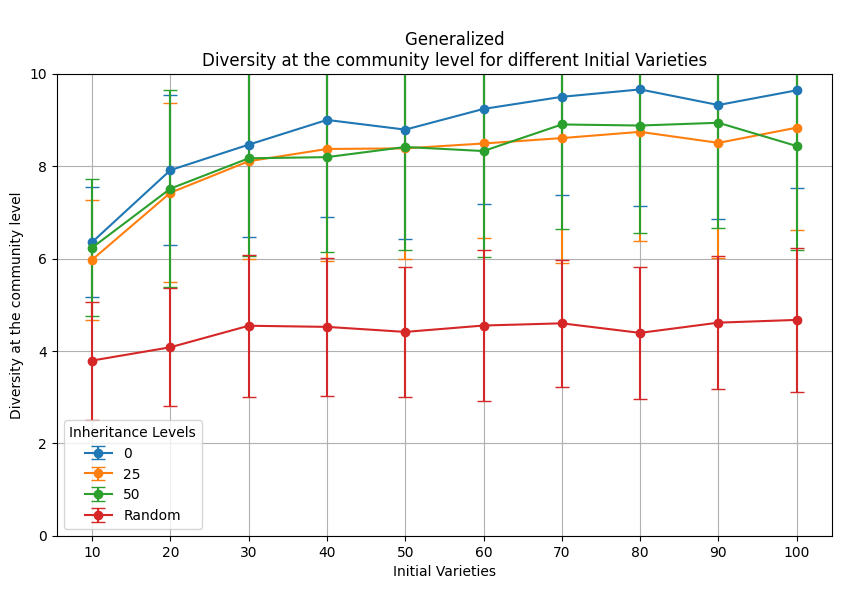

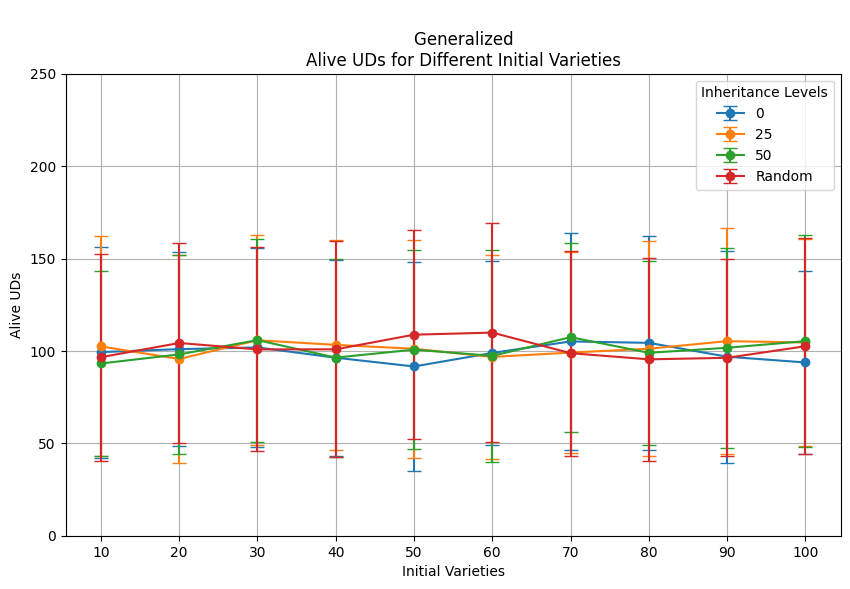

In [24]:
transversal_changes(DvM_datos, inherits, Dvalphas, 'Generalized', variable='Initial Varieties')
transversal_alive(DvM_datos, inherits, Dvalphas, 'Generalized', variable='Initial Varieties')

## Pop dynamics

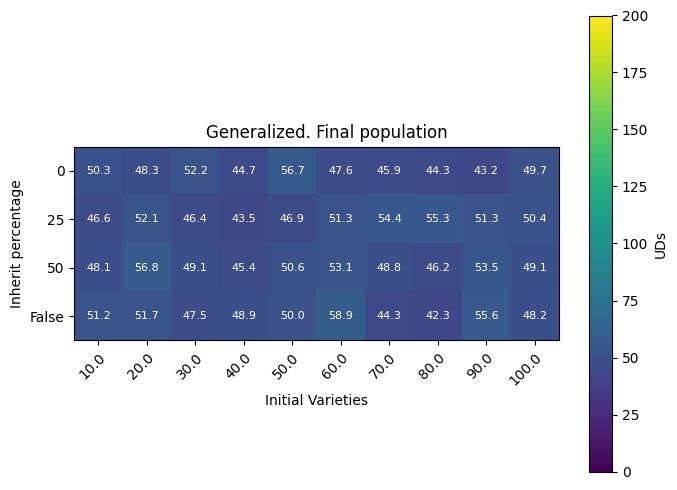

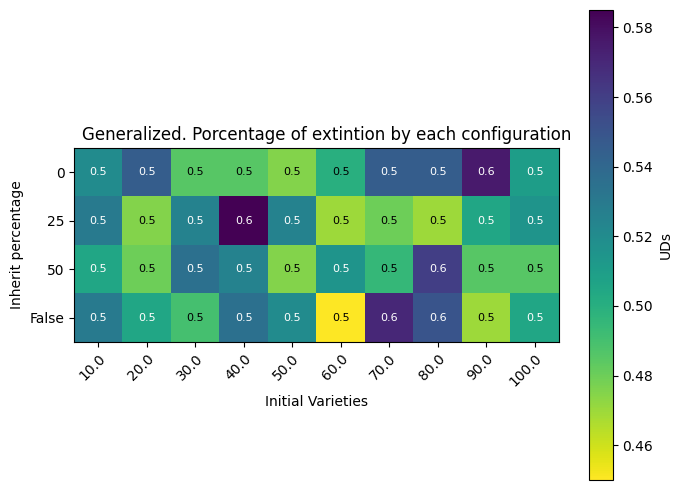

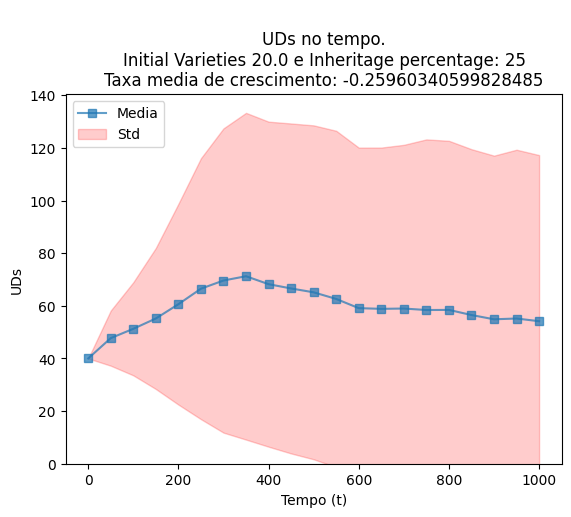

In [15]:
heat_population(DvM_datos, inherits, Dvalphas, 'Generalized', variable='Initial Varieties')
heat_percentage_population(DvM_datos, inherits, Dvalphas, 'Generalized', variable='Initial Varieties')
plot_specific_alivegraph(1, 1, DvM_datos, inherits, Dvalphas, 'Generalized', variable='Initial Varieties')

## Mean of children

In [ ]:
# This experiment has different values for Mean of children
prob_morte = 0.06 #beta
n = 10 # Mean
m = 40 # Initial UDs
iniciais = m
inherits = [0,25,50, 'False']
#inherits = ['False']
Gcalphas = np.linspace(1,n,n) # Mean of children from 1 to n
# For data of behaviour
cM = np.empty((len(inherits), len(Gcalphas)), dtype=object) # alive, mean and diversity levels

punto_vista = 50
tiempo = 1000
tempo = list(range(0,tiempo+1,punto_vista))
experiments = 100
max_iterations = 400


print(cM.shape)
start = time.time()
print(f"started at:  {datetime.now()}")
for i, inherit in enumerate(inherits):
    for j, media  in enumerate(Gcalphas):
        star_configuration = time.time()
        #For population dynamics
        list_alive_UDs = []
        list_vivas_puntos_vista = []
        tasas_crecimiento = []
        #For diversity dynamics
        data_step_mean_var_ud = []
        data_step_var_system = []
        data_step_unique_system = []
        print(f"Experiments with inheritance {inherit} and Mean of Children {media}")
        #Lists to store experiments' diversity data
        data_endo_mean_ud = []
        data_endo_com_level = []
        data_endo_total_varieties = []
        original_media = media
        #To see how frequent goes to extintion
        contador = 0
        iterations = 0
        while contador < experiments and iterations < max_iterations: 
        #for experiment in range(1, experiments+1):
            print(f'experimento {contador+1}')
            ## Clans
            clans = (list(range(1, 4)) * (int(iniciais) // 3 + 1))[:int(iniciais)] # Just 3 clans
            random.shuffle(clans)
            if inherit != 'False':
                #### Initialization
                UD_generalized.uds = {}
                instancias_ud = []
                for id_ud in range(1, int(m) + 1):
                    instancias_ud.append(UD_generalized(id_ud, media, clans.pop()))
                ## Varieties
                limited_varieties = True
                if limited_varieties == False:
                    for id_ud, ud in UD_generalized.uds.items():
                        for _ in range(3):
                            ud.varieties.append(Variety())
                else:
                    initial_varieties = [Variety() for _ in range (10)]
                    for ud in UD_generalized.uds.values():
                        for _ in range(3):
                            ud.varieties.append(random.choice(initial_varieties))   
                # Lists for graphs
                vivas_puntos_vista = [int(m)]
                vivas_tasa_crecimiento = [int(m)]
        #             mortas_puntos_vista = [0]
                #For diversity
                mean_var_ud = []
                var_system = []
                unique_system = []
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_generalized.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                # Simulation
                for t in range(1, tiempo):
                    uds_copy = {id_ud: ud for id_ud, ud in UD_generalized.uds.items() if ud.activa}
                    items = list(uds_copy.items())
                    random.shuffle(items)
                    uds_copy = dict(items)
                    alive = len(uds_copy)
                    if alive > 200 and (media == original_media):
                        media -= media//2
                        if media >= 4:
                            media = media //2
                    elif alive < 150 and media < original_media:
                        media = original_media
                    if not uds_copy: #Extintion
                        # Only 0
                        print(f"acabó en 0 el experimento {contador+1} con herencia {inherits[i]} con mean {Gcalphas[j]}")
                        break         
                    # Cycle:
                    for id_ud, ud in uds_copy.items():
                        ud.ter_filho()
                        ud.buscar_ud(uds_copy, int(media), inherit, True, 0.2)
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
                    # Collecting data
                    vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                    if t % punto_vista == 0:
                        viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                        #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                        vivas_puntos_vista.append(viv)
                        # For diversity
                        var_ud = []
                        var_total = []
                        for ud in [ud for ud in UD_generalized.uds.values() if ud.activa ==True]:
                            var_ud.append(len(ud.varieties))
                            for variety in ud.varieties:
                                var_total.append(variety.variety_id)
                        mean_var_ud.append(np.mean(var_ud))
                        var_system.append(len(var_total))
                        unique_system.append(len(set(var_total))) 
                viv = len([ud for id, ud in UD_generalized.uds.items() if ud.activa])
                vivas_puntos_vista.append(viv)
                # For diversity
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_generalized.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                alive = (len([ud for id, ud in uds_copy.items() if ud.activa]))
                if alive >= 1:   
                    total_varieties = []
                    varieties_per_UD = []
                    for ud in [ud for ud in UD_generalized.uds.values() if ud.activa ==True]:
                        varieties_per_UD.append(len(ud.varieties))
                        for variety in ud.varieties:
                            total_varieties.append(variety.variety_id)
                    data_endo_mean_ud.append(np.mean(varieties_per_UD))
                    data_endo_com_level.append(len(set(total_varieties)))
                    data_endo_total_varieties.append(total_varieties)
            
            else:# Now with inherit == False
                #### Initialization
                UD_generalized_al_inh.uds = {}
                instancias_ud = []
                for id_ud in range(1, int(m) + 1):
                    instancias_ud.append(UD_generalized_al_inh(id_ud, media, clans.pop()))
                ## Varieties
                limited_varieties = True
                if limited_varieties == False:
                    for id_ud, ud in UD_generalized_al_inh.uds.items():
                        for _ in range(3):
                            ud.varieties.append(Variety())
                else:
                    initial_varieties = [Variety() for _ in range (10)]
                    for ud in UD_generalized_al_inh.uds.values():
                        for _ in range(3):
                            ud.varieties.append(random.choice(initial_varieties))   
                # Lists for graphs
                vivas_puntos_vista = [int(m)]
                vivas_tasa_crecimiento = [int(m)]
        #             mortas_puntos_vista = [0]
                #For diversity
                mean_var_ud = []
                var_system = []
                unique_system = []
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_generalized_al_inh.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                # Simulation
                for t in range(1, tiempo):
                    uds_copy = {id_ud: ud for id_ud, ud in UD_generalized_al_inh.uds.items() if ud.activa}
                    items = list(uds_copy.items())
                    random.shuffle(items)
                    uds_copy = dict(items)
                    alive = len(uds_copy)
                    if alive > 200 and (media == original_media):
                        media -= media//2
                        if media >= 4:
                            media = media //2
                    elif alive < 150 and media < original_media:
                        media = original_media
                    if not uds_copy: #Extintion
                        # Only 0
                        print(f"acabó en 0 el experimento {contador+1} con herencia {inherits[i]} con mean {Gcalphas[j]}")
                        break         
                    # Cycle:
                    varieties_list = [var for ud in uds_copy.values() for var in ud.varieties]
                    for id_ud, ud in uds_copy.items():
                        ud.ter_filho()
                        ud.buscar_ud(uds_copy, int(media), varieties_list, True, 3, 0.2)
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
                    # Collecting data
                    vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                    if t % punto_vista == 0:
                        viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                        #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                        vivas_puntos_vista.append(viv)
                        # For diversity
                        var_ud = []
                        var_total = []
                        for ud in [ud for ud in UD_generalized_al_inh.uds.values() if ud.activa ==True]:
                            var_ud.append(len(ud.varieties))
                            for variety in ud.varieties:
                                var_total.append(variety.variety_id)
                        mean_var_ud.append(np.mean(var_ud))
                        var_system.append(len(var_total))
                        unique_system.append(len(set(var_total))) 
                viv = len([ud for id, ud in UD_generalized_al_inh.uds.items() if ud.activa])
                vivas_puntos_vista.append(viv)
                # For diversity
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_generalized_al_inh.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                alive = (len([ud for id, ud in uds_copy.items() if ud.activa]))
                if alive >= 1:   
                    total_varieties = []
                    varieties_per_UD = []
                    for ud in [ud for ud in UD_generalized_al_inh.uds.values() if ud.activa ==True]:
                        varieties_per_UD.append(len(ud.varieties))
                        for variety in ud.varieties:
                            total_varieties.append(variety.variety_id)
                    data_endo_mean_ud.append(np.mean(varieties_per_UD))
                    data_endo_com_level.append(len(set(total_varieties)))
                    data_endo_total_varieties.append(total_varieties)
            
            
            # Final collection of the data after the simulation!
            if len(uds_copy) > 0:  # Only collect data if the system is alive
                list_alive_UDs.append(len([ud for id, ud in uds_copy.items() if ud.activa == True]))  # For heatmap
                list_vivas_puntos_vista.append(vivas_puntos_vista)
                data_step_var_system.append(var_system)
                data_step_unique_system.append(unique_system)
                data_step_mean_var_ud.append(mean_var_ud)
                contador += 1
            iterations += 1
            print('succesful', contador)
            print('iterations', iterations)            
            
            data_inherit_endo = [data_endo_mean_ud, data_endo_com_level, data_endo_total_varieties]
        data_steps_inherit_endo = [data_step_var_system, data_step_unique_system, data_step_mean_var_ud]
        media = original_media
        end_config = time.time()
        if contador == experiments:  # Check if there's valid data (i.e., the system survived)
            cM[i][j] = {
                'alive': np.mean(list_alive_UDs),
                'lstd': np.std(list_alive_UDs),
                'time used': end_config - star_configuration,
                'percentage_extinction': contador / experiments,
                'tempo': tempo, 
                'mean': np.mean(list_vivas_puntos_vista, axis=0), 
                'std': np.std(list_vivas_puntos_vista, axis=0),
                'growth rate': np.mean([np.mean(lista) for lista in tasas_crecimiento]),
                'diversity_info': data_inherit_endo,
                'diversity_info_steps': data_steps_inherit_endo,
            }
        else:  # Handle extinction-only scenarios
            cM[i][j] = {
                'alive': None,
                'lstd': None,
                'time used': end_config - star_configuration,
                'percentage_extinction': 1.0,  # All experiments went extinct
                'tempo': None, 
                'mean': None, 
                'std': None,
                'growth rate': None,
                'diversity_info': None,
                'diversity_info_steps': None,
            }
        print(f"""
The total time of the configuration of inherit percentage {inherit} and initial UDs {m} and mean {media} is  {end_config - star_configuration}
        """)
# Folder
folder_name = 'Experiments_kinship_inheritance_parameters'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Data
heat_std = os.path.join(folder_name, 'Generalized_Mean_children.npy')
np.save(heat_std, cM)
now = datetime.now()
finish = time.time()
print(f"""
It finished at: {now}
It lasted {finish-start}
""")
print("done")

In [25]:
# Dowload the documents
#As a reference
n = 10 # Mean
# m = 40 # Initial UDs
inherits = [0,25,50, 'False']
Gcalphas = np.linspace(1,n,n) # Mean of children from 1 to n
punto_vista = 50
tiempo = 1000
tempo = list(range(0,tiempo+1,punto_vista))

#Folders
folder_name = 'Experiments_kinship_inheritance_parameters'
heat_std = os.path.join(folder_name, 'Generalized_Mean_children.npy')

## General Data
GcM_datos = np.load(heat_std, allow_pickle=True)

## Diversity dynamics

Skipping Inherit 0%, Mean of Children 1.0 due to no data
Skipping Inherit 0%, Mean of Children 2.0 due to no data
Skipping Inherit 0%, Mean of Children 3.0 due to no data


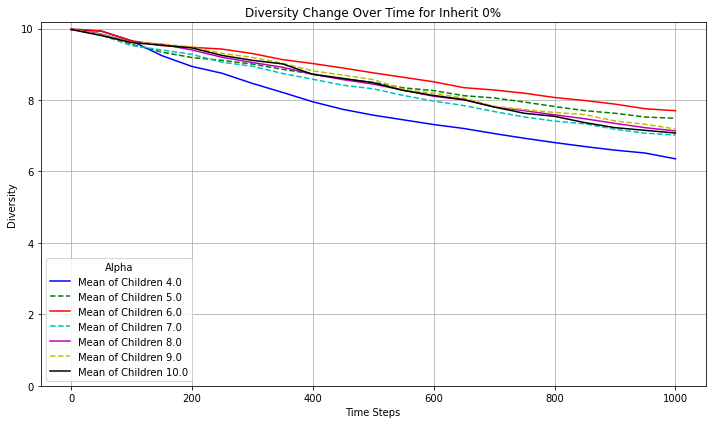

Skipping Inherit 25%, Mean of Children 1.0 due to no data
Skipping Inherit 25%, Mean of Children 2.0 due to no data
Skipping Inherit 25%, Mean of Children 3.0 due to no data


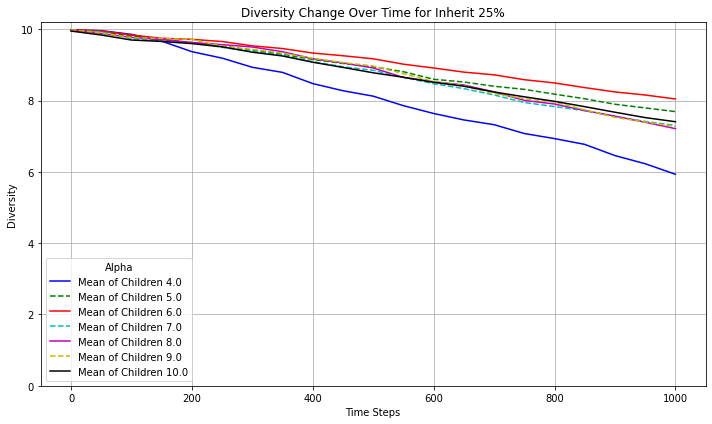

Skipping Inherit 50%, Mean of Children 1.0 due to no data
Skipping Inherit 50%, Mean of Children 2.0 due to no data
Skipping Inherit 50%, Mean of Children 3.0 due to no data


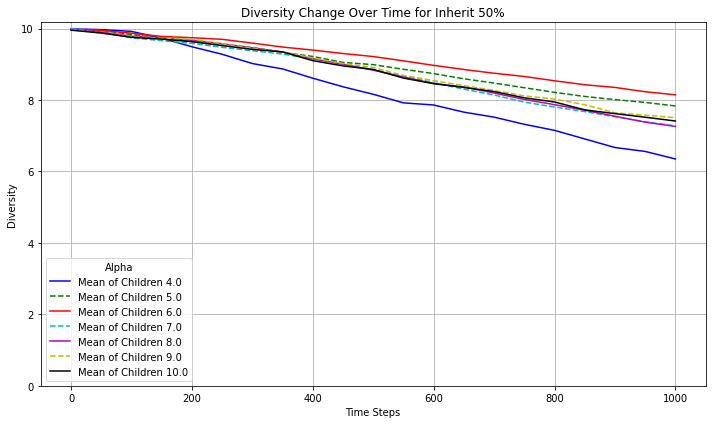

Skipping Inherit False%, Mean of Children 1.0 due to no data
Skipping Inherit False%, Mean of Children 2.0 due to no data
Skipping Inherit False%, Mean of Children 3.0 due to no data


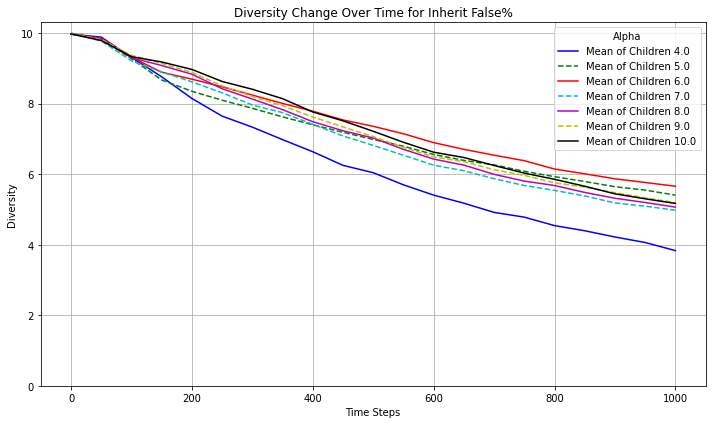

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Skipping Inherit 0%, Mean of Children 1.0 due to no data
Skipping Inherit 25%, Mean of Children 1.0 due to no data
Skipping Inherit 50%, Mean of Children 1.0 due to no data
Skipping Inherit False%, Mean of Children 1.0 due to no data


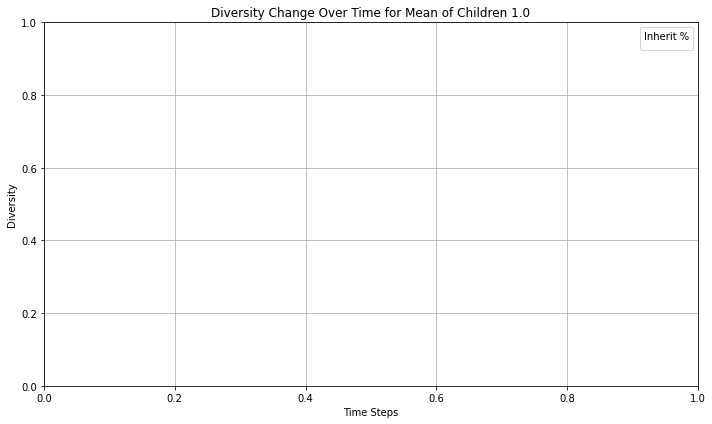

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Skipping Inherit 0%, Mean of Children 2.0 due to no data
Skipping Inherit 25%, Mean of Children 2.0 due to no data
Skipping Inherit 50%, Mean of Children 2.0 due to no data
Skipping Inherit False%, Mean of Children 2.0 due to no data


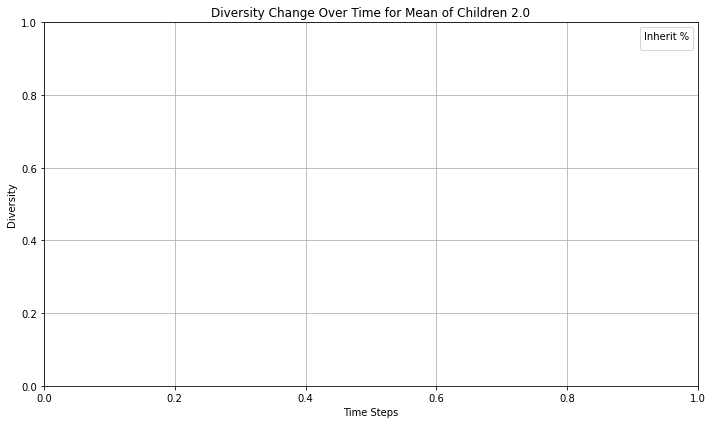

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Skipping Inherit 0%, Mean of Children 3.0 due to no data
Skipping Inherit 25%, Mean of Children 3.0 due to no data
Skipping Inherit 50%, Mean of Children 3.0 due to no data
Skipping Inherit False%, Mean of Children 3.0 due to no data


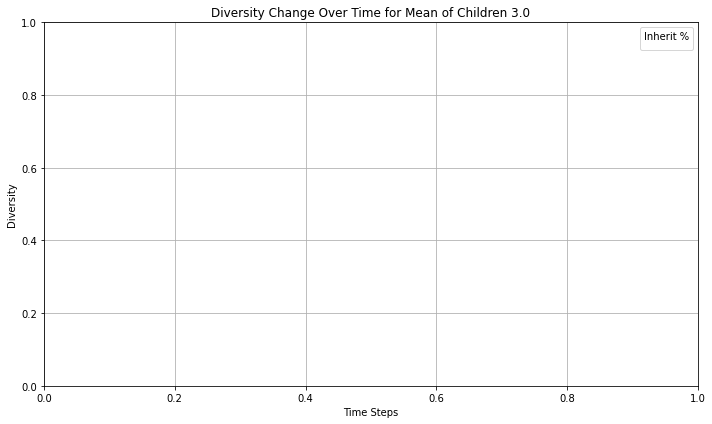

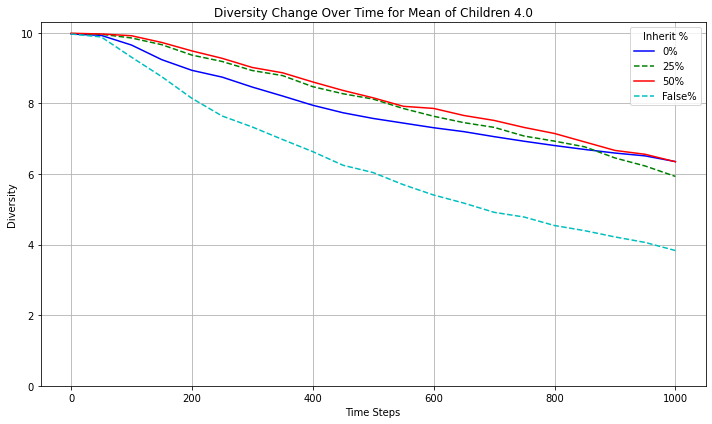

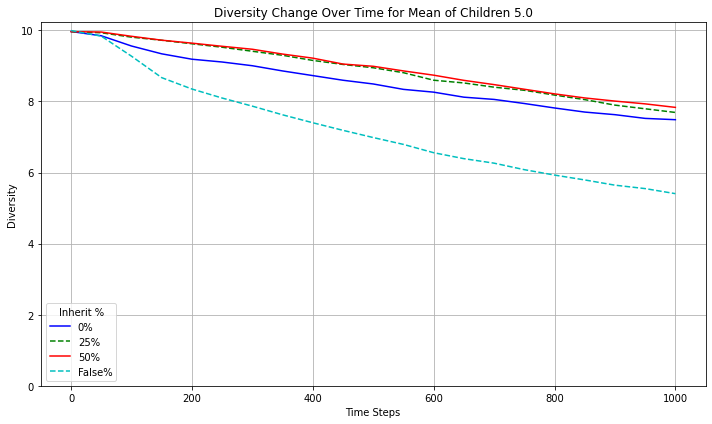

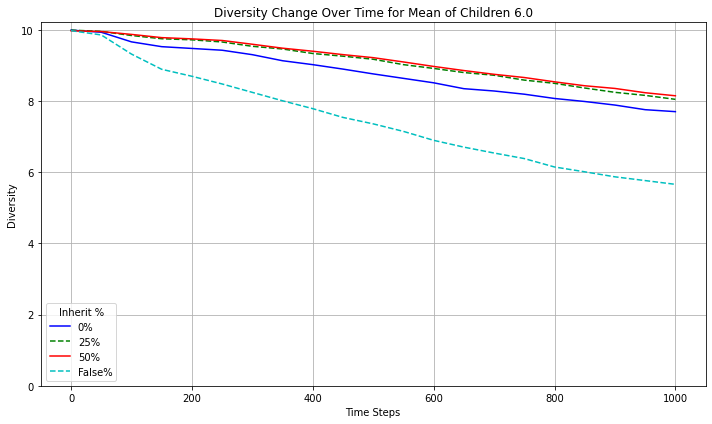

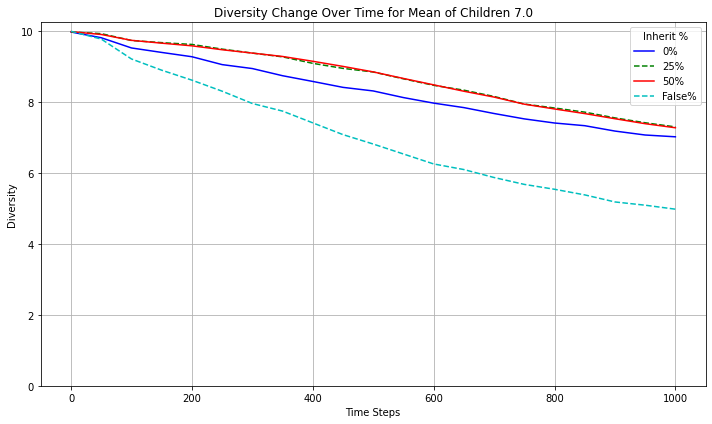

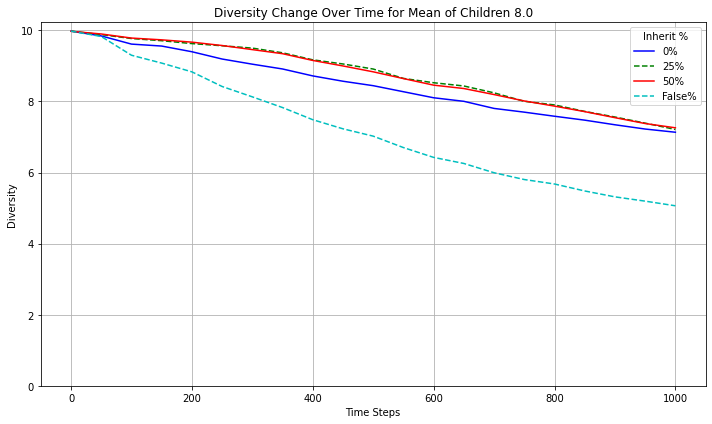

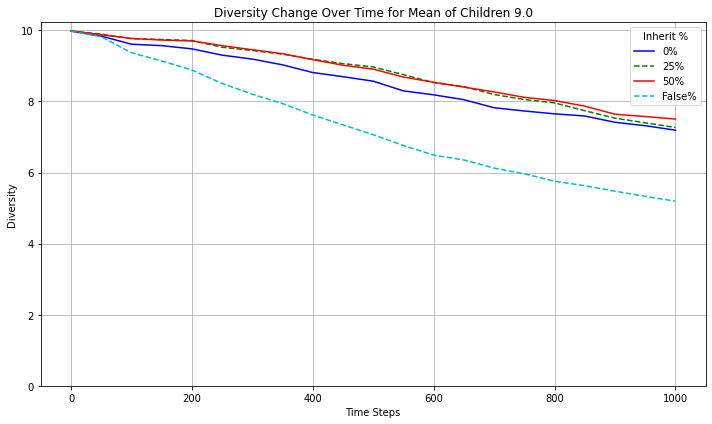

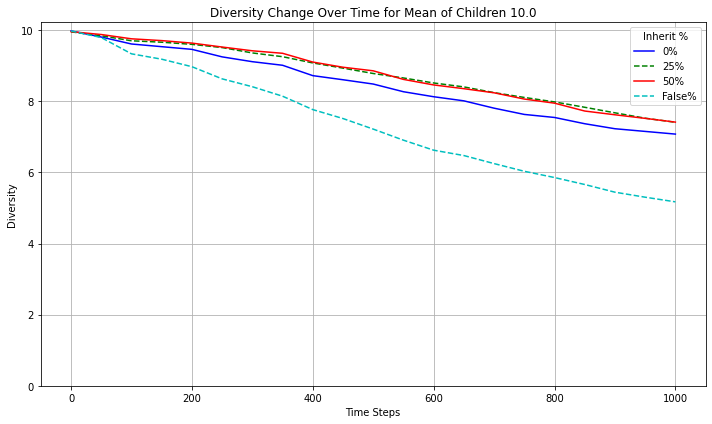

In [42]:
#heat_diversity_comm_level(GcM_datos, inherits, Gcalphas, 'Generalized', variable='Mean of Children')
#diversity_change_graphs(GcM_datos, inherits, Gcalphas, 'Generalized', variable='Mean of Children', limitant = True)
#diversity_change_by_row(GcM_datos, inherits, Gcalphas, 'Generalized', variable='Mean of Children', limitant = True)
#diversity_change_by_column(GcM_datos, inherits, Gcalphas, 'Generalized', variable='Mean of Children', limitant = True)

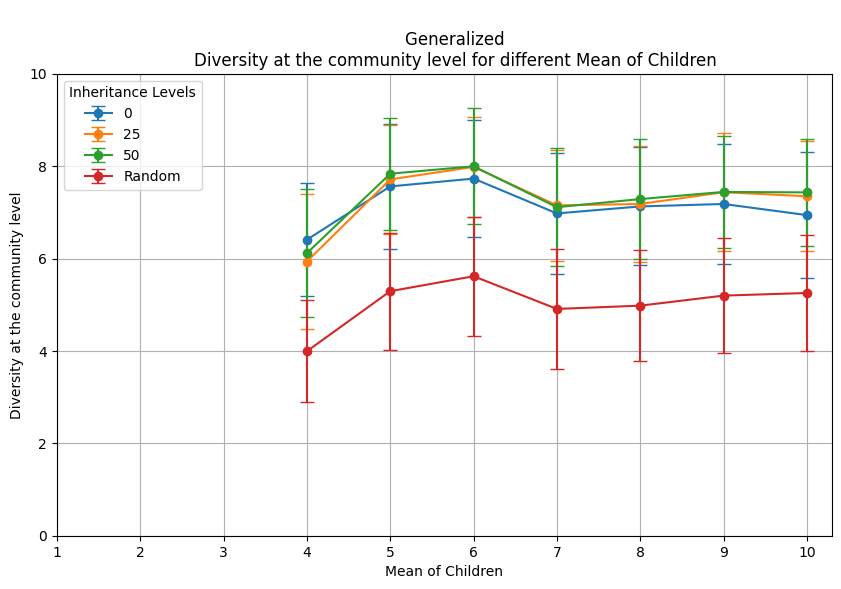

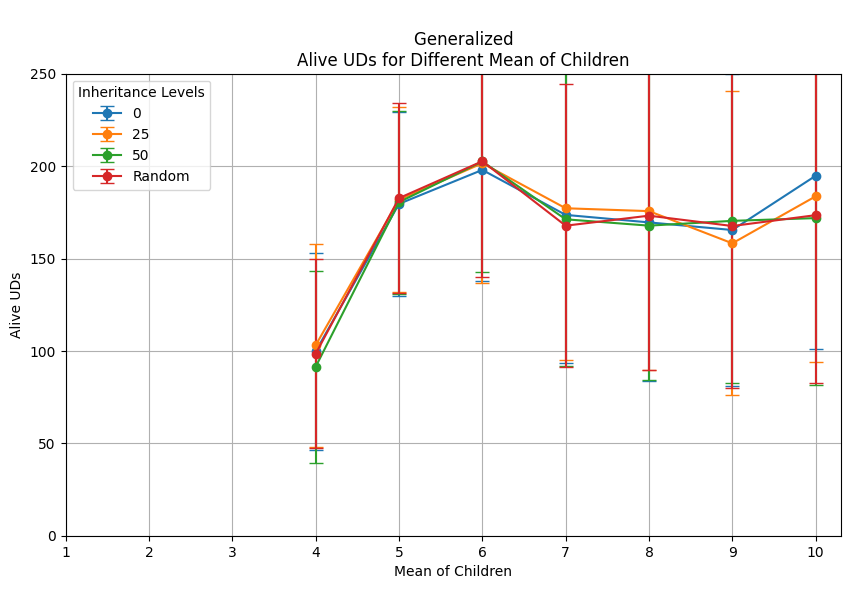

In [26]:
transversal_changes(GcM_datos, inherits, Gcalphas, 'Generalized', variable='Mean of Children')
transversal_alive(GcM_datos, inherits, Gcalphas, 'Generalized', variable='Mean of Children')

# Pop dynamics

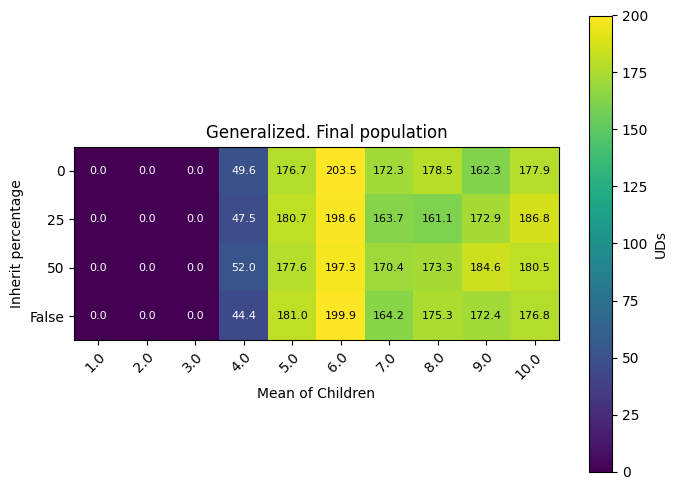

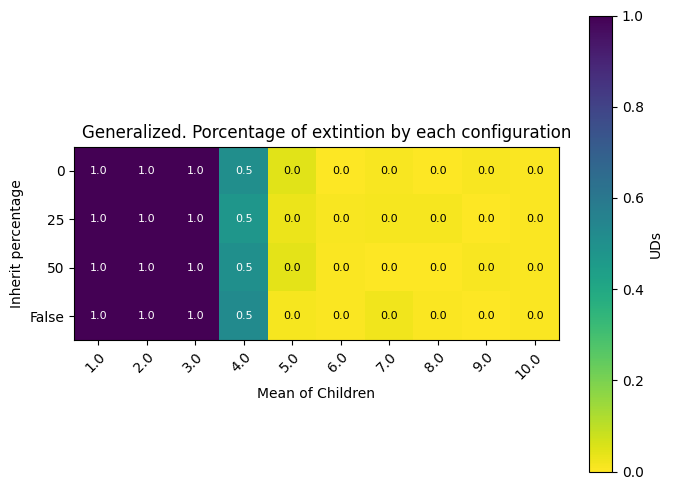

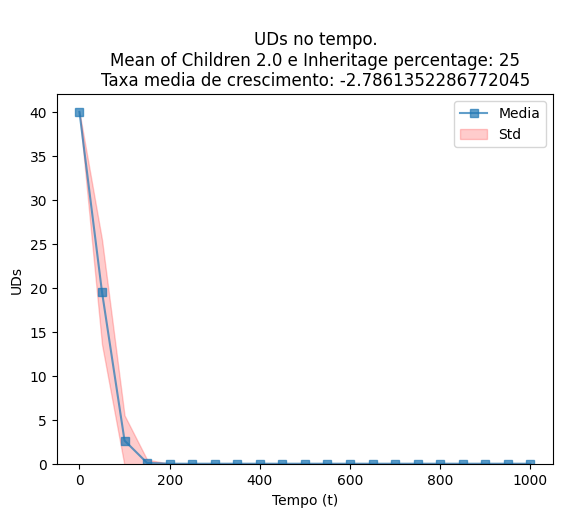

In [17]:
heat_population(GcM_datos, inherits, Gcalphas, 'Generalized', variable='Mean of Children')
heat_percentage_population(GcM_datos, inherits, Gcalphas, 'Generalized', variable='Mean of Children')
plot_specific_alivegraph(1, 1, GcM_datos, inherits, Gcalphas, 'Generalized', variable='Mean of Children')

## Mean varieties

In [ ]:
# This experiment has different values for Initial varieties mv NEW TRY!
prob_morte = 0.06 #beta
media = 4 # Mean
m = 40
#v = 10 # Initial varieties
mv = 10
inherits = [0,25,50, 'False']
# inherits = [0,25,50] #Values for inherit
#inherits = [0, 'False'] #Values for inherit
Gmvalphas = np.linspace(1,mv,mv)# Mean varieties from 1 to mv
# For data of behaviour
vM = np.empty((len(inherits), len(Gmvalphas)), dtype=object) # alive, mean and diversity levels

punto_vista = 50
tiempo = 1000
tempo = list(range(0,tiempo+1,punto_vista))
experiments = 100
max_iterations = 400

print(vM.shape)
start = time.time()
print(f"started at:  {datetime.now()}")
for i, inherit in enumerate(inherits):
    for j, mvarieties  in enumerate(Gmvalphas):
        star_configuration = time.time()
        #For population dynamics
        list_alive_UDs = []
        list_vivas_puntos_vista = []
        tasas_crecimiento = []
        #For diversity dynamics
        data_step_mean_var_ud = []
        data_step_var_system = []
        data_step_unique_system = []
        print(f"Experiments with inheritance {inherit} Initial UDs {m} and Mean varieties {mvarieties}")
        #Lists to store experiments' diversity data
        data_endo_mean_ud = []
        data_endo_com_level = []
        data_endo_total_varieties = []
        original_media = media
        #To see how frequent goes to extintion
        contador = 0
        iterations = 0
        while contador < experiments and iterations < max_iterations:
        #for experiment in range(1, experiments+1):
            print(f'experimento {contador+1}')
            ## Clans
            clans = (list(range(1, 4)) * (int(m) // 3 + 1))[:int(m)] # Just 3 clans
            random.shuffle(clans)
            if inherit != 'False':
                #### Initialization
                UD_generalized.uds = {}
                instancias_ud = []
                for id_ud in range(1, int(m) + 1):
                    instancias_ud.append(UD_generalized(id_ud, media, clans.pop()))
                ## Varieties
                limited_varieties = True
                if limited_varieties == False:
                    for id_ud, ud in UD_generalized.uds.items():
                        for _ in range(3):
                            ud.varieties.append(Variety())
                else:
                    initial_varieties = [Variety() for _ in range (int(10))]
                    for ud in UD_generalized.uds.values():
                        for _ in range(int(mvarieties)):
                            ud.varieties.append(random.choice(initial_varieties))   
                # Lists for graphs
                vivas_puntos_vista = [int(m)]
                vivas_tasa_crecimiento = [int(m)]
        #             mortas_puntos_vista = [0]
                #For diversity
                mean_var_ud = []
                var_system = []
                unique_system = []
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_generalized.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                # Simulation
                for t in range(1, tiempo):
                    uds_copy = {id_ud: ud for id_ud, ud in UD_generalized.uds.items() if ud.activa}
                    items = list(uds_copy.items())
                    random.shuffle(items)
                    uds_copy = dict(items)
                    alive = len(uds_copy)
                    if alive > 200 and (media == original_media):
                        media -= media//2
                        if media >= 4:
                            media = media //2
                    elif alive < 150 and media < original_media:
                        media = original_media
                    if not uds_copy: #Extintion
                        # Only 0
                        print(f"acabó en 0 el experimento {contador+1}")
                        #contador += 1
                        break         
                    # Cycle:
                    for id_ud, ud in uds_copy.items():
                        ud.ter_filho()
                        ud.buscar_ud(uds_copy, int(media), inherit, True, 0.2)
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
                    # Collecting data
                    vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                    if t % punto_vista == 0:
                        viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                        #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                        vivas_puntos_vista.append(viv)
                        # For diversity
                        var_ud = []
                        var_total = []
                        for ud in [ud for ud in UD_generalized.uds.values() if ud.activa ==True]:
                            var_ud.append(len(ud.varieties))
                            for variety in ud.varieties:
                                var_total.append(variety.variety_id)
                        mean_var_ud.append(np.mean(var_ud))
                        var_system.append(len(var_total))
                        unique_system.append(len(set(var_total))) 
                viv = len([ud for id, ud in UD_generalized.uds.items() if ud.activa])
                vivas_puntos_vista.append(viv)
                # For diversity
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_generalized.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                alive = (len([ud for id, ud in uds_copy.items() if ud.activa]))
                if alive >= 1:   
                    total_varieties = []
                    varieties_per_UD = []
                    for ud in [ud for ud in UD_generalized.uds.values() if ud.activa ==True]:
                        varieties_per_UD.append(len(ud.varieties))
                        for variety in ud.varieties:
                            total_varieties.append(variety.variety_id)
                    data_endo_mean_ud.append(np.mean(varieties_per_UD))
                    data_endo_com_level.append(len(set(total_varieties)))
                    data_endo_total_varieties.append(total_varieties)
            
            else:# Now with inherit == False
                #### Initialization
                UD_generalized_al_inh.uds = {}
                instancias_ud = []
                for id_ud in range(1, int(m) + 1):
                    instancias_ud.append(UD_generalized_al_inh(id_ud, media, clans.pop()))
                ## Varieties
                limited_varieties = True
                if limited_varieties == False:
                    for id_ud, ud in UD_generalized_al_inh.uds.items():
                        for _ in range(3):
                            ud.varieties.append(Variety())
                else:
                    initial_varieties = [Variety() for _ in range (int(10))]
                    for ud in UD_generalized_al_inh.uds.values():
                        for _ in range(int(mvarieties)):
                            ud.varieties.append(random.choice(initial_varieties))   
                # Lists for graphs
                vivas_puntos_vista = [int(m)]
                vivas_tasa_crecimiento = [int(m)]
        #             mortas_puntos_vista = [0]
                #For diversity
                mean_var_ud = []
                var_system = []
                unique_system = []
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_generalized_al_inh.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                # Simulation
                for t in range(1, tiempo):
                    uds_copy = {id_ud: ud for id_ud, ud in UD_generalized_al_inh.uds.items() if ud.activa}
                    items = list(uds_copy.items())
                    random.shuffle(items)
                    uds_copy = dict(items)
                    alive = len(uds_copy)
                    if alive > 200 and (media == original_media):
                        media -= media//2
                        if media >= 4:
                            media = media //2
                    elif alive < 150 and media < original_media:
                        media = original_media
                    if not uds_copy: #Extintion
                        # Only 0
                        print(f"acabó en 0 el experimento {experiment} con herencia {inherits[i]}")
                        break         
                    # Cycle:
                    varieties_list = [var for ud in uds_copy.values() for var in ud.varieties]
                    for id_ud, ud in uds_copy.items():
                        ud.ter_filho()
                        ud.buscar_ud(uds_copy, int(media), varieties_list, True, int(mvarieties), 0.2)
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
                    # Collecting data
                    vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                    if t % punto_vista == 0:
                        viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                        #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                        vivas_puntos_vista.append(viv)
                        # For diversity
                        var_ud = []
                        var_total = []
                        for ud in [ud for ud in UD_generalized_al_inh.uds.values() if ud.activa ==True]:
                            var_ud.append(len(ud.varieties))
                            for variety in ud.varieties:
                                var_total.append(variety.variety_id)
                        mean_var_ud.append(np.mean(var_ud))
                        var_system.append(len(var_total))
                        unique_system.append(len(set(var_total))) 
                viv = len([ud for id, ud in UD_generalized_al_inh.uds.items() if ud.activa])
                vivas_puntos_vista.append(viv)
                # For diversity
                var_ud = []
                var_total = []
                for ud in [ud for ud in UD_generalized_al_inh.uds.values() if ud.activa ==True]:
                    var_ud.append(len(ud.varieties))
                    for variety in ud.varieties:
                        var_total.append(variety.variety_id)
                mean_var_ud.append(np.mean(var_ud))
                var_system.append(len(var_total))
                unique_system.append(len(set(var_total)))
                alive = (len([ud for id, ud in uds_copy.items() if ud.activa]))
                if alive >= 1:   
                    total_varieties = []
                    varieties_per_UD = []
                    for ud in [ud for ud in UD_generalized_al_inh.uds.values() if ud.activa ==True]:
                        varieties_per_UD.append(len(ud.varieties))
                        for variety in ud.varieties:
                            total_varieties.append(variety.variety_id)
                    data_endo_mean_ud.append(np.mean(varieties_per_UD))
                    data_endo_com_level.append(len(set(total_varieties)))
                    data_endo_total_varieties.append(total_varieties)
            
            
            # Final collection of the data after the simulation!
            if len(uds_copy) > 0:  # Only collect data if the system is alive
                list_alive_UDs.append(len([ud for id, ud in uds_copy.items() if ud.activa == True]))  # For heatmap
                list_vivas_puntos_vista.append(vivas_puntos_vista)
                data_step_var_system.append(var_system)
                data_step_unique_system.append(unique_system)
                data_step_mean_var_ud.append(mean_var_ud)
                contador += 1
            iterations += 1
            print('succesful')
            print(contador)
            print('iterations')
            print(iterations)
            
            data_inherit_endo = [data_endo_mean_ud, data_endo_com_level, data_endo_total_varieties]
        data_steps_inherit_endo = [data_step_var_system, data_step_unique_system, data_step_mean_var_ud]
        media = original_media
        end_config = time.time()
        
        if contador == experiments:  # Check if there's valid data (i.e., the system survived)
            vM[i][j] = {
                'alive': np.mean(list_alive_UDs),
                'lstd': np.std(list_alive_UDs),
                'time used': end_config - star_configuration,
                'percentage_extinction': contador / experiments,
                'tempo': tempo, 
                'mean': np.mean(list_vivas_puntos_vista, axis=0), 
                'std': np.std(list_vivas_puntos_vista, axis=0),
                'growth rate': np.mean([np.mean(lista) for lista in tasas_crecimiento]),
                'diversity_info': data_inherit_endo,
                'diversity_info_steps': data_steps_inherit_endo,
            }
        else:  # Handle extinction-only scenarios
            vM[i][j] = {
                'alive': None,
                'lstd': None,
                'time used': end_config - star_configuration,
                'percentage_extinction': 1.0,  # All experiments went extinct
                'tempo': None, 
                'mean': None, 
                'std': None,
                'growth rate': None,
                'diversity_info': None,
                'diversity_info_steps': None,
            }
        print(f"""
The total time of the configuration of inherit percentage {inherit}, 
  initial UDs {m} and Mean varieties {mvarieties} is  {end_config - star_configuration}
        """)
# Folder
folder_name = 'Experiments_kinship_inheritance_parameters'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Heatmap and std
heat_std = os.path.join(folder_name, 'Generalized_Initial_Mean_varieties.npy')
np.save(heat_std, vM)
now = datetime.now()
finish = time.time()
print(f"""
It finished at: {now}
It lasted {finish-start}
""")
print("done")

In [27]:
# Dowload the documents
#As a reference
mv = 10 # Mean
inherits = [0,25,50, 'False']
#inherits = [0,'False']
Dmvalphas = np.linspace(1,mv,mv) # Mean of children from 1 to n
punto_vista = 50
tiempo = 1000
tempo = list(range(0,tiempo+1,punto_vista))

#Folders
folder_name = 'Experiments_kinship_inheritance_parameters'
heat_std = os.path.join(folder_name, 'Generalized_Initial_Mean_varieties.npy')

## General Data
DmvM_datos = np.load(heat_std, allow_pickle=True)

## Diversity dynamics

In [15]:
#heat_diversity_comm_level(DmvM_datos, inherits, Dmvalphas, 'Generalized', variable='Mean varieties')

#diversity_change_graphs(DmvM_datos, inherits, Dmvalphas, 'Generalized', variable='Mean varieties', limitant = True)

NameError: name 'diversity_change_graphs' is not defined

In [37]:
# diversity_change_by_row(DmvM_datos, inherits, Dmvalphas, 'Generalized', variable='Mean varieties', limitant = True)

# diversity_change_by_column(DmvM_datos, inherits, Dmvalphas, 'Generalized', variable='Mean varieties', limitant = True)

NameError: name 'diversity_change_by_row' is not defined

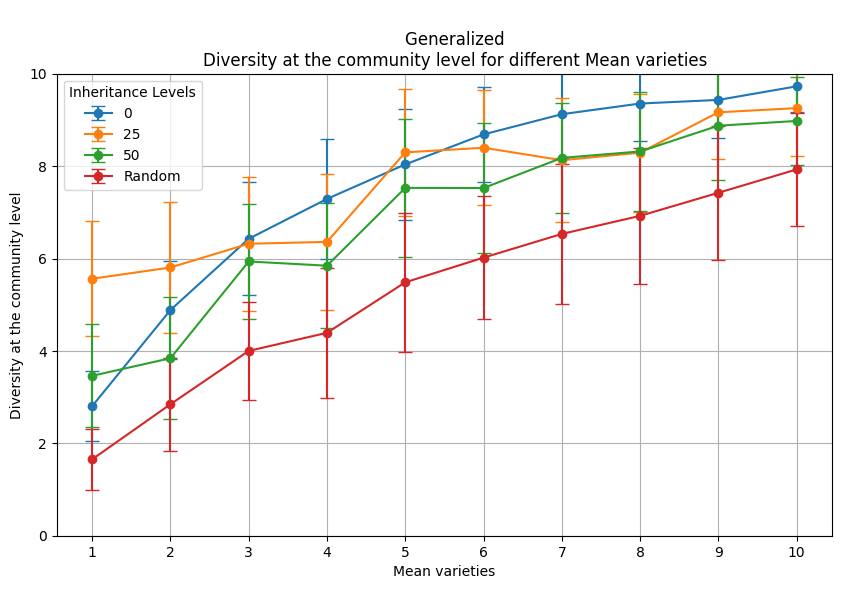

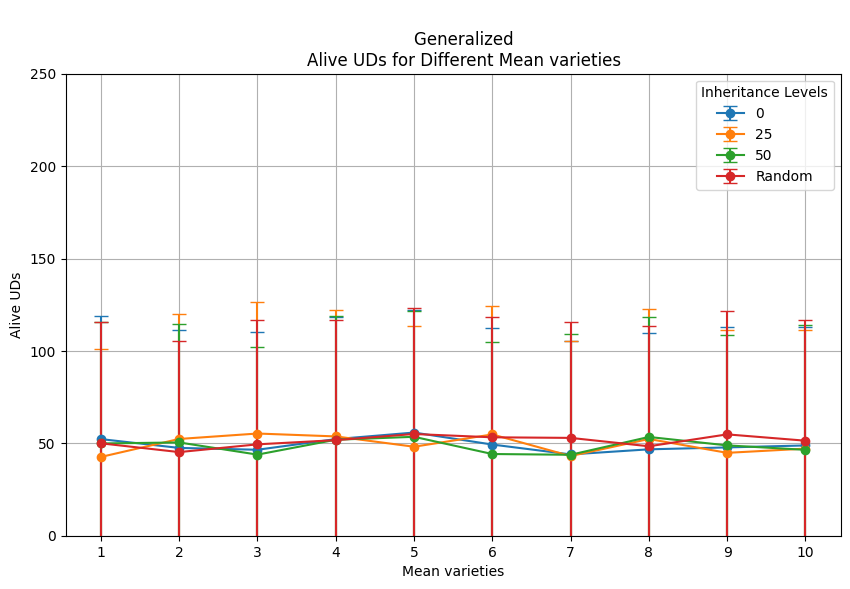

In [28]:
transversal_changes(DmvM_datos, inherits, Dmvalphas, 'Generalized', variable='Mean varieties')
transversal_alive(DmvM_datos, inherits, Dmvalphas, 'Generalized', variable='Mean varieties')

## Population Dynamics

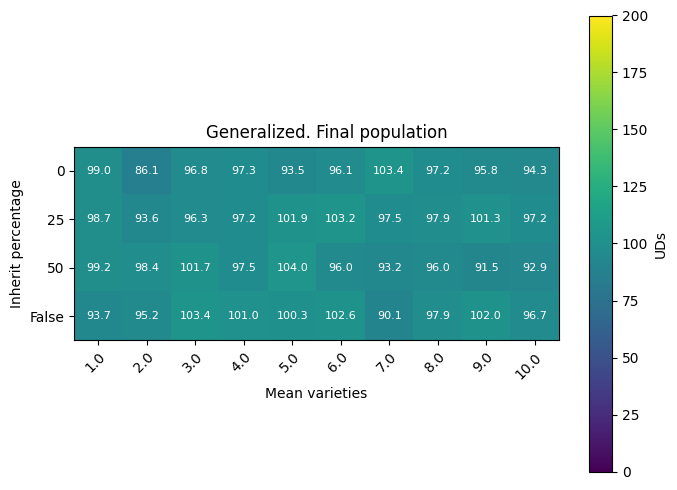

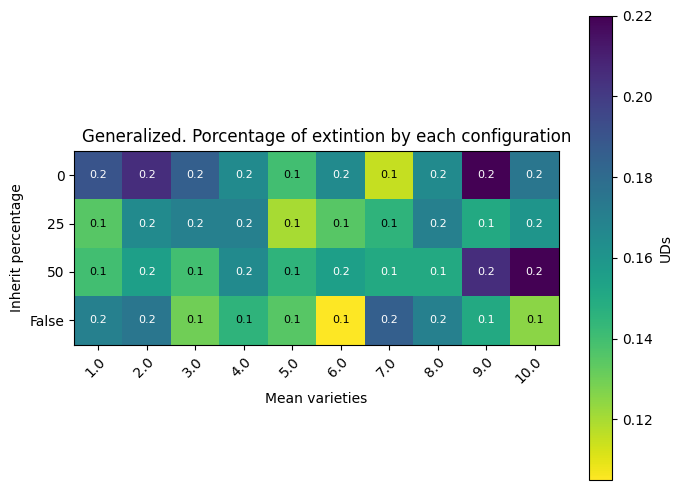

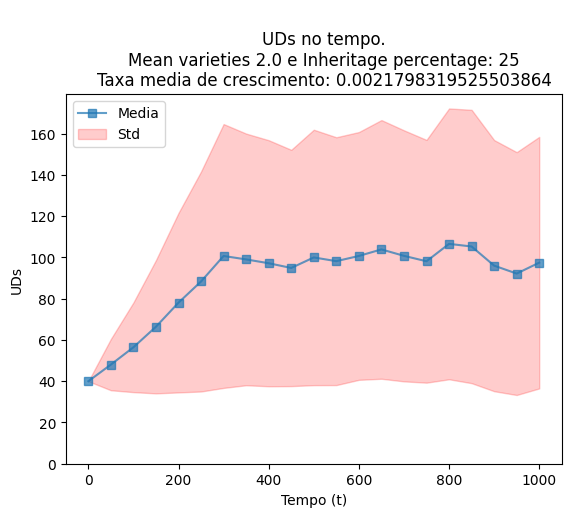

In [121]:
heat_population(DmvM_datos, inherits, Dmvalphas, 'Generalized', variable='Mean varieties')

heat_percentage_population(DmvM_datos, inherits, Dmvalphas, 'Generalized', variable='Mean varieties')

plot_specific_alivegraph(1, 1, DmvM_datos, inherits, Dmvalphas, 'Generalized', variable='Mean varieties')

In [22]:
DmvM_datosnew[1][0]

{'alive': np.float64(81.0),
 'std': array([ 0.        , 14.94991639, 26.31539473, 28.61380786, 23.41340428,
        20.18662924, 36.85444342, 43.96873889, 57.0542505 , 50.70687823,
        61.76771001, 34.21257079, 47.03389735, 19.14418972, 35.03569608,
        62.45148117, 71.83444508, 42.97964635, 52.68953881, 48.20269702,
        12.25765067]),
 'time used': 18.672905445098877,
 'percentage_extinction': 0.6,
 'tempo': [0,
  50,
  100,
  150,
  200,
  250,
  300,
  350,
  400,
  450,
  500,
  550,
  600,
  650,
  700,
  750,
  800,
  850,
  900,
  950,
  1000],
 'mean': array([ 40.  ,  50.  ,  61.  ,  59.5 ,  76.75,  73.  ,  88.5 , 110.5 ,
        111.25,  97.75, 105.5 ,  90.  ,  87.25,  93.  , 110.  , 129.75,
        122.75,  96.5 ,  95.75,  95.  ,  83.5 ]),
 'growth rate': np.float64(nan),
 'diversity_info': [[np.float64(4.0),
   np.float64(4.0),
   np.float64(4.0),
   np.float64(4.0)],
  [5, 5, 5, 5],
  [[3040604,
    3040604,
    3040604,
    3080405,
    6060508,
    6060508,
  

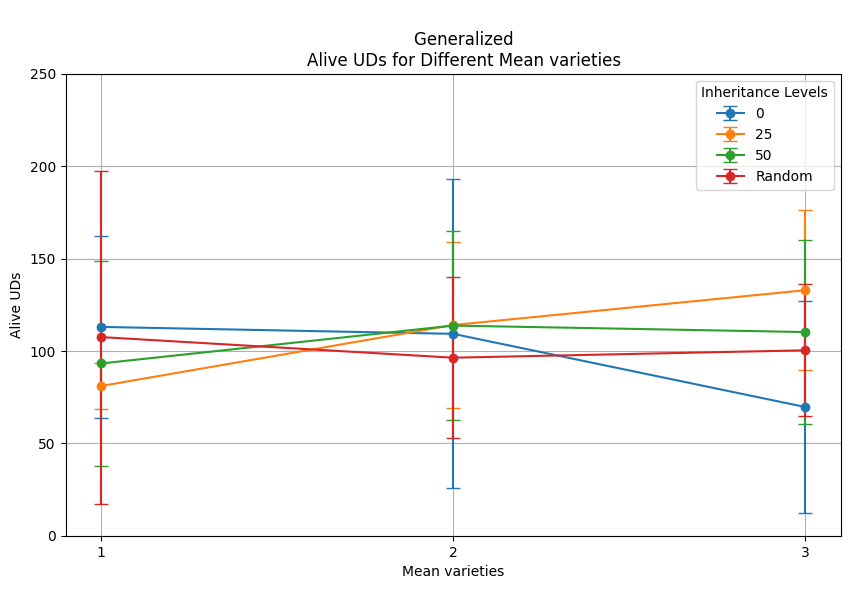

In [80]:
transversal_alive(DmvM_datosnew, inherits, Dmvalphas, 'Generalized', variable='Mean varieties')

In [ ]:
def transversal_changes(matrix, inherits, alphas, kinship_system, variable = ''):
    #Plot
    plt.figure(figsize=(10, 6))
    for i, inherit in enumerate(inherits):  # Loop for graphs
        means, stds = [], [] #Lists
        for j, malpha in enumerate(alphas):
            data = matrix[i][j]['diversity_info'][1]
            means.append(np.mean(data))  # Mean
            stds.append(np.std(data))    # Std
        #plot for each Initial UDs according to the inherit
        if inherit != 'False':
            plt.errorbar(alphas, means, yerr=stds, label=f'{inherit}', fmt='-o', capsize=5)
        else:
            plt.errorbar(alphas, means, yerr=stds, label=f'Random', fmt='-o', capsize=5)

    plt.xlabel(variable)
    plt.xticks(alphas)
    plt.ylabel('Diversity at the community level')
    plt.title(f'''
    {kinship_system}
    Diversity at the community level for different {variable}''')
    plt.legend(title="Inheritance Levels")
    plt.grid(True)
    plt.ylim(0,10)
    plt.show()